In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CustomBaselineV2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

THETA = math.pi/2
STANDARD_DEVIATION = 0.0005

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.rotate_flip_add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(1485000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.custom_baseline_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 36)             9252      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 18)             2610      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 18)             0         
_________________________________________________________________
flatten (Flatten)            (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               4864      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


   1/1306 [..............................] - ETA: 4:20:27 - loss: 2.3979

  11/1306 [..............................] - ETA: 6s - loss: 2.3977     

  21/1306 [..............................] - ETA: 6s - loss: 2.3970

  32/1306 [..............................] - ETA: 6s - loss: 2.3953

  43/1306 [..............................] - ETA: 6s - loss: 2.3914

  54/1306 [>.............................] - ETA: 6s - loss: 2.3844

  66/1306 [>.............................] - ETA: 6s - loss: 2.3744

  78/1306 [>.............................] - ETA: 5s - loss: 2.3637



  89/1306 [=>............................] - ETA: 5s - loss: 2.3540

 100/1306 [=>............................] - ETA: 5s - loss: 2.3447

 112/1306 [=>............................] - ETA: 5s - loss: 2.3353

 123/1306 [=>............................] - ETA: 5s - loss: 2.3274

 135/1306 [==>...........................] - ETA: 5s - loss: 2.3195

 146/1306 [==>...........................] - ETA: 5s - loss: 2.3128

 158/1306 [==>...........................] - ETA: 5s - loss: 2.3060

 170/1306 [==>...........................] - ETA: 5s - loss: 2.2996

 182/1306 [===>..........................] - ETA: 5s - loss: 2.2937

 193/1306 [===>..........................] - ETA: 5s - loss: 2.2887

 205/1306 [===>..........................] - ETA: 5s - loss: 2.2834

 217/1306 [===>..........................] - ETA: 5s - loss: 2.2785

 228/1306 [====>.........................] - ETA: 4s - loss: 2.2742

 240/1306 [====>.........................] - ETA: 4s - loss: 2.2697

 252/1306 [====>.........................] - ETA: 4s - loss: 2.2655

 264/1306 [=====>........................] - ETA: 4s - loss: 2.2615

 275/1306 [=====>........................] - ETA: 4s - loss: 2.2579

 286/1306 [=====>........................] - ETA: 4s - loss: 2.2544

 297/1306 [=====>........................] - ETA: 4s - loss: 2.2510

 309/1306 [======>.......................] - ETA: 4s - loss: 2.2474

 321/1306 [======>.......................] - ETA: 4s - loss: 2.2438

 333/1306 [======>.......................] - ETA: 4s - loss: 2.2402

 345/1306 [======>.......................] - ETA: 4s - loss: 2.2367

 357/1306 [=======>......................] - ETA: 4s - loss: 2.2332

 369/1306 [=======>......................] - ETA: 4s - loss: 2.2297

 381/1306 [=======>......................] - ETA: 4s - loss: 2.2262

 393/1306 [========>.....................] - ETA: 4s - loss: 2.2227

 405/1306 [========>.....................] - ETA: 4s - loss: 2.2193

 417/1306 [========>.....................] - ETA: 4s - loss: 2.2159

 428/1306 [========>.....................] - ETA: 4s - loss: 2.2128

 440/1306 [=========>....................] - ETA: 3s - loss: 2.2095

 451/1306 [=========>....................] - ETA: 3s - loss: 2.2064

 463/1306 [=========>....................] - ETA: 3s - loss: 2.2031

 475/1306 [=========>....................] - ETA: 3s - loss: 2.1999

 487/1306 [==========>...................] - ETA: 3s - loss: 2.1967

 499/1306 [==========>...................] - ETA: 3s - loss: 2.1936

 511/1306 [==========>...................] - ETA: 3s - loss: 2.1904

 523/1306 [===========>..................] - ETA: 3s - loss: 2.1874

 535/1306 [===========>..................] - ETA: 3s - loss: 2.1843

 546/1306 [===========>..................] - ETA: 3s - loss: 2.1816

 558/1306 [===========>..................] - ETA: 3s - loss: 2.1786

 570/1306 [============>.................] - ETA: 3s - loss: 2.1757



 581/1306 [============>.................] - ETA: 3s - loss: 2.1731

 593/1306 [============>.................] - ETA: 3s - loss: 2.1703

 605/1306 [============>.................] - ETA: 3s - loss: 2.1675

 617/1306 [=============>................] - ETA: 3s - loss: 2.1647

 629/1306 [=============>................] - ETA: 3s - loss: 2.1620

 641/1306 [=============>................] - ETA: 2s - loss: 2.1593



 653/1306 [==============>...............] - ETA: 2s - loss: 2.1567

 665/1306 [==============>...............] - ETA: 2s - loss: 2.1541



 677/1306 [==============>...............] - ETA: 2s - loss: 2.1515

 689/1306 [==============>...............] - ETA: 2s - loss: 2.1489

 702/1306 [===============>..............] - ETA: 2s - loss: 2.1462

 714/1306 [===============>..............] - ETA: 2s - loss: 2.1438

 725/1306 [===============>..............] - ETA: 2s - loss: 2.1416

 737/1306 [===============>..............] - ETA: 2s - loss: 2.1392



 749/1306 [================>.............] - ETA: 2s - loss: 2.1368

 761/1306 [================>.............] - ETA: 2s - loss: 2.1345

 772/1306 [================>.............] - ETA: 2s - loss: 2.1324

 784/1306 [=================>............] - ETA: 2s - loss: 2.1301

 796/1306 [=================>............] - ETA: 2s - loss: 2.1278

 808/1306 [=================>............] - ETA: 2s - loss: 2.1256

 821/1306 [=================>............] - ETA: 2s - loss: 2.1233

 833/1306 [==================>...........] - ETA: 2s - loss: 2.1211

 845/1306 [==================>...........] - ETA: 2s - loss: 2.1190

 857/1306 [==================>...........] - ETA: 2s - loss: 2.1169

 869/1306 [==================>...........] - ETA: 1s - loss: 2.1148

 882/1306 [===================>..........] - ETA: 1s - loss: 2.1126



 894/1306 [===================>..........] - ETA: 1s - loss: 2.1106

 906/1306 [===================>..........] - ETA: 1s - loss: 2.1086

 918/1306 [====================>.........] - ETA: 1s - loss: 2.1067

 930/1306 [====================>.........] - ETA: 1s - loss: 2.1047

 942/1306 [====================>.........] - ETA: 1s - loss: 2.1028

 954/1306 [====================>.........] - ETA: 1s - loss: 2.1009

 966/1306 [=====================>........] - ETA: 1s - loss: 2.0990

 978/1306 [=====================>........] - ETA: 1s - loss: 2.0972



 989/1306 [=====================>........] - ETA: 1s - loss: 2.0955

1001/1306 [=====================>........] - ETA: 1s - loss: 2.0937

1013/1306 [======================>.......] - ETA: 1s - loss: 2.0920

1025/1306 [======================>.......] - ETA: 1s - loss: 2.0902

1037/1306 [======================>.......] - ETA: 1s - loss: 2.0885



1049/1306 [=======================>......] - ETA: 1s - loss: 2.0867

1061/1306 [=======================>......] - ETA: 1s - loss: 2.0850

1073/1306 [=======================>......] - ETA: 1s - loss: 2.0834



1085/1306 [=======================>......] - ETA: 0s - loss: 2.0817

1097/1306 [========================>.....] - ETA: 0s - loss: 2.0801

1110/1306 [========================>.....] - ETA: 0s - loss: 2.0783

1122/1306 [========================>.....] - ETA: 0s - loss: 2.0767

1133/1306 [=========================>....] - ETA: 0s - loss: 2.0752

1146/1306 [=========================>....] - ETA: 0s - loss: 2.0735



1158/1306 [=========================>....] - ETA: 0s - loss: 2.0720

1171/1306 [=========================>....] - ETA: 0s - loss: 2.0703

1184/1306 [==========================>...] - ETA: 0s - loss: 2.0686

1195/1306 [==========================>...] - ETA: 0s - loss: 2.0673

1207/1306 [==========================>...] - ETA: 0s - loss: 2.0658



1219/1306 [===========================>..] - ETA: 0s - loss: 2.0643

1231/1306 [===========================>..] - ETA: 0s - loss: 2.0628

1243/1306 [===========================>..] - ETA: 0s - loss: 2.0614

1255/1306 [===========================>..] - ETA: 0s - loss: 2.0599

1267/1306 [============================>.] - ETA: 0s - loss: 2.0585

1279/1306 [============================>.] - ETA: 0s - loss: 2.0571

1291/1306 [============================>.] - ETA: 0s - loss: 2.0557

1303/1306 [============================>.] - ETA: 0s - loss: 2.0543

1306/1306 [==============================] - ETA: 0s - loss: 2.0539

1306/1306 [==============================] - 19s 5ms/step - loss: 2.0538 - val_loss: 1.7185


Epoch 2/100
   1/1306 [..............................] - ETA: 6s - loss: 1.7392

  13/1306 [..............................] - ETA: 5s - loss: 1.6997

  25/1306 [..............................] - ETA: 5s - loss: 1.6998

  37/1306 [..............................] - ETA: 5s - loss: 1.6992

  49/1306 [>.............................] - ETA: 5s - loss: 1.6983

  61/1306 [>.............................] - ETA: 5s - loss: 1.6978



  73/1306 [>.............................] - ETA: 5s - loss: 1.6974

  85/1306 [>.............................] - ETA: 5s - loss: 1.6971

  97/1306 [=>............................] - ETA: 5s - loss: 1.6967

 109/1306 [=>............................] - ETA: 5s - loss: 1.6962

 121/1306 [=>............................] - ETA: 5s - loss: 1.6955

 133/1306 [==>...........................] - ETA: 5s - loss: 1.6948



 145/1306 [==>...........................] - ETA: 5s - loss: 1.6941

 157/1306 [==>...........................] - ETA: 4s - loss: 1.6934

 169/1306 [==>...........................] - ETA: 4s - loss: 1.6928

 181/1306 [===>..........................] - ETA: 4s - loss: 1.6921



 193/1306 [===>..........................] - ETA: 4s - loss: 1.6915

 204/1306 [===>..........................] - ETA: 4s - loss: 1.6910

 215/1306 [===>..........................] - ETA: 4s - loss: 1.6905



 225/1306 [====>.........................] - ETA: 4s - loss: 1.6900

 237/1306 [====>.........................] - ETA: 4s - loss: 1.6895

 251/1306 [====>.........................] - ETA: 4s - loss: 1.6889

 264/1306 [=====>........................] - ETA: 4s - loss: 1.6883

 277/1306 [=====>........................] - ETA: 4s - loss: 1.6878

 290/1306 [=====>........................] - ETA: 4s - loss: 1.6872

 303/1306 [=====>........................] - ETA: 4s - loss: 1.6867

 317/1306 [======>.......................] - ETA: 4s - loss: 1.6861

 331/1306 [======>.......................] - ETA: 4s - loss: 1.6856

 345/1306 [======>.......................] - ETA: 4s - loss: 1.6850

 358/1306 [=======>......................] - ETA: 4s - loss: 1.6845

 371/1306 [=======>......................] - ETA: 3s - loss: 1.6841



 384/1306 [=======>......................] - ETA: 3s - loss: 1.6836



 398/1306 [========>.....................] - ETA: 3s - loss: 1.6831

 411/1306 [========>.....................] - ETA: 3s - loss: 1.6826

 424/1306 [========>.....................] - ETA: 3s - loss: 1.6822

 437/1306 [=========>....................] - ETA: 3s - loss: 1.6817

 450/1306 [=========>....................] - ETA: 3s - loss: 1.6813

 463/1306 [=========>....................] - ETA: 3s - loss: 1.6809



 476/1306 [=========>....................] - ETA: 3s - loss: 1.6804



 489/1306 [==========>...................] - ETA: 3s - loss: 1.6800

 502/1306 [==========>...................] - ETA: 3s - loss: 1.6796

 514/1306 [==========>...................] - ETA: 3s - loss: 1.6792

 527/1306 [===========>..................] - ETA: 3s - loss: 1.6788

 540/1306 [===========>..................] - ETA: 3s - loss: 1.6784



 552/1306 [===========>..................] - ETA: 3s - loss: 1.6780



 564/1306 [===========>..................] - ETA: 3s - loss: 1.6777

 577/1306 [============>.................] - ETA: 3s - loss: 1.6773

 591/1306 [============>.................] - ETA: 2s - loss: 1.6769

 605/1306 [============>.................] - ETA: 2s - loss: 1.6764

 619/1306 [=============>................] - ETA: 2s - loss: 1.6760

 632/1306 [=============>................] - ETA: 2s - loss: 1.6756

 645/1306 [=============>................] - ETA: 2s - loss: 1.6753

 658/1306 [==============>...............] - ETA: 2s - loss: 1.6749

 670/1306 [==============>...............] - ETA: 2s - loss: 1.6745

 683/1306 [==============>...............] - ETA: 2s - loss: 1.6742

 696/1306 [==============>...............] - ETA: 2s - loss: 1.6738

 709/1306 [===============>..............] - ETA: 2s - loss: 1.6735



 722/1306 [===============>..............] - ETA: 2s - loss: 1.6731

 735/1306 [===============>..............] - ETA: 2s - loss: 1.6728

 748/1306 [================>.............] - ETA: 2s - loss: 1.6724

 762/1306 [================>.............] - ETA: 2s - loss: 1.6720



 776/1306 [================>.............] - ETA: 2s - loss: 1.6717

 790/1306 [=================>............] - ETA: 2s - loss: 1.6713

 802/1306 [=================>............] - ETA: 2s - loss: 1.6710

 815/1306 [=================>............] - ETA: 2s - loss: 1.6707

 828/1306 [==================>...........] - ETA: 1s - loss: 1.6703

 841/1306 [==================>...........] - ETA: 1s - loss: 1.6700

 854/1306 [==================>...........] - ETA: 1s - loss: 1.6697

 867/1306 [==================>...........] - ETA: 1s - loss: 1.6693

 880/1306 [===================>..........] - ETA: 1s - loss: 1.6690



 892/1306 [===================>..........] - ETA: 1s - loss: 1.6687

 904/1306 [===================>..........] - ETA: 1s - loss: 1.6684

 916/1306 [====================>.........] - ETA: 1s - loss: 1.6681

 929/1306 [====================>.........] - ETA: 1s - loss: 1.6678

 942/1306 [====================>.........] - ETA: 1s - loss: 1.6675

 955/1306 [====================>.........] - ETA: 1s - loss: 1.6672

 969/1306 [=====================>........] - ETA: 1s - loss: 1.6669



 982/1306 [=====================>........] - ETA: 1s - loss: 1.6666



 996/1306 [=====================>........] - ETA: 1s - loss: 1.6662

1009/1306 [======================>.......] - ETA: 1s - loss: 1.6659

1022/1306 [======================>.......] - ETA: 1s - loss: 1.6657

1035/1306 [======================>.......] - ETA: 1s - loss: 1.6654

1048/1306 [=======================>......] - ETA: 1s - loss: 1.6651

1061/1306 [=======================>......] - ETA: 0s - loss: 1.6648

1074/1306 [=======================>......] - ETA: 0s - loss: 1.6645

1087/1306 [=======================>......] - ETA: 0s - loss: 1.6642

1099/1306 [========================>.....] - ETA: 0s - loss: 1.6639

1112/1306 [========================>.....] - ETA: 0s - loss: 1.6637

1124/1306 [========================>.....] - ETA: 0s - loss: 1.6634

1137/1306 [=========================>....] - ETA: 0s - loss: 1.6631

1150/1306 [=========================>....] - ETA: 0s - loss: 1.6628

1163/1306 [=========================>....] - ETA: 0s - loss: 1.6626

1176/1306 [==========================>...] - ETA: 0s - loss: 1.6623

1188/1306 [==========================>...] - ETA: 0s - loss: 1.6620

1201/1306 [==========================>...] - ETA: 0s - loss: 1.6618

1213/1306 [==========================>...] - ETA: 0s - loss: 1.6615

1225/1306 [===========================>..] - ETA: 0s - loss: 1.6613

1237/1306 [===========================>..] - ETA: 0s - loss: 1.6610

1249/1306 [===========================>..] - ETA: 0s - loss: 1.6608

1261/1306 [===========================>..] - ETA: 0s - loss: 1.6606

1274/1306 [============================>.] - ETA: 0s - loss: 1.6603

1286/1306 [============================>.] - ETA: 0s - loss: 1.6601

1298/1306 [============================>.] - ETA: 0s - loss: 1.6598

1306/1306 [==============================] - 6s 4ms/step - loss: 1.6596 - val_loss: 1.5927


Epoch 3/100
   1/1306 [..............................] - ETA: 6s - loss: 1.5205

  13/1306 [..............................] - ETA: 5s - loss: 1.5795

  26/1306 [..............................] - ETA: 5s - loss: 1.5858

  38/1306 [..............................] - ETA: 5s - loss: 1.5877

  50/1306 [>.............................] - ETA: 5s - loss: 1.5887

  62/1306 [>.............................] - ETA: 5s - loss: 1.5892

  74/1306 [>.............................] - ETA: 5s - loss: 1.5898

  86/1306 [>.............................] - ETA: 5s - loss: 1.5905



  98/1306 [=>............................] - ETA: 5s - loss: 1.5911

 110/1306 [=>............................] - ETA: 5s - loss: 1.5915

 122/1306 [=>............................] - ETA: 5s - loss: 1.5917

 134/1306 [==>...........................] - ETA: 5s - loss: 1.5919

 146/1306 [==>...........................] - ETA: 5s - loss: 1.5921

 158/1306 [==>...........................] - ETA: 4s - loss: 1.5921

 170/1306 [==>...........................] - ETA: 4s - loss: 1.5922

 182/1306 [===>..........................] - ETA: 4s - loss: 1.5923

 194/1306 [===>..........................] - ETA: 4s - loss: 1.5923

 206/1306 [===>..........................] - ETA: 4s - loss: 1.5923

 218/1306 [====>.........................] - ETA: 4s - loss: 1.5922

 230/1306 [====>.........................] - ETA: 4s - loss: 1.5922

 242/1306 [====>.........................] - ETA: 4s - loss: 1.5922

 254/1306 [====>.........................] - ETA: 4s - loss: 1.5922

 266/1306 [=====>........................] - ETA: 4s - loss: 1.5921

 278/1306 [=====>........................] - ETA: 4s - loss: 1.5921

 290/1306 [=====>........................] - ETA: 4s - loss: 1.5920

 303/1306 [=====>........................] - ETA: 4s - loss: 1.5919

 315/1306 [======>.......................] - ETA: 4s - loss: 1.5918

 327/1306 [======>.......................] - ETA: 4s - loss: 1.5917

 338/1306 [======>.......................] - ETA: 4s - loss: 1.5916

 350/1306 [=======>......................] - ETA: 4s - loss: 1.5915



 362/1306 [=======>......................] - ETA: 4s - loss: 1.5914

 374/1306 [=======>......................] - ETA: 4s - loss: 1.5913

 386/1306 [=======>......................] - ETA: 4s - loss: 1.5912

 398/1306 [========>.....................] - ETA: 3s - loss: 1.5911

 410/1306 [========>.....................] - ETA: 3s - loss: 1.5909

 422/1306 [========>.....................] - ETA: 3s - loss: 1.5908

 434/1306 [========>.....................] - ETA: 3s - loss: 1.5907

 446/1306 [=========>....................] - ETA: 3s - loss: 1.5906

 458/1306 [=========>....................] - ETA: 3s - loss: 1.5905

 470/1306 [=========>....................] - ETA: 3s - loss: 1.5903

 482/1306 [==========>...................] - ETA: 3s - loss: 1.5902

 494/1306 [==========>...................] - ETA: 3s - loss: 1.5901

 506/1306 [==========>...................] - ETA: 3s - loss: 1.5900

 518/1306 [==========>...................] - ETA: 3s - loss: 1.5899

 530/1306 [===========>..................] - ETA: 3s - loss: 1.5898



 542/1306 [===========>..................] - ETA: 3s - loss: 1.5897

 554/1306 [===========>..................] - ETA: 3s - loss: 1.5896

 566/1306 [============>.................] - ETA: 3s - loss: 1.5894

 578/1306 [============>.................] - ETA: 3s - loss: 1.5893

 590/1306 [============>.................] - ETA: 3s - loss: 1.5892

 602/1306 [============>.................] - ETA: 3s - loss: 1.5891

 614/1306 [=============>................] - ETA: 3s - loss: 1.5889

 626/1306 [=============>................] - ETA: 2s - loss: 1.5888

 638/1306 [=============>................] - ETA: 2s - loss: 1.5887

 650/1306 [=============>................] - ETA: 2s - loss: 1.5886

 662/1306 [==============>...............] - ETA: 2s - loss: 1.5884

 674/1306 [==============>...............] - ETA: 2s - loss: 1.5883

 686/1306 [==============>...............] - ETA: 2s - loss: 1.5882

 698/1306 [===============>..............] - ETA: 2s - loss: 1.5881

 710/1306 [===============>..............] - ETA: 2s - loss: 1.5879

 722/1306 [===============>..............] - ETA: 2s - loss: 1.5878



 734/1306 [===============>..............] - ETA: 2s - loss: 1.5877

 746/1306 [================>.............] - ETA: 2s - loss: 1.5876

 758/1306 [================>.............] - ETA: 2s - loss: 1.5874

 770/1306 [================>.............] - ETA: 2s - loss: 1.5873

 782/1306 [================>.............] - ETA: 2s - loss: 1.5872

 794/1306 [=================>............] - ETA: 2s - loss: 1.5870

 806/1306 [=================>............] - ETA: 2s - loss: 1.5869

 818/1306 [=================>............] - ETA: 2s - loss: 1.5868

 830/1306 [==================>...........] - ETA: 2s - loss: 1.5867

 842/1306 [==================>...........] - ETA: 2s - loss: 1.5865

 853/1306 [==================>...........] - ETA: 1s - loss: 1.5864

 865/1306 [==================>...........] - ETA: 1s - loss: 1.5863

 877/1306 [===================>..........] - ETA: 1s - loss: 1.5862

 889/1306 [===================>..........] - ETA: 1s - loss: 1.5861

 901/1306 [===================>..........] - ETA: 1s - loss: 1.5860

 913/1306 [===================>..........] - ETA: 1s - loss: 1.5859

 925/1306 [====================>.........] - ETA: 1s - loss: 1.5858

 937/1306 [====================>.........] - ETA: 1s - loss: 1.5857

 949/1306 [====================>.........] - ETA: 1s - loss: 1.5855

 961/1306 [=====================>........] - ETA: 1s - loss: 1.5854

 973/1306 [=====================>........] - ETA: 1s - loss: 1.5853

 985/1306 [=====================>........] - ETA: 1s - loss: 1.5852

 997/1306 [=====================>........] - ETA: 1s - loss: 1.5851

1009/1306 [======================>.......] - ETA: 1s - loss: 1.5850

1021/1306 [======================>.......] - ETA: 1s - loss: 1.5849

1033/1306 [======================>.......] - ETA: 1s - loss: 1.5848

1045/1306 [=======================>......] - ETA: 1s - loss: 1.5846

1057/1306 [=======================>......] - ETA: 1s - loss: 1.5845

1069/1306 [=======================>......] - ETA: 1s - loss: 1.5844

1081/1306 [=======================>......] - ETA: 0s - loss: 1.5843

1093/1306 [========================>.....] - ETA: 0s - loss: 1.5842

1105/1306 [========================>.....] - ETA: 0s - loss: 1.5841

1117/1306 [========================>.....] - ETA: 0s - loss: 1.5840

1129/1306 [========================>.....] - ETA: 0s - loss: 1.5838

1141/1306 [=========================>....] - ETA: 0s - loss: 1.5837

1153/1306 [=========================>....] - ETA: 0s - loss: 1.5836

1165/1306 [=========================>....] - ETA: 0s - loss: 1.5835

1177/1306 [==========================>...] - ETA: 0s - loss: 1.5834

1189/1306 [==========================>...] - ETA: 0s - loss: 1.5833

1201/1306 [==========================>...] - ETA: 0s - loss: 1.5832

1212/1306 [==========================>...] - ETA: 0s - loss: 1.5831

1224/1306 [===========================>..] - ETA: 0s - loss: 1.5830

1236/1306 [===========================>..] - ETA: 0s - loss: 1.5829

1248/1306 [===========================>..] - ETA: 0s - loss: 1.5827

1260/1306 [===========================>..] - ETA: 0s - loss: 1.5826

1272/1306 [============================>.] - ETA: 0s - loss: 1.5825

1284/1306 [============================>.] - ETA: 0s - loss: 1.5824

1296/1306 [============================>.] - ETA: 0s - loss: 1.5823

1306/1306 [==============================] - 6s 5ms/step - loss: 1.5822 - val_loss: 1.5497


Epoch 4/100
   1/1306 [..............................] - ETA: 6s - loss: 1.5220

  12/1306 [..............................] - ETA: 5s - loss: 1.5404

  24/1306 [..............................] - ETA: 5s - loss: 1.5440

  35/1306 [..............................] - ETA: 5s - loss: 1.5445

  47/1306 [>.............................] - ETA: 5s - loss: 1.5442

  59/1306 [>.............................] - ETA: 5s - loss: 1.5445

  70/1306 [>.............................] - ETA: 5s - loss: 1.5449

  81/1306 [>.............................] - ETA: 5s - loss: 1.5451

  93/1306 [=>............................] - ETA: 5s - loss: 1.5453

 104/1306 [=>............................] - ETA: 5s - loss: 1.5454

 115/1306 [=>............................] - ETA: 5s - loss: 1.5455

 126/1306 [=>............................] - ETA: 5s - loss: 1.5456

 138/1306 [==>...........................] - ETA: 5s - loss: 1.5458

 149/1306 [==>...........................] - ETA: 5s - loss: 1.5458

 160/1306 [==>...........................] - ETA: 5s - loss: 1.5458

 172/1306 [==>...........................] - ETA: 5s - loss: 1.5458

 184/1306 [===>..........................] - ETA: 5s - loss: 1.5458

 196/1306 [===>..........................] - ETA: 5s - loss: 1.5458

 207/1306 [===>..........................] - ETA: 4s - loss: 1.5458

 219/1306 [====>.........................] - ETA: 4s - loss: 1.5457

 231/1306 [====>.........................] - ETA: 4s - loss: 1.5457

 242/1306 [====>.........................] - ETA: 4s - loss: 1.5457

 254/1306 [====>.........................] - ETA: 4s - loss: 1.5457

 266/1306 [=====>........................] - ETA: 4s - loss: 1.5457

 278/1306 [=====>........................] - ETA: 4s - loss: 1.5456

 290/1306 [=====>........................] - ETA: 4s - loss: 1.5456

 302/1306 [=====>........................] - ETA: 4s - loss: 1.5455

 314/1306 [======>.......................] - ETA: 4s - loss: 1.5455

 326/1306 [======>.......................] - ETA: 4s - loss: 1.5454

 338/1306 [======>.......................] - ETA: 4s - loss: 1.5453

 350/1306 [=======>......................] - ETA: 4s - loss: 1.5452

 361/1306 [=======>......................] - ETA: 4s - loss: 1.5451

 373/1306 [=======>......................] - ETA: 4s - loss: 1.5451

 385/1306 [=======>......................] - ETA: 4s - loss: 1.5450

 397/1306 [========>.....................] - ETA: 4s - loss: 1.5449

 409/1306 [========>.....................] - ETA: 4s - loss: 1.5448

 421/1306 [========>.....................] - ETA: 3s - loss: 1.5447

 432/1306 [========>.....................] - ETA: 3s - loss: 1.5447

 444/1306 [=========>....................] - ETA: 3s - loss: 1.5446

 456/1306 [=========>....................] - ETA: 3s - loss: 1.5445

 468/1306 [=========>....................] - ETA: 3s - loss: 1.5444

 480/1306 [==========>...................] - ETA: 3s - loss: 1.5443

 492/1306 [==========>...................] - ETA: 3s - loss: 1.5442

 504/1306 [==========>...................] - ETA: 3s - loss: 1.5442

 516/1306 [==========>...................] - ETA: 3s - loss: 1.5441

 528/1306 [===========>..................] - ETA: 3s - loss: 1.5440

 539/1306 [===========>..................] - ETA: 3s - loss: 1.5439

 551/1306 [===========>..................] - ETA: 3s - loss: 1.5439

 562/1306 [===========>..................] - ETA: 3s - loss: 1.5438

 574/1306 [============>.................] - ETA: 3s - loss: 1.5437

 585/1306 [============>.................] - ETA: 3s - loss: 1.5437

 597/1306 [============>.................] - ETA: 3s - loss: 1.5436

 609/1306 [============>.................] - ETA: 3s - loss: 1.5435

 621/1306 [=============>................] - ETA: 3s - loss: 1.5435

 633/1306 [=============>................] - ETA: 3s - loss: 1.5434

 645/1306 [=============>................] - ETA: 2s - loss: 1.5433

 657/1306 [==============>...............] - ETA: 2s - loss: 1.5433

 669/1306 [==============>...............] - ETA: 2s - loss: 1.5432

 680/1306 [==============>...............] - ETA: 2s - loss: 1.5431

 692/1306 [==============>...............] - ETA: 2s - loss: 1.5431

 703/1306 [===============>..............] - ETA: 2s - loss: 1.5430

 715/1306 [===============>..............] - ETA: 2s - loss: 1.5429



 726/1306 [===============>..............] - ETA: 2s - loss: 1.5429

 738/1306 [===============>..............] - ETA: 2s - loss: 1.5428

 750/1306 [================>.............] - ETA: 2s - loss: 1.5427



 763/1306 [================>.............] - ETA: 2s - loss: 1.5427

 776/1306 [================>.............] - ETA: 2s - loss: 1.5426

 789/1306 [=================>............] - ETA: 2s - loss: 1.5425

 801/1306 [=================>............] - ETA: 2s - loss: 1.5424

 813/1306 [=================>............] - ETA: 2s - loss: 1.5424

 825/1306 [=================>............] - ETA: 2s - loss: 1.5423

 837/1306 [==================>...........] - ETA: 2s - loss: 1.5422

 850/1306 [==================>...........] - ETA: 2s - loss: 1.5421

 862/1306 [==================>...........] - ETA: 1s - loss: 1.5421

 874/1306 [===================>..........] - ETA: 1s - loss: 1.5420

 886/1306 [===================>..........] - ETA: 1s - loss: 1.5419

 898/1306 [===================>..........] - ETA: 1s - loss: 1.5419

 909/1306 [===================>..........] - ETA: 1s - loss: 1.5418

 921/1306 [====================>.........] - ETA: 1s - loss: 1.5417

 933/1306 [====================>.........] - ETA: 1s - loss: 1.5417

 945/1306 [====================>.........] - ETA: 1s - loss: 1.5416

 957/1306 [====================>.........] - ETA: 1s - loss: 1.5416



 970/1306 [=====================>........] - ETA: 1s - loss: 1.5415

 983/1306 [=====================>........] - ETA: 1s - loss: 1.5414

 995/1306 [=====================>........] - ETA: 1s - loss: 1.5414

1007/1306 [======================>.......] - ETA: 1s - loss: 1.5413

1019/1306 [======================>.......] - ETA: 1s - loss: 1.5413

1031/1306 [======================>.......] - ETA: 1s - loss: 1.5412

1043/1306 [======================>.......] - ETA: 1s - loss: 1.5411

1055/1306 [=======================>......] - ETA: 1s - loss: 1.5411

1067/1306 [=======================>......] - ETA: 1s - loss: 1.5410

1079/1306 [=======================>......] - ETA: 1s - loss: 1.5410



1091/1306 [========================>.....] - ETA: 0s - loss: 1.5409

1104/1306 [========================>.....] - ETA: 0s - loss: 1.5408



1117/1306 [========================>.....] - ETA: 0s - loss: 1.5408

1130/1306 [========================>.....] - ETA: 0s - loss: 1.5407

1143/1306 [=========================>....] - ETA: 0s - loss: 1.5406

1154/1306 [=========================>....] - ETA: 0s - loss: 1.5406

1166/1306 [=========================>....] - ETA: 0s - loss: 1.5405

1178/1306 [==========================>...] - ETA: 0s - loss: 1.5404

1190/1306 [==========================>...] - ETA: 0s - loss: 1.5404

1202/1306 [==========================>...] - ETA: 0s - loss: 1.5403

1214/1306 [==========================>...] - ETA: 0s - loss: 1.5403

1226/1306 [===========================>..] - ETA: 0s - loss: 1.5402

1238/1306 [===========================>..] - ETA: 0s - loss: 1.5401

1250/1306 [===========================>..] - ETA: 0s - loss: 1.5401

1263/1306 [============================>.] - ETA: 0s - loss: 1.5400

1275/1306 [============================>.] - ETA: 0s - loss: 1.5399

1287/1306 [============================>.] - ETA: 0s - loss: 1.5399

1299/1306 [============================>.] - ETA: 0s - loss: 1.5398

1306/1306 [==============================] - 6s 5ms/step - loss: 1.5398 - val_loss: 1.5366


Epoch 5/100
   1/1306 [..............................] - ETA: 6s - loss: 1.5412

  12/1306 [..............................] - ETA: 5s - loss: 1.5239

  24/1306 [..............................] - ETA: 5s - loss: 1.5186

  36/1306 [..............................] - ETA: 5s - loss: 1.5188

  48/1306 [>.............................] - ETA: 5s - loss: 1.5186

  60/1306 [>.............................] - ETA: 5s - loss: 1.5189

  72/1306 [>.............................] - ETA: 5s - loss: 1.5191

  84/1306 [>.............................] - ETA: 5s - loss: 1.5191

  96/1306 [=>............................] - ETA: 5s - loss: 1.5192

 108/1306 [=>............................] - ETA: 5s - loss: 1.5193

 119/1306 [=>............................] - ETA: 5s - loss: 1.5194

 130/1306 [=>............................] - ETA: 5s - loss: 1.5195

 142/1306 [==>...........................] - ETA: 5s - loss: 1.5196

 154/1306 [==>...........................] - ETA: 5s - loss: 1.5198

 166/1306 [==>...........................] - ETA: 5s - loss: 1.5199

 178/1306 [===>..........................] - ETA: 5s - loss: 1.5199

 190/1306 [===>..........................] - ETA: 4s - loss: 1.5199



 202/1306 [===>..........................] - ETA: 4s - loss: 1.5200

 214/1306 [===>..........................] - ETA: 4s - loss: 1.5200

 226/1306 [====>.........................] - ETA: 4s - loss: 1.5200

 238/1306 [====>.........................]

 - ETA: 4s - loss: 1.5200

 250/1306 [====>.........................] - ETA: 4s - loss: 1.5200

 262/1306 [=====>........................] - ETA: 4s - loss: 1.5200

 274/1306 [=====>........................] - ETA: 4s - loss: 1.5199

 286/1306 [=====>........................] - ETA: 4s - loss: 1.5199

 298/1306 [=====>........................] - ETA: 4s - loss: 1.5198

 310/1306 [======>.......................] - ETA: 4s - loss: 1.5198

 322/1306 [======>.......................] - ETA: 4s - loss: 1.5197

 334/1306 [======>.......................] - ETA: 4s - loss: 1.5197

 346/1306 [======>.......................] - ETA: 4s - loss: 1.5197

 358/1306 [=======>......................] - ETA: 4s - loss: 1.5196

 370/1306 [=======>......................] - ETA: 4s - loss: 1.5196

 382/1306 [=======>......................] - ETA: 4s - loss: 1.5196

 394/1306 [========>.....................] - ETA: 4s - loss: 1.5196

 406/1306 [========>.....................] - ETA: 3s - loss: 1.5196

 418/1306 [========>.....................] - ETA: 3s - loss: 1.5196



 430/1306 [========>.....................] - ETA: 3s - loss: 1.5197

 442/1306 [=========>....................] - ETA: 3s - loss: 1.5196



 454/1306 [=========>....................] - ETA: 3s - loss: 1.5196

 466/1306 [=========>....................] - ETA: 3s - loss: 1.5196

 478/1306 [=========>....................] - ETA: 3s - loss: 1.5196

 490/1306 [==========>...................] - ETA: 3s - loss: 1.5196

 502/1306 [==========>...................] - ETA: 3s - loss: 1.5195

 514/1306 [==========>...................] - ETA: 3s - loss: 1.5195

 526/1306 [===========>..................] - ETA: 3s - loss: 1.5195

 538/1306 [===========>..................] - ETA: 3s - loss: 1.5194

 550/1306 [===========>..................] - ETA: 3s - loss: 1.5194

 562/1306 [===========>..................] - ETA: 3s - loss: 1.5194

 574/1306 [============>.................] - ETA: 3s - loss: 1.5193

 586/1306 [============>.................] - ETA: 3s - loss: 1.5193

 598/1306 [============>.................] - ETA: 3s - loss: 1.5193

 610/1306 [=============>................] - ETA: 3s - loss: 1.5192

 622/1306 [=============>................] - ETA: 3s - loss: 1.5192

 634/1306 [=============>................] - ETA: 2s - loss: 1.5192

 646/1306 [=============>................] - ETA: 2s - loss: 1.5191

 658/1306 [==============>...............] - ETA: 2s - loss: 1.5191



 671/1306 [==============>...............] - ETA: 2s - loss: 1.5190

 684/1306 [==============>...............] - ETA: 2s - loss: 1.5190

 696/1306 [==============>...............] - ETA: 2s - loss: 1.5190

 708/1306 [===============>..............] - ETA: 2s - loss: 1.5190

 719/1306 [===============>..............] - ETA: 2s - loss: 1.5189

 731/1306 [===============>..............] - ETA: 2s - loss: 1.5189



 743/1306 [================>.............] - ETA: 2s - loss: 1.5189

 755/1306 [================>.............] - ETA: 2s - loss: 1.5188

 767/1306 [================>.............] - ETA: 2s - loss: 1.5188



 779/1306 [================>.............] - ETA: 2s - loss: 1.5188

 791/1306 [=================>............] - ETA: 2s - loss: 1.5188

 803/1306 [=================>............] - ETA: 2s - loss: 1.5187

 815/1306 [=================>............] - ETA: 2s - loss: 1.5187

 827/1306 [=================>............] - ETA: 2s - loss: 1.5187

 839/1306 [==================>...........] - ETA: 2s - loss: 1.5186

 851/1306 [==================>...........] - ETA: 1s - loss: 1.5186

 863/1306 [==================>...........] - ETA: 1s - loss: 1.5186

 875/1306 [===================>..........] - ETA: 1s - loss: 1.5185

 886/1306 [===================>..........] - ETA: 1s - loss: 1.5185

 897/1306 [===================>..........] - ETA: 1s - loss: 1.5185

 909/1306 [===================>..........] - ETA: 1s - loss: 1.5185

 921/1306 [====================>.........] - ETA: 1s - loss: 1.5184

 933/1306 [====================>.........] - ETA: 1s - loss: 1.5184

 945/1306 [====================>.........] - ETA: 1s - loss: 1.5184

 957/1306 [====================>.........] - ETA: 1s - loss: 1.5183

 969/1306 [=====================>........] - ETA: 1s - loss: 1.5183

 981/1306 [=====================>........] - ETA: 1s - loss: 1.5183

 993/1306 [=====================>........] - ETA: 1s - loss: 1.5182

1005/1306 [======================>.......] - ETA: 1s - loss: 1.5182

1017/1306 [======================>.......] - ETA: 1s - loss: 1.5182

1029/1306 [======================>.......] - ETA: 1s - loss: 1.5181

1041/1306 [======================>.......] - ETA: 1s - loss: 1.5181

1054/1306 [=======================>......] - ETA: 1s - loss: 1.5181

1066/1306 [=======================>......] - ETA: 1s - loss: 1.5180



1078/1306 [=======================>......] - ETA: 0s - loss: 1.5180

1089/1306 [========================>.....] - ETA: 0s - loss: 1.5180

1102/1306 [========================>.....] - ETA: 0s - loss: 1.5179

1114/1306 [========================>.....] - ETA: 0s - loss: 1.5179

1126/1306 [========================>.....] - ETA: 0s - loss: 1.5179

1138/1306 [=========================>....] - ETA: 0s - loss: 1.5178

1150/1306 [=========================>....] - ETA: 0s - loss: 1.5178

1162/1306 [=========================>....] - ETA: 0s - loss: 1.5178

1174/1306 [=========================>....] - ETA: 0s - loss: 1.5177



1187/1306 [==========================>...] - ETA: 0s - loss: 1.5177

1200/1306 [==========================>...] - ETA: 0s - loss: 1.5177

1212/1306 [==========================>...] - ETA: 0s - loss: 1.5176

1224/1306 [===========================>..] - ETA: 0s - loss: 1.5176

1236/1306 [===========================>..] - ETA: 0s - loss: 1.5175



1248/1306 [===========================>..] - ETA: 0s - loss: 1.5175

1260/1306 [===========================>..] - ETA: 0s - loss: 1.5175

1272/1306 [============================>.] - ETA: 0s - loss: 1.5175

1284/1306 [============================>.] - ETA: 0s - loss: 1.5174

1296/1306 [============================>.] - ETA: 0s - loss: 1.5174

1306/1306 [==============================] - 6s 5ms/step - loss: 1.5174 - val_loss: 1.5146


Epoch 6/100
   1/1306 [..............................] - ETA: 10s - loss: 1.5126

  13/1306 [..............................] - ETA: 5s - loss: 1.5059 

  25/1306 [..............................] - ETA: 5s - loss: 1.5045

  37/1306 [..............................] - ETA: 5s - loss: 1.5043

  49/1306 [>.............................] - ETA: 5s - loss: 1.5055

  61/1306 [>.............................] - ETA: 5s - loss: 1.5060

  73/1306 [>.............................] - ETA: 5s - loss: 1.5064

  85/1306 [>.............................] - ETA: 5s - loss: 1.5063

  97/1306 [=>............................] - ETA: 5s - loss: 1.5062

 109/1306 [=>............................] - ETA: 5s - loss: 1.5062

 121/1306 [=>............................] - ETA: 5s - loss: 1.5061

 132/1306 [==>...........................] - ETA: 5s - loss: 1.5061

 144/1306 [==>...........................] - ETA: 5s - loss: 1.5061

 156/1306 [==>...........................] - ETA: 4s - loss: 1.5061

 168/1306 [==>...........................] - ETA: 4s - loss: 1.5060

 180/1306 [===>..........................] - ETA: 4s - loss: 1.5060

 192/1306 [===>..........................] - ETA: 4s - loss: 1.5059

 204/1306 [===>..........................] - ETA: 4s - loss: 1.5057

 216/1306 [===>..........................] - ETA: 4s - loss: 1.5057

 228/1306 [====>.........................] - ETA: 4s - loss: 1.5056

 240/1306 [====>.........................] - ETA: 4s - loss: 1.5056

 252/1306 [====>.........................] - ETA: 4s - loss: 1.5055

 264/1306 [=====>........................] - ETA: 4s - loss: 1.5055

 276/1306 [=====>........................] - ETA: 4s - loss: 1.5055

 288/1306 [=====>........................] - ETA: 4s - loss: 1.5055

 300/1306 [=====>........................] - ETA: 4s - loss: 1.5055

 312/1306 [======>.......................] - ETA: 4s - loss: 1.5055

 324/1306 [======>.......................] - ETA: 4s - loss: 1.5055

 336/1306 [======>.......................] - ETA: 4s - loss: 1.5054

 348/1306 [======>.......................] - ETA: 4s - loss: 1.5054

 360/1306 [=======>......................] - ETA: 4s - loss: 1.5054

 372/1306 [=======>......................] - ETA: 4s - loss: 1.5054

 384/1306 [=======>......................] - ETA: 4s - loss: 1.5053

 396/1306 [========>.....................] - ETA: 3s - loss: 1.5053

 408/1306 [========>.....................] - ETA: 3s - loss: 1.5053

 420/1306 [========>.....................] - ETA: 3s - loss: 1.5053

 432/1306 [========>.....................] - ETA: 3s - loss: 1.5052

 444/1306 [=========>....................] - ETA: 3s - loss: 1.5052

 456/1306 [=========>....................] - ETA: 3s - loss: 1.5052

 468/1306 [=========>....................] - ETA: 3s - loss: 1.5051

 480/1306 [==========>...................] - ETA: 3s - loss: 1.5051



 492/1306 [==========>...................] - ETA: 3s - loss: 1.5051

 504/1306 [==========>...................] - ETA: 3s - loss: 1.5050

 516/1306 [==========>...................] - ETA: 3s - loss: 1.5049

 528/1306 [===========>..................] - ETA: 3s - loss: 1.5049

 540/1306 [===========>..................] - ETA: 3s - loss: 1.5048

 552/1306 [===========>..................] - ETA: 3s - loss: 1.5048

 564/1306 [===========>..................] - ETA: 3s - loss: 1.5047

 576/1306 [============>.................] - ETA: 3s - loss: 1.5047

 588/1306 [============>.................] - ETA: 3s - loss: 1.5046

 600/1306 [============>.................] - ETA: 3s - loss: 1.5046

 612/1306 [=============>................] - ETA: 3s - loss: 1.5045

 625/1306 [=============>................] - ETA: 2s - loss: 1.5045



 638/1306 [=============>................] - ETA: 2s - loss: 1.5045

 650/1306 [=============>................] - ETA: 2s - loss: 1.5044

 662/1306 [==============>...............] - ETA: 2s - loss: 1.5044

 674/1306 [==============>...............] - ETA: 2s - loss: 1.5044

 686/1306 [==============>...............] - ETA: 2s - loss: 1.5043

 698/1306 [===============>..............] - ETA: 2s - loss: 1.5043

 710/1306 [===============>..............] - ETA: 2s - loss: 1.5043



 722/1306 [===============>..............] - ETA: 2s - loss: 1.5042



 735/1306 [===============>..............] - ETA: 2s - loss: 1.5042

 747/1306 [================>.............] - ETA: 2s - loss: 1.5042

 759/1306 [================>.............] - ETA: 2s - loss: 1.5041

 771/1306 [================>.............] - ETA: 2s - loss: 1.5041

 783/1306 [================>.............] - ETA: 2s - loss: 1.5040

 795/1306 [=================>............] - ETA: 2s - loss: 1.5040

 807/1306 [=================>............] - ETA: 2s - loss: 1.5040

 819/1306 [=================>............] - ETA: 2s - loss: 1.5039

 831/1306 [==================>...........] - ETA: 2s - loss: 1.5039



 843/1306 [==================>...........] - ETA: 2s - loss: 1.5038

 855/1306 [==================>...........] - ETA: 1s - loss: 1.5038

 867/1306 [==================>...........] - ETA: 1s - loss: 1.5038

 879/1306 [===================>..........] - ETA: 1s - loss: 1.5037

 891/1306 [===================>..........] - ETA: 1s - loss: 1.5037

 903/1306 [===================>..........] - ETA: 1s - loss: 1.5037

 915/1306 [====================>.........] - ETA: 1s - loss: 1.5036



 927/1306 [====================>.........] - ETA: 1s - loss: 1.5036



 938/1306 [====================>.........] - ETA: 1s - loss: 1.5036

 950/1306 [====================>.........] - ETA: 1s - loss: 1.5036

 962/1306 [=====================>........] - ETA: 1s - loss: 1.5035

 974/1306 [=====================>........] - ETA: 1s - loss: 1.5035

 986/1306 [=====================>........] - ETA: 1s - loss: 1.5035

 998/1306 [=====================>........] - ETA: 1s - loss: 1.5034

1010/1306 [======================>.......] - ETA: 1s - loss: 1.5034



1022/1306 [======================>.......] - ETA: 1s - loss: 1.5034

1034/1306 [======================>.......] - ETA: 1s - loss: 1.5033

1046/1306 [=======================>......] - ETA: 1s - loss: 1.5033

1058/1306 [=======================>......] - ETA: 1s - loss: 1.5032

1070/1306 [=======================>......] - ETA: 1s - loss: 1.5032

1082/1306 [=======================>......] - ETA: 0s - loss: 1.5032

1094/1306 [========================>.....] - ETA: 0s - loss: 1.5031

1106/1306 [========================>.....] - ETA: 0s - loss: 1.5031

1118/1306 [========================>.....] - ETA: 0s - loss: 1.5031

1130/1306 [========================>.....] - ETA: 0s - loss: 1.5030

1142/1306 [=========================>....] - ETA: 0s - loss: 1.5030

1154/1306 [=========================>....] - ETA: 0s - loss: 1.5029

1166/1306 [=========================>....] - ETA: 0s - loss: 1.5029

1178/1306 [==========================>...] - ETA: 0s - loss: 1.5029

1190/1306 [==========================>...] - ETA: 0s - loss: 1.5028

1201/1306 [==========================>...] - ETA: 0s - loss: 1.5028

1213/1306 [==========================>...] - ETA: 0s - loss: 1.5027

1225/1306 [===========================>..] - ETA: 0s - loss: 1.5027

1237/1306 [===========================>..] - ETA: 0s - loss: 1.5027

1249/1306 [===========================>..] - ETA: 0s - loss: 1.5026

1261/1306 [===========================>..] - ETA: 0s - loss: 1.5026

1273/1306 [============================>.] - ETA: 0s - loss: 1.5025

1285/1306 [============================>.] - ETA: 0s - loss: 1.5025

1297/1306 [============================>.] - ETA: 0s - loss: 1.5025

1306/1306 [==============================] - 6s 5ms/step - loss: 1.5024 - val_loss: 1.4983


Epoch 7/100
   1/1306 [..............................] - ETA: 6s - loss: 1.5017

  12/1306 [..............................] - ETA: 6s - loss: 1.4907

  23/1306 [..............................] - ETA: 6s - loss: 1.4898

  34/1306 [..............................] - ETA: 6s - loss: 1.4910

  46/1306 [>.............................] - ETA: 5s - loss: 1.4913

  57/1306 [>.............................] - ETA: 5s - loss: 1.4911

  69/1306 [>.............................] - ETA: 5s - loss: 1.4906

  80/1306 [>.............................] - ETA: 5s - loss: 1.4902

  92/1306 [=>............................] - ETA: 5s - loss: 1.4900

 104/1306 [=>............................] - ETA: 5s - loss: 1.4896

 116/1306 [=>............................] - ETA: 5s - loss: 1.4893

 128/1306 [=>............................] - ETA: 5s - loss: 1.4890

 140/1306 [==>...........................] - ETA: 5s - loss: 1.4887

 152/1306 [==>...........................] - ETA: 5s - loss: 1.4884

 163/1306 [==>...........................] - ETA: 5s - loss: 1.4882

 174/1306 [==>...........................] - ETA: 5s - loss: 1.4881

 185/1306 [===>..........................] - ETA: 5s - loss: 1.4879

 197/1306 [===>..........................] - ETA: 5s - loss: 1.4878

 208/1306 [===>..........................] - ETA: 4s - loss: 1.4877

 220/1306 [====>.........................] - ETA: 4s - loss: 1.4876

 232/1306 [====>.........................] - ETA: 4s - loss: 1.4875

 244/1306 [====>.........................] - ETA: 4s - loss: 1.4874

 256/1306 [====>.........................] - ETA: 4s - loss: 1.4874

 268/1306 [=====>........................] - ETA: 4s - loss: 1.4874

 280/1306 [=====>........................] - ETA: 4s - loss: 1.4874

 292/1306 [=====>........................] - ETA: 4s - loss: 1.4874

 304/1306 [=====>........................] - ETA: 4s - loss: 1.4874

 316/1306 [======>.......................] - ETA: 4s - loss: 1.4873

 328/1306 [======>.......................] - ETA: 4s - loss: 1.4873

 340/1306 [======>.......................] - ETA: 4s - loss: 1.4873

 352/1306 [=======>......................] - ETA: 4s - loss: 1.4872

 364/1306 [=======>......................] - ETA: 4s - loss: 1.4872

 376/1306 [=======>......................] - ETA: 4s - loss: 1.4872

 388/1306 [=======>......................] - ETA: 4s - loss: 1.4872

 400/1306 [========>.....................] - ETA: 4s - loss: 1.4872



 413/1306 [========>.....................] - ETA: 3s - loss: 1.4872

 425/1306 [========>.....................] - ETA: 3s - loss: 1.4871

 437/1306 [=========>....................] - ETA: 3s - loss: 1.4871

 449/1306 [=========>....................] - ETA: 3s - loss: 1.4871

 461/1306 [=========>....................] - ETA: 3s - loss: 1.4871

 473/1306 [=========>....................] - ETA: 3s - loss: 1.4871

 485/1306 [==========>...................] - ETA: 3s - loss: 1.4871

 497/1306 [==========>...................] - ETA: 3s - loss: 1.4871

 509/1306 [==========>...................] - ETA: 3s - loss: 1.4871



 521/1306 [==========>...................] - ETA: 3s - loss: 1.4871

 533/1306 [===========>..................] - ETA: 3s - loss: 1.4871

 545/1306 [===========>..................] - ETA: 3s - loss: 1.4871

 557/1306 [===========>..................] - ETA: 3s - loss: 1.4871

 569/1306 [============>.................] - ETA: 3s - loss: 1.4872

 581/1306 [============>.................] - ETA: 3s - loss: 1.4872

 593/1306 [============>.................] - ETA: 3s - loss: 1.4872



 605/1306 [============>.................] - ETA: 3s - loss: 1.4872

 617/1306 [=============>................] - ETA: 3s - loss: 1.4872

 629/1306 [=============>................] - ETA: 3s - loss: 1.4872

 641/1306 [=============>................] - ETA: 2s - loss: 1.4872

 653/1306 [==============>...............] - ETA: 2s - loss: 1.4872

 665/1306 [==============>...............] - ETA: 2s - loss: 1.4872

 677/1306 [==============>...............] - ETA: 2s - loss: 1.4872

 689/1306 [==============>...............] - ETA: 2s - loss: 1.4872

 701/1306 [===============>..............] - ETA: 2s - loss: 1.4872

 713/1306 [===============>..............] - ETA: 2s - loss: 1.4872

 725/1306 [===============>..............] - ETA: 2s - loss: 1.4872

 737/1306 [===============>..............] - ETA: 2s - loss: 1.4872



 750/1306 [================>.............] - ETA: 2s - loss: 1.4872

 760/1306 [================>.............] - ETA: 2s - loss: 1.4872

 771/1306 [================>.............] - ETA: 2s - loss: 1.4872



 782/1306 [================>.............] - ETA: 2s - loss: 1.4872

 793/1306 [=================>............] - ETA: 2s - loss: 1.4872

 805/1306 [=================>............] - ETA: 2s - loss: 1.4872



 815/1306 [=================>............] - ETA: 2s - loss: 1.4872



 827/1306 [=================>............] - ETA: 2s - loss: 1.4872

 840/1306 [==================>...........] - ETA: 2s - loss: 1.4872



 852/1306 [==================>...........] - ETA: 2s - loss: 1.4872



 863/1306 [==================>...........] - ETA: 1s - loss: 1.4872

 876/1306 [===================>..........] - ETA: 1s - loss: 1.4872



 888/1306 [===================>..........] - ETA: 1s - loss: 1.4871



 900/1306 [===================>..........] - ETA: 1s - loss: 1.4871

 913/1306 [===================>..........] - ETA: 1s - loss: 1.4871

 926/1306 [====================>.........] - ETA: 1s - loss: 1.4871

 939/1306 [====================>.........] - ETA: 1s - loss: 1.4871

 951/1306 [====================>.........] - ETA: 1s - loss: 1.4871



 963/1306 [=====================>........] - ETA: 1s - loss: 1.4871

 975/1306 [=====================>........] - ETA: 1s - loss: 1.4870

 988/1306 [=====================>........] - ETA: 1s - loss: 1.4870



1001/1306 [=====================>........] - ETA: 1s - loss: 1.4870



1014/1306 [======================>.......] - ETA: 1s - loss: 1.4870

1025/1306 [======================>.......] - ETA: 1s - loss: 1.4870



1037/1306 [======================>.......] - ETA: 1s - loss: 1.4869



1049/1306 [=======================>......] - ETA: 1s - loss: 1.4869

1061/1306 [=======================>......] - ETA: 1s - loss: 1.4869



1072/1306 [=======================>......] - ETA: 1s - loss: 1.4869

1084/1306 [=======================>......] - ETA: 0s - loss: 1.4869

1095/1306 [========================>.....] - ETA: 0s - loss: 1.4869



1108/1306 [========================>.....] - ETA: 0s - loss: 1.4869

1121/1306 [========================>.....] - ETA: 0s - loss: 1.4868

1132/1306 [=========================>....] - ETA: 0s - loss: 1.4868



1144/1306 [=========================>....] - ETA: 0s - loss: 1.4868

1155/1306 [=========================>....] - ETA: 0s - loss: 1.4868

1167/1306 [=========================>....] - ETA: 0s - loss: 1.4868

1180/1306 [==========================>...] - ETA: 0s - loss: 1.4868



1193/1306 [==========================>...] - ETA: 0s - loss: 1.4867



1205/1306 [==========================>...] - ETA: 0s - loss: 1.4867

1217/1306 [==========================>...] - ETA: 0s - loss: 1.4867



1230/1306 [===========================>..] - ETA: 0s - loss: 1.4867

1243/1306 [===========================>..] - ETA: 0s - loss: 1.4867

1256/1306 [===========================>..] - ETA: 0s - loss: 1.4867



1269/1306 [============================>.] - ETA: 0s - loss: 1.4866



1282/1306 [============================>.] - ETA: 0s - loss: 1.4866

1295/1306 [============================>.] - ETA: 0s - loss: 1.4866

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4866 - val_loss: 1.4962


Epoch 8/100
   1/1306 [..............................] - ETA: 6s - loss: 1.4775

  11/1306 [..............................] - ETA: 6s - loss: 1.4823

  23/1306 [..............................] - ETA: 6s - loss: 1.4814



  35/1306 [..............................] - ETA: 5s - loss: 1.4822

  46/1306 [>.............................] - ETA: 5s - loss: 1.4829

  57/1306 [>.............................] - ETA: 5s - loss: 1.4834



  68/1306 [>.............................] - ETA: 5s - loss: 1.4838



  81/1306 [>.............................] - ETA: 5s - loss: 1.4841

  92/1306 [=>............................] - ETA: 5s - loss: 1.4842

 104/1306 [=>............................] - ETA: 5s - loss: 1.4844

 117/1306 [=>............................] - ETA: 5s - loss: 1.4845

 129/1306 [=>............................] - ETA: 5s - loss: 1.4845

 141/1306 [==>...........................] - ETA: 5s - loss: 1.4844



 153/1306 [==>...........................] - ETA: 5s - loss: 1.4842



 166/1306 [==>...........................] - ETA: 4s - loss: 1.4840

 178/1306 [===>..........................] - ETA: 4s - loss: 1.4838

 190/1306 [===>..........................] - ETA: 4s - loss: 1.4837



 201/1306 [===>..........................] - ETA: 4s - loss: 1.4835

 213/1306 [===>..........................] - ETA: 4s - loss: 1.4834

 226/1306 [====>.........................] - ETA: 4s - loss: 1.4833



 238/1306 [====>.........................] - ETA: 4s - loss: 1.4831



 249/1306 [====>.........................] - ETA: 4s - loss: 1.4830



 260/1306 [====>.........................] - ETA: 4s - loss: 1.4830

 271/1306 [=====>........................] - ETA: 4s - loss: 1.4829



 283/1306 [=====>........................] - ETA: 4s - loss: 1.4828

 295/1306 [=====>........................] - ETA: 4s - loss: 1.4828

 308/1306 [======>.......................] - ETA: 4s - loss: 1.4827

 320/1306 [======>.......................] - ETA: 4s - loss: 1.4827

 332/1306 [======>.......................] - ETA: 4s - loss: 1.4826

 343/1306 [======>.......................] - ETA: 4s - loss: 1.4826



 355/1306 [=======>......................] - ETA: 4s - loss: 1.4825

 366/1306 [=======>......................] - ETA: 4s - loss: 1.4825



 377/1306 [=======>......................] - ETA: 4s - loss: 1.4824

 388/1306 [=======>......................] - ETA: 4s - loss: 1.4823

 399/1306 [========>.....................] - ETA: 4s - loss: 1.4823

 410/1306 [========>.....................] - ETA: 3s - loss: 1.4822



 421/1306 [========>.....................] - ETA: 3s - loss: 1.4822

 433/1306 [========>.....................] - ETA: 3s - loss: 1.4821

 444/1306 [=========>....................] - ETA: 3s - loss: 1.4821

 455/1306 [=========>....................] - ETA: 3s - loss: 1.4820

 466/1306 [=========>....................] - ETA: 3s - loss: 1.4820



 477/1306 [=========>....................] - ETA: 3s - loss: 1.4820

 489/1306 [==========>...................] - ETA: 3s - loss: 1.4819



 500/1306 [==========>...................] - ETA: 3s - loss: 1.4819



 512/1306 [==========>...................] - ETA: 3s - loss: 1.4819

 523/1306 [===========>..................] - ETA: 3s - loss: 1.4818



 534/1306 [===========>..................] - ETA: 3s - loss: 1.4818

 545/1306 [===========>..................] - ETA: 3s - loss: 1.4818

 556/1306 [===========>..................] - ETA: 3s - loss: 1.4818

 567/1306 [============>.................] - ETA: 3s - loss: 1.4817

 578/1306 [============>.................] - ETA: 3s - loss: 1.4817



 590/1306 [============>.................] - ETA: 3s - loss: 1.4817

 602/1306 [============>.................] - ETA: 3s - loss: 1.4817

 614/1306 [=============>................] - ETA: 3s - loss: 1.4816



 625/1306 [=============>................] - ETA: 3s - loss: 1.4816

 636/1306 [=============>................] - ETA: 3s - loss: 1.4816

 647/1306 [=============>................] - ETA: 2s - loss: 1.4816

 659/1306 [==============>...............] - ETA: 2s - loss: 1.4815

 671/1306 [==============>...............] - ETA: 2s - loss: 1.4815



 682/1306 [==============>...............] - ETA: 2s - loss: 1.4815

 694/1306 [==============>...............] - ETA: 2s - loss: 1.4814



 705/1306 [===============>..............] - ETA: 2s - loss: 1.4814

 716/1306 [===============>..............] - ETA: 2s - loss: 1.4814

 728/1306 [===============>..............] - ETA: 2s - loss: 1.4813

 739/1306 [===============>..............] - ETA: 2s - loss: 1.4813



 751/1306 [================>.............] - ETA: 2s - loss: 1.4813

 763/1306 [================>.............] - ETA: 2s - loss: 1.4813

 775/1306 [================>.............] - ETA: 2s - loss: 1.4812



 786/1306 [=================>............] - ETA: 2s - loss: 1.4812



 797/1306 [=================>............] - ETA: 2s - loss: 1.4812

 809/1306 [=================>............] - ETA: 2s - loss: 1.4811

 822/1306 [=================>............] - ETA: 2s - loss: 1.4811



 834/1306 [==================>...........] - ETA: 2s - loss: 1.4811

 847/1306 [==================>...........] - ETA: 2s - loss: 1.4810



 859/1306 [==================>...........] - ETA: 2s - loss: 1.4810

 872/1306 [===================>..........] - ETA: 1s - loss: 1.4810

 884/1306 [===================>..........] - ETA: 1s - loss: 1.4810

 896/1306 [===================>..........] - ETA: 1s - loss: 1.4809

 909/1306 [===================>..........] - ETA: 1s - loss: 1.4809

 921/1306 [====================>.........] - ETA: 1s - loss: 1.4809

 933/1306 [====================>.........] - ETA: 1s - loss: 1.4808

 945/1306 [====================>.........] - ETA: 1s - loss: 1.4808

 957/1306 [====================>.........] - ETA: 1s - loss: 1.4808

 969/1306 [=====================>........] - ETA: 1s - loss: 1.4807

 981/1306 [=====================>........] - ETA: 1s - loss: 1.4807

 993/1306 [=====================>........] - ETA: 1s - loss: 1.4807



1004/1306 [======================>.......] - ETA: 1s - loss: 1.4806

1015/1306 [======================>.......] - ETA: 1s - loss: 1.4806

1026/1306 [======================>.......] - ETA: 1s - loss: 1.4806

1037/1306 [======================>.......] - ETA: 1s - loss: 1.4805

1048/1306 [=======================>......] - ETA: 1s - loss: 1.4805



1059/1306 [=======================>......] - ETA: 1s - loss: 1.4805



1070/1306 [=======================>......] - ETA: 1s - loss: 1.4805

1081/1306 [=======================>......] - ETA: 1s - loss: 1.4804

1092/1306 [========================>.....] - ETA: 0s - loss: 1.4804



1103/1306 [========================>.....] - ETA: 0s - loss: 1.4804



1114/1306 [========================>.....] - ETA: 0s - loss: 1.4803

1125/1306 [========================>.....] - ETA: 0s - loss: 1.4803

1136/1306 [=========================>....] - ETA: 0s - loss: 1.4803

1147/1306 [=========================>....] - ETA: 0s - loss: 1.4803

1158/1306 [=========================>....] - ETA: 0s - loss: 1.4802



1169/1306 [=========================>....] - ETA: 0s - loss: 1.4802

1180/1306 [==========================>...] - ETA: 0s - loss: 1.4802

1191/1306 [==========================>...] - ETA: 0s - loss: 1.4801

1202/1306 [==========================>...] - ETA: 0s - loss: 1.4801

1214/1306 [==========================>...] - ETA: 0s - loss: 1.4801

1225/1306 [===========================>..] - ETA: 0s - loss: 1.4801

1237/1306 [===========================>..] - ETA: 0s - loss: 1.4800

1249/1306 [===========================>..] - ETA: 0s - loss: 1.4800

1261/1306 [===========================>..] - ETA: 0s - loss: 1.4800

1273/1306 [============================>.] - ETA: 0s - loss: 1.4799

1285/1306 [============================>.] - ETA: 0s - loss: 1.4799

1297/1306 [============================>.] - ETA: 0s - loss: 1.4799



1306/1306 [==============================] - ETA: 0s - loss: 1.4799

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4799 - val_loss: 1.4838


Epoch 9/100
   1/1306 [..............................] - ETA: 5s - loss: 1.4601

  13/1306 [..............................] - ETA: 5s - loss: 1.4663

  24/1306 [..............................] - ETA: 5s - loss: 1.4644

  36/1306 [..............................] - ETA: 5s - loss: 1.4632

  48/1306 [>.............................] - ETA: 5s - loss: 1.4626

  60/1306 [>.............................] - ETA: 5s - loss: 1.4627

  72/1306 [>.............................] - ETA: 5s - loss: 1.4631

  84/1306 [>.............................] - ETA: 5s - loss: 1.4636



  97/1306 [=>............................] - ETA: 5s - loss: 1.4639

 109/1306 [=>............................] - ETA: 5s - loss: 1.4641

 121/1306 [=>............................] - ETA: 5s - loss: 1.4643

 133/1306 [==>...........................] - ETA: 5s - loss: 1.4644

 145/1306 [==>...........................] - ETA: 5s - loss: 1.4645

 157/1306 [==>...........................] - ETA: 4s - loss: 1.4646

 168/1306 [==>...........................] - ETA: 4s - loss: 1.4648

 180/1306 [===>..........................] - ETA: 4s - loss: 1.4650

 192/1306 [===>..........................] - ETA: 4s - loss: 1.4652

 204/1306 [===>..........................] - ETA: 4s - loss: 1.4653

 216/1306 [===>..........................] - ETA: 4s - loss: 1.4655

 228/1306 [====>.........................] - ETA: 4s - loss: 1.4657

 240/1306 [====>.........................] - ETA: 4s - loss: 1.4659

 252/1306 [====>.........................] - ETA: 4s - loss: 1.4661

 265/1306 [=====>........................] - ETA: 4s - loss: 1.4663

 277/1306 [=====>........................] - ETA: 4s - loss: 1.4665



 289/1306 [=====>........................] - ETA: 4s - loss: 1.4666

 302/1306 [=====>........................] - ETA: 4s - loss: 1.4668



 314/1306 [======>.......................] - ETA: 4s - loss: 1.4670

 326/1306 [======>.......................] - ETA: 4s - loss: 1.4671

 338/1306 [======>.......................] - ETA: 4s - loss: 1.4672

 350/1306 [=======>......................] - ETA: 4s - loss: 1.4674

 362/1306 [=======>......................] - ETA: 4s - loss: 1.4675

 374/1306 [=======>......................] - ETA: 4s - loss: 1.4676

 386/1306 [=======>......................] - ETA: 3s - loss: 1.4678



 398/1306 [========>.....................] - ETA: 3s - loss: 1.4679



 411/1306 [========>.....................] - ETA: 3s - loss: 1.4680

 422/1306 [========>.....................] - ETA: 3s - loss: 1.4681

 433/1306 [========>.....................] - ETA: 3s - loss: 1.4683

 445/1306 [=========>....................] - ETA: 3s - loss: 1.4684

 457/1306 [=========>....................] - ETA: 3s - loss: 1.4685

 469/1306 [=========>....................] - ETA: 3s - loss: 1.4686

 481/1306 [==========>...................] - ETA: 3s - loss: 1.4686

 494/1306 [==========>...................] - ETA: 3s - loss: 1.4687

 506/1306 [==========>...................] - ETA: 3s - loss: 1.4688

 518/1306 [==========>...................] - ETA: 3s - loss: 1.4689

 530/1306 [===========>..................] - ETA: 3s - loss: 1.4689

 542/1306 [===========>..................] - ETA: 3s - loss: 1.4690

 554/1306 [===========>..................] - ETA: 3s - loss: 1.4691

 566/1306 [============>.................] - ETA: 3s - loss: 1.4691

 579/1306 [============>.................] - ETA: 3s - loss: 1.4692

 591/1306 [============>.................] - ETA: 3s - loss: 1.4692

 602/1306 [============>.................] - ETA: 3s - loss: 1.4693

 614/1306 [=============>................] - ETA: 2s - loss: 1.4693

 626/1306 [=============>................] - ETA: 2s - loss: 1.4693

 638/1306 [=============>................] - ETA: 2s - loss: 1.4694

 650/1306 [=============>................] - ETA: 2s - loss: 1.4694

 662/1306 [==============>...............] - ETA: 2s - loss: 1.4695

 674/1306 [==============>...............] - ETA: 2s - loss: 1.4695

 686/1306 [==============>...............] - ETA: 2s - loss: 1.4695

 698/1306 [===============>..............] - ETA: 2s - loss: 1.4696

 710/1306 [===============>..............] - ETA: 2s - loss: 1.4696

 722/1306 [===============>..............] - ETA: 2s - loss: 1.4696

 735/1306 [===============>..............] - ETA: 2s - loss: 1.4696

 747/1306 [================>.............] - ETA: 2s - loss: 1.4697

 759/1306 [================>.............] - ETA: 2s - loss: 1.4697

 772/1306 [================>.............] - ETA: 2s - loss: 1.4697

 784/1306 [=================>............] - ETA: 2s - loss: 1.4697

 796/1306 [=================>............] - ETA: 2s - loss: 1.4697



 808/1306 [=================>............] - ETA: 2s - loss: 1.4698

 820/1306 [=================>............] - ETA: 2s - loss: 1.4698

 832/1306 [==================>...........] - ETA: 2s - loss: 1.4698



 844/1306 [==================>...........] - ETA: 1s - loss: 1.4698

 856/1306 [==================>...........] - ETA: 1s - loss: 1.4698



 868/1306 [==================>...........] - ETA: 1s - loss: 1.4698

 880/1306 [===================>..........] - ETA: 1s - loss: 1.4698

 892/1306 [===================>..........] - ETA: 1s - loss: 1.4699

 904/1306 [===================>..........] - ETA: 1s - loss: 1.4699

 916/1306 [====================>.........] - ETA: 1s - loss: 1.4699

 929/1306 [====================>.........] - ETA: 1s - loss: 1.4699



 941/1306 [====================>.........] - ETA: 1s - loss: 1.4699

 953/1306 [====================>.........] - ETA: 1s - loss: 1.4699

 965/1306 [=====================>........] - ETA: 1s - loss: 1.4699

 977/1306 [=====================>........] - ETA: 1s - loss: 1.4699

 989/1306 [=====================>........] - ETA: 1s - loss: 1.4699

1001/1306 [=====================>........] - ETA: 1s - loss: 1.4699

1013/1306 [======================>.......] - ETA: 1s - loss: 1.4699

1025/1306 [======================>.......] - ETA: 1s - loss: 1.4699

1037/1306 [======================>.......] - ETA: 1s - loss: 1.4699



1049/1306 [=======================>......] - ETA: 1s - loss: 1.4699

1061/1306 [=======================>......] - ETA: 1s - loss: 1.4699



1073/1306 [=======================>......] - ETA: 1s - loss: 1.4699

1085/1306 [=======================>......] - ETA: 0s - loss: 1.4699

1098/1306 [========================>.....] - ETA: 0s - loss: 1.4699

1111/1306 [========================>.....] - ETA: 0s - loss: 1.4700

1123/1306 [========================>.....] - ETA: 0s - loss: 1.4700

1135/1306 [=========================>....] - ETA: 0s - loss: 1.4700

1147/1306 [=========================>....] - ETA: 0s - loss: 1.4700

1159/1306 [=========================>....] - ETA: 0s - loss: 1.4700

1171/1306 [=========================>....] - ETA: 0s - loss: 1.4700

1183/1306 [==========================>...] - ETA: 0s - loss: 1.4700

1196/1306 [==========================>...] - ETA: 0s - loss: 1.4700

1208/1306 [==========================>...] - ETA: 0s - loss: 1.4700

1220/1306 [===========================>..] - ETA: 0s - loss: 1.4700

1233/1306 [===========================>..] - ETA: 0s - loss: 1.4700

1245/1306 [===========================>..] - ETA: 0s - loss: 1.4700

1257/1306 [===========================>..] - ETA: 0s - loss: 1.4700

1269/1306 [============================>.] - ETA: 0s - loss: 1.4700

1281/1306 [============================>.] - ETA: 0s - loss: 1.4700

1293/1306 [============================>.] - ETA: 0s - loss: 1.4700

1305/1306 [============================>.] - ETA: 0s - loss: 1.4700

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4700 - val_loss: 1.4845


Epoch 10/100
   1/1306 [..............................] - ETA: 6s - loss: 1.4995

  13/1306 [..............................] - ETA: 5s - loss: 1.4671

  25/1306 [..............................] - ETA: 5s - loss: 1.4683

  37/1306 [..............................] - ETA: 5s - loss: 1.4685

  49/1306 [>.............................] - ETA: 5s - loss: 1.4689

  60/1306 [>.............................] - ETA: 5s - loss: 1.4691

  71/1306 [>.............................] - ETA: 5s - loss: 1.4688

  83/1306 [>.............................] - ETA: 5s - loss: 1.4684

  95/1306 [=>............................] - ETA: 5s - loss: 1.4681

 107/1306 [=>............................] - ETA: 5s - loss: 1.4679



 119/1306 [=>............................] - ETA: 5s - loss: 1.4677



 131/1306 [==>...........................] - ETA: 5s - loss: 1.4675

 143/1306 [==>...........................] - ETA: 5s - loss: 1.4674



 155/1306 [==>...........................] - ETA: 5s - loss: 1.4672



 167/1306 [==>...........................] - ETA: 5s - loss: 1.4671

 179/1306 [===>..........................] - ETA: 4s - loss: 1.4670

 190/1306 [===>..........................] - ETA: 4s - loss: 1.4670



 201/1306 [===>..........................] - ETA: 4s - loss: 1.4670

 212/1306 [===>..........................] - ETA: 4s - loss: 1.4670



 224/1306 [====>.........................] - ETA: 4s - loss: 1.4670

 236/1306 [====>.........................] - ETA: 4s - loss: 1.4669

 248/1306 [====>.........................] - ETA: 4s - loss: 1.4668

 260/1306 [====>.........................] - ETA: 4s - loss: 1.4668

 273/1306 [=====>........................] - ETA: 4s - loss: 1.4667



 286/1306 [=====>........................] - ETA: 4s - loss: 1.4666



 298/1306 [=====>........................] - ETA: 4s - loss: 1.4666

 310/1306 [======>.......................] - ETA: 4s - loss: 1.4665

 322/1306 [======>.......................] - ETA: 4s - loss: 1.4664

 334/1306 [======>.......................] - ETA: 4s - loss: 1.4663

 345/1306 [======>.......................] - ETA: 4s - loss: 1.4662

 357/1306 [=======>......................] - ETA: 4s - loss: 1.4661



 369/1306 [=======>......................] - ETA: 4s - loss: 1.4660

 381/1306 [=======>......................] - ETA: 4s - loss: 1.4660

 393/1306 [========>.....................] - ETA: 4s - loss: 1.4659

 405/1306 [========>.....................] - ETA: 3s - loss: 1.4658

 416/1306 [========>.....................] - ETA: 3s - loss: 1.4658

 429/1306 [========>.....................] - ETA: 3s - loss: 1.4657

 441/1306 [=========>....................] - ETA: 3s - loss: 1.4657

 453/1306 [=========>....................] - ETA: 3s - loss: 1.4656

 465/1306 [=========>....................] - ETA: 3s - loss: 1.4656

 477/1306 [=========>....................] - ETA: 3s - loss: 1.4655

 489/1306 [==========>...................] - ETA: 3s - loss: 1.4655

 500/1306 [==========>...................] - ETA: 3s - loss: 1.4655



 512/1306 [==========>...................] - ETA: 3s - loss: 1.4654

 524/1306 [===========>..................] - ETA: 3s - loss: 1.4654

 536/1306 [===========>..................] - ETA: 3s - loss: 1.4654

 548/1306 [===========>..................] - ETA: 3s - loss: 1.4653

 560/1306 [===========>..................] - ETA: 3s - loss: 1.4653

 571/1306 [============>.................] - ETA: 3s - loss: 1.4653

 583/1306 [============>.................] - ETA: 3s - loss: 1.4652



 594/1306 [============>.................] - ETA: 3s - loss: 1.4652



 606/1306 [============>.................] - ETA: 3s - loss: 1.4652

 617/1306 [=============>................] - ETA: 3s - loss: 1.4652



 629/1306 [=============>................] - ETA: 2s - loss: 1.4652



 642/1306 [=============>................] - ETA: 2s - loss: 1.4652

 654/1306 [==============>...............] - ETA: 2s - loss: 1.4651



 666/1306 [==============>...............] - ETA: 2s - loss: 1.4651

 678/1306 [==============>...............] - ETA: 2s - loss: 1.4651



 691/1306 [==============>...............] - ETA: 2s - loss: 1.4651

 704/1306 [===============>..............] - ETA: 2s - loss: 1.4651

 717/1306 [===============>..............] - ETA: 2s - loss: 1.4651

 729/1306 [===============>..............] - ETA: 2s - loss: 1.4651

 742/1306 [================>.............] - ETA: 2s - loss: 1.4650

 754/1306 [================>.............] - ETA: 2s - loss: 1.4650

 767/1306 [================>.............] - ETA: 2s - loss: 1.4650

 779/1306 [================>.............] - ETA: 2s - loss: 1.4650



 792/1306 [=================>............] - ETA: 2s - loss: 1.4650

 803/1306 [=================>............] - ETA: 2s - loss: 1.4650

 815/1306 [=================>............] - ETA: 2s - loss: 1.4650

 827/1306 [=================>............] - ETA: 2s - loss: 1.4650



 839/1306 [==================>...........] - ETA: 2s - loss: 1.4650

 851/1306 [==================>...........] - ETA: 1s - loss: 1.4649

 863/1306 [==================>...........] - ETA: 1s - loss: 1.4649

 875/1306 [===================>..........] - ETA: 1s - loss: 1.4649

 887/1306 [===================>..........] - ETA: 1s - loss: 1.4649

 897/1306 [===================>..........] - ETA: 1s - loss: 1.4649

 906/1306 [===================>..........] - ETA: 1s - loss: 1.4649

 917/1306 [====================>.........] - ETA: 1s - loss: 1.4649

 928/1306 [====================>.........] - ETA: 1s - loss: 1.4649

 939/1306 [====================>.........] - ETA: 1s - loss: 1.4649

 952/1306 [====================>.........] - ETA: 1s - loss: 1.4649

 965/1306 [=====================>........] - ETA: 1s - loss: 1.4649

 977/1306 [=====================>........] - ETA: 1s - loss: 1.4649

 989/1306 [=====================>........] - ETA: 1s - loss: 1.4648

1002/1306 [======================>.......] - ETA: 1s - loss: 1.4648

1015/1306 [======================>.......] - ETA: 1s - loss: 1.4648

1028/1306 [======================>.......] - ETA: 1s - loss: 1.4648

1041/1306 [======================>.......] - ETA: 1s - loss: 1.4648

1054/1306 [=======================>......] - ETA: 1s - loss: 1.4648

1067/1306 [=======================>......] - ETA: 1s - loss: 1.4648



1081/1306 [=======================>......] - ETA: 0s - loss: 1.4648

1095/1306 [========================>.....] - ETA: 0s - loss: 1.4648



1109/1306 [========================>.....] - ETA: 0s - loss: 1.4647

1122/1306 [========================>.....] - ETA: 0s - loss: 1.4647

1136/1306 [=========================>....] - ETA: 0s - loss: 1.4647

1149/1306 [=========================>....] - ETA: 0s - loss: 1.4647

1162/1306 [=========================>....] - ETA: 0s - loss: 1.4647

1175/1306 [=========================>....] - ETA: 0s - loss: 1.4647

1188/1306 [==========================>...] - ETA: 0s - loss: 1.4647

1201/1306 [==========================>...] - ETA: 0s - loss: 1.4647

1214/1306 [==========================>...] - ETA: 0s - loss: 1.4647



1228/1306 [===========================>..] - ETA: 0s - loss: 1.4647



1241/1306 [===========================>..] - ETA: 0s - loss: 1.4647

1254/1306 [===========================>..] - ETA: 0s - loss: 1.4647

1267/1306 [============================>.] - ETA: 0s - loss: 1.4646

1280/1306 [============================>.] - ETA: 0s - loss: 1.4646

1293/1306 [============================>.] - ETA: 0s - loss: 1.4646

1305/1306 [============================>.] - ETA: 0s - loss: 1.4646

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4646 - val_loss: 1.4762


Epoch 11/100
   1/1306 [..............................] - ETA: 10s - loss: 1.4430

  14/1306 [..............................] - ETA: 5s - loss: 1.4447 

  27/1306 [..............................] - ETA: 5s - loss: 1.4496

  39/1306 [..............................] - ETA: 5s - loss: 1.4506

  52/1306 [>.............................] - ETA: 5s - loss: 1.4512

  64/1306 [>.............................] - ETA: 5s - loss: 1.4519

  77/1306 [>.............................] - ETA: 5s - loss: 1.4526



  89/1306 [=>............................] - ETA: 5s - loss: 1.4530

 101/1306 [=>............................] - ETA: 5s - loss: 1.4533

 113/1306 [=>............................] - ETA: 5s - loss: 1.4536

 125/1306 [=>............................] - ETA: 4s - loss: 1.4538

 137/1306 [==>...........................] - ETA: 4s - loss: 1.4541

 149/1306 [==>...........................] - ETA: 4s - loss: 1.4542

 161/1306 [==>...........................] - ETA: 4s - loss: 1.4544

 173/1306 [==>...........................] - ETA: 4s - loss: 1.4545

 185/1306 [===>..........................] - ETA: 4s - loss: 1.4546

 197/1306 [===>..........................] - ETA: 4s - loss: 1.4548

 209/1306 [===>..........................] - ETA: 4s - loss: 1.4550

 221/1306 [====>.........................] - ETA: 4s - loss: 1.4551

 232/1306 [====>.........................] - ETA: 4s - loss: 1.4553

 244/1306 [====>.........................] - ETA: 4s - loss: 1.4554

 256/1306 [====>.........................] - ETA: 4s - loss: 1.4556

 268/1306 [=====>........................] - ETA: 4s - loss: 1.4558

 280/1306 [=====>........................] - ETA: 4s - loss: 1.4560

 292/1306 [=====>........................] - ETA: 4s - loss: 1.4562



 304/1306 [=====>........................] - ETA: 4s - loss: 1.4563

 316/1306 [======>.......................] - ETA: 4s - loss: 1.4565

 328/1306 [======>.......................] - ETA: 4s - loss: 1.4566

 340/1306 [======>.......................] - ETA: 4s - loss: 1.4567

 352/1306 [=======>......................] - ETA: 4s - loss: 1.4568

 364/1306 [=======>......................] - ETA: 4s - loss: 1.4569

 376/1306 [=======>......................] - ETA: 3s - loss: 1.4570

 388/1306 [=======>......................] - ETA: 3s - loss: 1.4571

 400/1306 [========>.....................] - ETA: 3s - loss: 1.4571

 412/1306 [========>.....................] - ETA: 3s - loss: 1.4572

 424/1306 [========>.....................] - ETA: 3s - loss: 1.4572

 436/1306 [=========>....................] - ETA: 3s - loss: 1.4573

 448/1306 [=========>....................] - ETA: 3s - loss: 1.4573



 460/1306 [=========>....................] - ETA: 3s - loss: 1.4574

 471/1306 [=========>....................] - ETA: 3s - loss: 1.4574

 483/1306 [==========>...................] - ETA: 3s - loss: 1.4574

 495/1306 [==========>...................] - ETA: 3s - loss: 1.4574

 507/1306 [==========>...................] - ETA: 3s - loss: 1.4575

 518/1306 [==========>...................] - ETA: 3s - loss: 1.4575

 530/1306 [===========>..................] - ETA: 3s - loss: 1.4575

 542/1306 [===========>..................] - ETA: 3s - loss: 1.4575



 554/1306 [===========>..................] - ETA: 3s - loss: 1.4576



 566/1306 [============>.................] - ETA: 3s - loss: 1.4576

 578/1306 [============>.................] - ETA: 3s - loss: 1.4576

 590/1306 [============>.................] - ETA: 3s - loss: 1.4576

 602/1306 [============>.................] - ETA: 3s - loss: 1.4576

 614/1306 [=============>................] - ETA: 2s - loss: 1.4576

 626/1306 [=============>................] - ETA: 2s - loss: 1.4576

 637/1306 [=============>................] - ETA: 2s - loss: 1.4576

 649/1306 [=============>................] - ETA: 2s - loss: 1.4576

 661/1306 [==============>...............] - ETA: 2s - loss: 1.4576

 673/1306 [==============>...............] - ETA: 2s - loss: 1.4577

 685/1306 [==============>...............] - ETA: 2s - loss: 1.4577

 696/1306 [==============>...............] - ETA: 2s - loss: 1.4577

 708/1306 [===============>..............] - ETA: 2s - loss: 1.4577

 720/1306 [===============>..............] - ETA: 2s - loss: 1.4577

 733/1306 [===============>..............] - ETA: 2s - loss: 1.4577

 745/1306 [================>.............] - ETA: 2s - loss: 1.4577

 757/1306 [================>.............] - ETA: 2s - loss: 1.4577

 766/1306 [================>.............] - ETA: 2s - loss: 1.4578

 778/1306 [================>.............] - ETA: 2s - loss: 1.4578

 790/1306 [=================>............] - ETA: 2s - loss: 1.4578

 802/1306 [=================>............] - ETA: 2s - loss: 1.4578

 815/1306 [=================>............] - ETA: 2s - loss: 1.4578

 827/1306 [=================>............] - ETA: 2s - loss: 1.4578

 839/1306 [==================>...........] - ETA: 2s - loss: 1.4578

 851/1306 [==================>...........] - ETA: 1s - loss: 1.4578

 864/1306 [==================>...........] - ETA: 1s - loss: 1.4578

 875/1306 [===================>..........] - ETA: 1s - loss: 1.4579



 886/1306 [===================>..........] - ETA: 1s - loss: 1.4579

 898/1306 [===================>..........] - ETA: 1s - loss: 1.4579

 910/1306 [===================>..........] - ETA: 1s - loss: 1.4579

 922/1306 [====================>.........] - ETA: 1s - loss: 1.4579

 935/1306 [====================>.........] - ETA: 1s - loss: 1.4579

 948/1306 [====================>.........] - ETA: 1s - loss: 1.4579

 960/1306 [=====================>........] - ETA: 1s - loss: 1.4579

 972/1306 [=====================>........] - ETA: 1s - loss: 1.4579

 984/1306 [=====================>........] - ETA: 1s - loss: 1.4579

 997/1306 [=====================>........] - ETA: 1s - loss: 1.4579

1009/1306 [======================>.......] - ETA: 1s - loss: 1.4579

1020/1306 [======================>.......] - ETA: 1s - loss: 1.4579

1032/1306 [======================>.......] - ETA: 1s - loss: 1.4579

1044/1306 [======================>.......] - ETA: 1s - loss: 1.4579

1056/1306 [=======================>......] - ETA: 1s - loss: 1.4579

1068/1306 [=======================>......] - ETA: 1s - loss: 1.4579

1080/1306 [=======================>......] - ETA: 0s - loss: 1.4579

1093/1306 [========================>.....] - ETA: 0s - loss: 1.4579

1105/1306 [========================>.....] - ETA: 0s - loss: 1.4579

1117/1306 [========================>.....] - ETA: 0s - loss: 1.4579

1129/1306 [========================>.....] - ETA: 0s - loss: 1.4579

1142/1306 [=========================>....] - ETA: 0s - loss: 1.4579

1154/1306 [=========================>....] - ETA: 0s - loss: 1.4579

1166/1306 [=========================>....] - ETA: 0s - loss: 1.4579

1178/1306 [==========================>...] - ETA: 0s - loss: 1.4579

1190/1306 [==========================>...] - ETA: 0s - loss: 1.4579

1201/1306 [==========================>...] - ETA: 0s - loss: 1.4579

1212/1306 [==========================>...] - ETA: 0s - loss: 1.4579

1223/1306 [===========================>..] - ETA: 0s - loss: 1.4579

1233/1306 [===========================>..] - ETA: 0s - loss: 1.4579

1246/1306 [===========================>..] - ETA: 0s - loss: 1.4579

1260/1306 [===========================>..] - ETA: 0s - loss: 1.4579

1273/1306 [============================>.] - ETA: 0s - loss: 1.4579

1286/1306 [============================>.] - ETA: 0s - loss: 1.4579

1299/1306 [============================>.] - ETA: 0s - loss: 1.4579

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4579 - val_loss: 1.4705


Epoch 12/100
   1/1306 [..............................] - ETA: 6s - loss: 1.4393

  14/1306 [..............................] - ETA: 5s - loss: 1.4606

  27/1306 [..............................] - ETA: 5s - loss: 1.4650

  39/1306 [..............................] - ETA: 5s - loss: 1.4646

  52/1306 [>.............................] - ETA: 5s - loss: 1.4634

  65/1306 [>.............................] - ETA: 5s - loss: 1.4620

  76/1306 [>.............................] - ETA: 5s - loss: 1.4612

  87/1306 [>.............................] - ETA: 5s - loss: 1.4605

  99/1306 [=>............................] - ETA: 5s - loss: 1.4599

 112/1306 [=>............................] - ETA: 5s - loss: 1.4595

 125/1306 [=>............................] - ETA: 4s - loss: 1.4591



 138/1306 [==>...........................] - ETA: 4s - loss: 1.4586

 151/1306 [==>...........................] - ETA: 4s - loss: 1.4581

 164/1306 [==>...........................] - ETA: 4s - loss: 1.4577

 176/1306 [===>..........................] - ETA: 4s - loss: 1.4574



 188/1306 [===>..........................] - ETA: 4s - loss: 1.4571

 201/1306 [===>..........................] - ETA: 4s - loss: 1.4569

 214/1306 [===>..........................] - ETA: 4s - loss: 1.4566

 226/1306 [====>.........................] - ETA: 4s - loss: 1.4564

 238/1306 [====>.........................] - ETA: 4s - loss: 1.4563

 251/1306 [====>.........................] - ETA: 4s - loss: 1.4562

 264/1306 [=====>........................] - ETA: 4s - loss: 1.4561

 276/1306 [=====>........................] - ETA: 4s - loss: 1.4560

 288/1306 [=====>........................] - ETA: 4s - loss: 1.4560

 301/1306 [=====>........................] - ETA: 4s - loss: 1.4559



 312/1306 [======>.......................] - ETA: 4s - loss: 1.4558

 323/1306 [======>.......................] - ETA: 4s - loss: 1.4557

 333/1306 [======>.......................] - ETA: 4s - loss: 1.4557



 344/1306 [======>.......................] - ETA: 4s - loss: 1.4556

 357/1306 [=======>......................] - ETA: 4s - loss: 1.4555



 371/1306 [=======>......................] - ETA: 3s - loss: 1.4554



 384/1306 [=======>......................] - ETA: 3s - loss: 1.4553

 397/1306 [========>.....................] - ETA: 3s - loss: 1.4553

 410/1306 [========>.....................] - ETA: 3s - loss: 1.4552

 423/1306 [========>.....................] - ETA: 3s - loss: 1.4551



 435/1306 [========>.....................] - ETA: 3s - loss: 1.4550

 448/1306 [=========>....................] - ETA: 3s - loss: 1.4549

 461/1306 [=========>....................] - ETA: 3s - loss: 1.4549

 473/1306 [=========>....................] - ETA: 3s - loss: 1.4548

 486/1306 [==========>...................] - ETA: 3s - loss: 1.4548

 498/1306 [==========>...................] - ETA: 3s - loss: 1.4548

 511/1306 [==========>...................] - ETA: 3s - loss: 1.4547

 524/1306 [===========>..................] - ETA: 3s - loss: 1.4547

 537/1306 [===========>..................] - ETA: 3s - loss: 1.4547

 549/1306 [===========>..................] - ETA: 3s - loss: 1.4546

 561/1306 [===========>..................] - ETA: 3s - loss: 1.4546

 574/1306 [============>.................] - ETA: 3s - loss: 1.4546

 587/1306 [============>.................] - ETA: 2s - loss: 1.4546

 599/1306 [============>.................] - ETA: 2s - loss: 1.4545

 611/1306 [=============>................] - ETA: 2s - loss: 1.4545

 624/1306 [=============>................] - ETA: 2s - loss: 1.4545

 636/1306 [=============>................] - ETA: 2s - loss: 1.4545

 649/1306 [=============>................] - ETA: 2s - loss: 1.4544

 662/1306 [==============>...............] - ETA: 2s - loss: 1.4544

 675/1306 [==============>...............] - ETA: 2s - loss: 1.4544



 688/1306 [==============>...............] - ETA: 2s - loss: 1.4544

 701/1306 [===============>..............] - ETA: 2s - loss: 1.4544

 714/1306 [===============>..............] - ETA: 2s - loss: 1.4543

 727/1306 [===============>..............] - ETA: 2s - loss: 1.4543

 739/1306 [===============>..............] - ETA: 2s - loss: 1.4543

 752/1306 [================>.............] - ETA: 2s - loss: 1.4543

 765/1306 [================>.............] - ETA: 2s - loss: 1.4542

 778/1306 [================>.............] - ETA: 2s - loss: 1.4542

 790/1306 [=================>............] - ETA: 2s - loss: 1.4542

 803/1306 [=================>............] - ETA: 2s - loss: 1.4542

 816/1306 [=================>............] - ETA: 2s - loss: 1.4541

 828/1306 [==================>...........] - ETA: 1s - loss: 1.4541

 840/1306 [==================>...........] - ETA: 1s - loss: 1.4541

 853/1306 [==================>...........] - ETA: 1s - loss: 1.4541

 865/1306 [==================>...........] - ETA: 1s - loss: 1.4541

 878/1306 [===================>..........] - ETA: 1s - loss: 1.4541

 890/1306 [===================>..........] - ETA: 1s - loss: 1.4540



 902/1306 [===================>..........] - ETA: 1s - loss: 1.4540

 915/1306 [====================>.........] - ETA: 1s - loss: 1.4540

 927/1306 [====================>.........] - ETA: 1s - loss: 1.4540

 939/1306 [====================>.........] - ETA: 1s - loss: 1.4540

 951/1306 [====================>.........] - ETA: 1s - loss: 1.4540

 963/1306 [=====================>........] - ETA: 1s - loss: 1.4540

 976/1306 [=====================>........] - ETA: 1s - loss: 1.4539

 988/1306 [=====================>........] - ETA: 1s - loss: 1.4539

1000/1306 [=====================>........] - ETA: 1s - loss: 1.4539

1013/1306 [======================>.......] - ETA: 1s - loss: 1.4539

1026/1306 [======================>.......] - ETA: 1s - loss: 1.4539

1039/1306 [======================>.......] - ETA: 1s - loss: 1.4539

1051/1306 [=======================>......] - ETA: 1s - loss: 1.4539

1063/1306 [=======================>......] - ETA: 1s - loss: 1.4539

1076/1306 [=======================>......] - ETA: 0s - loss: 1.4539

1088/1306 [=======================>......] - ETA: 0s - loss: 1.4539



1101/1306 [========================>.....] - ETA: 0s - loss: 1.4539

1113/1306 [========================>.....] - ETA: 0s - loss: 1.4539

1126/1306 [========================>.....] - ETA: 0s - loss: 1.4539

1138/1306 [=========================>....] - ETA: 0s - loss: 1.4539

1150/1306 [=========================>....] - ETA: 0s - loss: 1.4539

1162/1306 [=========================>....] - ETA: 0s - loss: 1.4538

1174/1306 [=========================>....] - ETA: 0s - loss: 1.4538

1186/1306 [==========================>...] - ETA: 0s - loss: 1.4538

1198/1306 [==========================>...] - ETA: 0s - loss: 1.4538

1211/1306 [==========================>...] - ETA: 0s - loss: 1.4538

1223/1306 [===========================>..] - ETA: 0s - loss: 1.4538

1235/1306 [===========================>..] - ETA: 0s - loss: 1.4538

1247/1306 [===========================>..] - ETA: 0s - loss: 1.4538

1259/1306 [===========================>..] - ETA: 0s - loss: 1.4538

1271/1306 [============================>.] - ETA: 0s - loss: 1.4538



1284/1306 [============================>.] - ETA: 0s - loss: 1.4538

1296/1306 [============================>.] - ETA: 0s - loss: 1.4538

1306/1306 [==============================] - 6s 4ms/step - loss: 1.4538 - val_loss: 1.4648


Epoch 13/100
   1/1306 [..............................] - ETA: 6s - loss: 1.3940

  13/1306 [..............................] - ETA: 5s - loss: 1.4302

  25/1306 [..............................] - ETA: 5s - loss: 1.4311

  37/1306 [..............................] - ETA: 5s - loss: 1.4324

  49/1306 [>.............................] - ETA: 5s - loss: 1.4342

  61/1306 [>.............................] - ETA: 5s - loss: 1.4363

  73/1306 [>.............................]

 - ETA: 5s - loss: 1.4380

  85/1306 [>.............................] - ETA: 5s - loss: 1.4394

  97/1306 [=>............................] - ETA: 5s - loss: 1.4406

 109/1306 [=>............................] - ETA: 5s - loss: 1.4416

 121/1306 [=>............................] - ETA: 5s - loss: 1.4426

 132/1306 [==>...........................] - ETA: 5s - loss: 1.4433

 144/1306 [==>...........................] - ETA: 5s - loss: 1.4440

 156/1306 [==>...........................] - ETA: 5s - loss: 1.4446

 167/1306 [==>...........................] - ETA: 4s - loss: 1.4452

 179/1306 [===>..........................] - ETA: 4s - loss: 1.4457

 191/1306 [===>..........................] - ETA: 4s - loss: 1.4461

 203/1306 [===>..........................] - ETA: 4s - loss: 1.4465

 215/1306 [===>..........................] - ETA: 4s - loss: 1.4469

 227/1306 [====>.........................] - ETA: 4s - loss: 1.4472

 239/1306 [====>.........................] - ETA: 4s - loss: 1.4476

 251/1306 [====>.........................] - ETA: 4s - loss: 1.4478

 262/1306 [=====>........................] - ETA: 4s - loss: 1.4480

 274/1306 [=====>........................] - ETA: 4s - loss: 1.4482

 286/1306 [=====>........................] - ETA: 4s - loss: 1.4483

 298/1306 [=====>........................] - ETA: 4s - loss: 1.4485

 310/1306 [======>.......................] - ETA: 4s - loss: 1.4486

 322/1306 [======>.......................] - ETA: 4s - loss: 1.4487

 334/1306 [======>.......................] - ETA: 4s - loss: 1.4488

 346/1306 [======>.......................] - ETA: 4s - loss: 1.4489

 358/1306 [=======>......................] - ETA: 4s - loss: 1.4489

 370/1306 [=======>......................] - ETA: 4s - loss: 1.4490

 382/1306 [=======>......................] - ETA: 4s - loss: 1.4490

 394/1306 [========>.....................] - ETA: 3s - loss: 1.4491

 407/1306 [========>.....................] - ETA: 3s - loss: 1.4491

 419/1306 [========>.....................] - ETA: 3s - loss: 1.4491

 431/1306 [========>.....................] - ETA: 3s - loss: 1.4491

 443/1306 [=========>....................] - ETA: 3s - loss: 1.4491



 456/1306 [=========>....................] - ETA: 3s - loss: 1.4492



 468/1306 [=========>....................] - ETA: 3s - loss: 1.4492

 481/1306 [==========>...................] - ETA: 3s - loss: 1.4491

 493/1306 [==========>...................] - ETA: 3s - loss: 1.4491



 505/1306 [==========>...................] - ETA: 3s - loss: 1.4491



 518/1306 [==========>...................] - ETA: 3s - loss: 1.4491

 530/1306 [===========>..................] - ETA: 3s - loss: 1.4491

 542/1306 [===========>..................] - ETA: 3s - loss: 1.4491

 555/1306 [===========>..................] - ETA: 3s - loss: 1.4491

 567/1306 [============>.................] - ETA: 3s - loss: 1.4491

 577/1306 [============>.................] - ETA: 3s - loss: 1.4490

 588/1306 [============>.................] - ETA: 3s - loss: 1.4490

 600/1306 [============>.................] - ETA: 3s - loss: 1.4490

 613/1306 [=============>................] - ETA: 3s - loss: 1.4490

 626/1306 [=============>................] - ETA: 2s - loss: 1.4490



 640/1306 [=============>................] - ETA: 2s - loss: 1.4490

 653/1306 [==============>...............] - ETA: 2s - loss: 1.4490

 665/1306 [==============>...............] - ETA: 2s - loss: 1.4490

 678/1306 [==============>...............] - ETA: 2s - loss: 1.4490

 691/1306 [==============>...............] - ETA: 2s - loss: 1.4490



 704/1306 [===============>..............] - ETA: 2s - loss: 1.4490

 717/1306 [===============>..............] - ETA: 2s - loss: 1.4490

 730/1306 [===============>..............] - ETA: 2s - loss: 1.4490



 742/1306 [================>.............] - ETA: 2s - loss: 1.4490

 755/1306 [================>.............] - ETA: 2s - loss: 1.4490



 768/1306 [================>.............] - ETA: 2s - loss: 1.4490



 781/1306 [================>.............] - ETA: 2s - loss: 1.4490

 794/1306 [=================>............] - ETA: 2s - loss: 1.4490

 807/1306 [=================>............] - ETA: 2s - loss: 1.4490

 820/1306 [=================>............] - ETA: 2s - loss: 1.4490

 833/1306 [==================>...........] - ETA: 2s - loss: 1.4490

 846/1306 [==================>...........] - ETA: 1s - loss: 1.4490

 859/1306 [==================>...........] - ETA: 1s - loss: 1.4490

 872/1306 [===================>..........] - ETA: 1s - loss: 1.4490

 885/1306 [===================>..........] - ETA: 1s - loss: 1.4490

 898/1306 [===================>..........] - ETA: 1s - loss: 1.4490

 911/1306 [===================>..........] - ETA: 1s - loss: 1.4490

 923/1306 [====================>.........] - ETA: 1s - loss: 1.4490

 936/1306 [====================>.........] - ETA: 1s - loss: 1.4490

 949/1306 [====================>.........] - ETA: 1s - loss: 1.4490

 962/1306 [=====================>........] - ETA: 1s - loss: 1.4490

 974/1306 [=====================>........] - ETA: 1s - loss: 1.4490

 986/1306 [=====================>........] - ETA: 1s - loss: 1.4490

 999/1306 [=====================>........] - ETA: 1s - loss: 1.4490

1012/1306 [======================>.......] - ETA: 1s - loss: 1.4490

1025/1306 [======================>.......] - ETA: 1s - loss: 1.4490

1038/1306 [======================>.......] - ETA: 1s - loss: 1.4490

1050/1306 [=======================>......] - ETA: 1s - loss: 1.4490

1062/1306 [=======================>......] - ETA: 1s - loss: 1.4490

1074/1306 [=======================>......] - ETA: 0s - loss: 1.4490

1086/1306 [=======================>......] - ETA: 0s - loss: 1.4490

1098/1306 [========================>.....] - ETA: 0s - loss: 1.4490

1110/1306 [========================>.....] - ETA: 0s - loss: 1.4490

1123/1306 [========================>.....] - ETA: 0s - loss: 1.4490

1135/1306 [=========================>....] - ETA: 0s - loss: 1.4490

1147/1306 [=========================>....] - ETA: 0s - loss: 1.4490

1159/1306 [=========================>....] - ETA: 0s - loss: 1.4490

1171/1306 [=========================>....] - ETA: 0s - loss: 1.4490

1182/1306 [==========================>...] - ETA: 0s - loss: 1.4490



1194/1306 [==========================>...] - ETA: 0s - loss: 1.4490

1206/1306 [==========================>...] - ETA: 0s - loss: 1.4490

1219/1306 [===========================>..] - ETA: 0s - loss: 1.4490

1232/1306 [===========================>..] - ETA: 0s - loss: 1.4490

1245/1306 [===========================>..] - ETA: 0s - loss: 1.4490

1257/1306 [===========================>..] - ETA: 0s - loss: 1.4490

1267/1306 [============================>.] - ETA: 0s - loss: 1.4490

1278/1306 [============================>.] - ETA: 0s - loss: 1.4490

1289/1306 [============================>.] - ETA: 0s - loss: 1.4490

1299/1306 [============================>.] - ETA: 0s - loss: 1.4490

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4490 - val_loss: 1.4925


Epoch 14/100
   1/1306 [..............................] - ETA: 5s - loss: 1.4084

  13/1306 [..............................] - ETA: 5s - loss: 1.4341

  25/1306 [..............................] - ETA: 5s - loss: 1.4397

  38/1306 [..............................] - ETA: 5s - loss: 1.4431

  50/1306 [>.............................] - ETA: 5s - loss: 1.4442

  62/1306 [>.............................] - ETA: 5s - loss: 1.4450

  74/1306 [>.............................] - ETA: 5s - loss: 1.4453

  86/1306 [>.............................] - ETA: 5s - loss: 1.4452

  98/1306 [=>............................] - ETA: 5s - loss: 1.4451



 111/1306 [=>............................] - ETA: 5s - loss: 1.4450

 123/1306 [=>............................] - ETA: 4s - loss: 1.4449

 136/1306 [==>...........................] - ETA: 4s - loss: 1.4449



 148/1306 [==>...........................] - ETA: 4s - loss: 1.4448

 158/1306 [==>...........................] - ETA: 4s - loss: 1.4447

 168/1306 [==>...........................] - ETA: 4s - loss: 1.4447

 179/1306 [===>..........................] - ETA: 4s - loss: 1.4447



 190/1306 [===>..........................] - ETA: 4s - loss: 1.4447

 202/1306 [===>..........................] - ETA: 4s - loss: 1.4447



 215/1306 [===>..........................] - ETA: 4s - loss: 1.4447

 227/1306 [====>.........................] - ETA: 4s - loss: 1.4447

 239/1306 [====>.........................] - ETA: 4s - loss: 1.4447

 252/1306 [====>.........................] - ETA: 4s - loss: 1.4446



 265/1306 [=====>........................] - ETA: 4s - loss: 1.4445



 279/1306 [=====>........................] - ETA: 4s - loss: 1.4445

 293/1306 [=====>........................] - ETA: 4s - loss: 1.4444

 305/1306 [======>.......................] - ETA: 4s - loss: 1.4444

 318/1306 [======>.......................] - ETA: 4s - loss: 1.4443

 331/1306 [======>.......................] - ETA: 4s - loss: 1.4443

 344/1306 [======>.......................] - ETA: 4s - loss: 1.4443

 357/1306 [=======>......................] - ETA: 4s - loss: 1.4443

 370/1306 [=======>......................] - ETA: 3s - loss: 1.4443

 383/1306 [=======>......................] - ETA: 3s - loss: 1.4443

 396/1306 [========>.....................] - ETA: 3s - loss: 1.4443

 409/1306 [========>.....................] - ETA: 3s - loss: 1.4443

 422/1306 [========>.....................] - ETA: 3s - loss: 1.4444

 435/1306 [========>.....................] - ETA: 3s - loss: 1.4444

 447/1306 [=========>....................] - ETA: 3s - loss: 1.4443

 460/1306 [=========>....................] - ETA: 3s - loss: 1.4443

 473/1306 [=========>....................] - ETA: 3s - loss: 1.4443



 486/1306 [==========>...................] - ETA: 3s - loss: 1.4443

 499/1306 [==========>...................] - ETA: 3s - loss: 1.4443

 512/1306 [==========>...................] - ETA: 3s - loss: 1.4443

 525/1306 [===========>..................] - ETA: 3s - loss: 1.4443

 537/1306 [===========>..................] - ETA: 3s - loss: 1.4443

 548/1306 [===========>..................] - ETA: 3s - loss: 1.4443

 559/1306 [===========>..................] - ETA: 3s - loss: 1.4443

 572/1306 [============>.................] - ETA: 3s - loss: 1.4442

 584/1306 [============>.................] - ETA: 3s - loss: 1.4442

 596/1306 [============>.................] - ETA: 2s - loss: 1.4442

 608/1306 [============>.................] - ETA: 2s - loss: 1.4442

 620/1306 [=============>................] - ETA: 2s - loss: 1.4442



 630/1306 [=============>................] - ETA: 2s - loss: 1.4442

 642/1306 [=============>................] - ETA: 2s - loss: 1.4441

 655/1306 [==============>...............] - ETA: 2s - loss: 1.4441

 668/1306 [==============>...............] - ETA: 2s - loss: 1.4441

 680/1306 [==============>...............] - ETA: 2s - loss: 1.4441

 693/1306 [==============>...............] - ETA: 2s - loss: 1.4441

 705/1306 [===============>..............] - ETA: 2s - loss: 1.4441

 717/1306 [===============>..............] - ETA: 2s - loss: 1.4441

 730/1306 [===============>..............] - ETA: 2s - loss: 1.4441

 743/1306 [================>.............] - ETA: 2s - loss: 1.4441

 755/1306 [================>.............] - ETA: 2s - loss: 1.4441

 768/1306 [================>.............] - ETA: 2s - loss: 1.4441

 781/1306 [================>.............] - ETA: 2s - loss: 1.4441

 793/1306 [=================>............] - ETA: 2s - loss: 1.4441



 803/1306 [=================>............] - ETA: 2s - loss: 1.4440

 815/1306 [=================>............] - ETA: 2s - loss: 1.4440

 828/1306 [==================>...........] - ETA: 2s - loss: 1.4440

 841/1306 [==================>...........] - ETA: 1s - loss: 1.4440



 853/1306 [==================>...........] - ETA: 1s - loss: 1.4440

 865/1306 [==================>...........] - ETA: 1s - loss: 1.4440

 877/1306 [===================>..........] - ETA: 1s - loss: 1.4440

 889/1306 [===================>..........] - ETA: 1s - loss: 1.4440

 901/1306 [===================>..........] - ETA: 1s - loss: 1.4440

 913/1306 [===================>..........] - ETA: 1s - loss: 1.4440

 924/1306 [====================>.........] - ETA: 1s - loss: 1.4440

 936/1306 [====================>.........] - ETA: 1s - loss: 1.4440

 948/1306 [====================>.........] - ETA: 1s - loss: 1.4440

 958/1306 [=====================>........] - ETA: 1s - loss: 1.4440

 970/1306 [=====================>........] - ETA: 1s - loss: 1.4440

 982/1306 [=====================>........] - ETA: 1s - loss: 1.4440



 993/1306 [=====================>........] - ETA: 1s - loss: 1.4440

1004/1306 [======================>.......] - ETA: 1s - loss: 1.4440



1014/1306 [======================>.......] - ETA: 1s - loss: 1.4440

1024/1306 [======================>.......] - ETA: 1s - loss: 1.4440



1035/1306 [======================>.......] - ETA: 1s - loss: 1.4440

1047/1306 [=======================>......] - ETA: 1s - loss: 1.4440



1058/1306 [=======================>......] - ETA: 1s - loss: 1.4440

1070/1306 [=======================>......] - ETA: 1s - loss: 1.4440



1083/1306 [=======================>......] - ETA: 0s - loss: 1.4440

1095/1306 [========================>.....] - ETA: 0s - loss: 1.4440



1109/1306 [========================>.....] - ETA: 0s - loss: 1.4440



1121/1306 [========================>.....] - ETA: 0s - loss: 1.4440



1134/1306 [=========================>....] - ETA: 0s - loss: 1.4440

1147/1306 [=========================>....] - ETA: 0s - loss: 1.4440

1160/1306 [=========================>....] - ETA: 0s - loss: 1.4440

1172/1306 [=========================>....] - ETA: 0s - loss: 1.4440

1184/1306 [==========================>...] - ETA: 0s - loss: 1.4440

1196/1306 [==========================>...] - ETA: 0s - loss: 1.4440

1209/1306 [==========================>...] - ETA: 0s - loss: 1.4440

1222/1306 [===========================>..] - ETA: 0s - loss: 1.4440

1235/1306 [===========================>..] - ETA: 0s - loss: 1.4440

1248/1306 [===========================>..] - ETA: 0s - loss: 1.4440

1261/1306 [===========================>..] - ETA: 0s - loss: 1.4440

1274/1306 [============================>.] - ETA: 0s - loss: 1.4440

1287/1306 [============================>.] - ETA: 0s - loss: 1.4440

1300/1306 [============================>.] - ETA: 0s - loss: 1.4440

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4440 - val_loss: 1.4659


Epoch 15/100
   1/1306 [..............................] - ETA: 5s - loss: 1.4775

  14/1306 [..............................] - ETA: 5s - loss: 1.4614

  27/1306 [..............................] - ETA: 5s - loss: 1.4534

  40/1306 [..............................] - ETA: 5s - loss: 1.4504

  53/1306 [>.............................] - ETA: 5s - loss: 1.4477

  66/1306 [>.............................] - ETA: 5s - loss: 1.4457

  79/1306 [>.............................] - ETA: 4s - loss: 1.4443

  92/1306 [=>............................] - ETA: 4s - loss: 1.4434

 104/1306 [=>............................] - ETA: 4s - loss: 1.4429

 116/1306 [=>............................] - ETA: 4s - loss: 1.4424

 128/1306 [=>............................] - ETA: 4s - loss: 1.4421

 140/1306 [==>...........................] - ETA: 4s - loss: 1.4417

 153/1306 [==>...........................] - ETA: 4s - loss: 1.4414

 165/1306 [==>...........................] - ETA: 4s - loss: 1.4410

 177/1306 [===>..........................] - ETA: 4s - loss: 1.4407

 190/1306 [===>..........................] - ETA: 4s - loss: 1.4405

 203/1306 [===>..........................] - ETA: 4s - loss: 1.4403

 215/1306 [===>..........................] - ETA: 4s - loss: 1.4401

 227/1306 [====>.........................] - ETA: 4s - loss: 1.4400

 239/1306 [====>.........................] - ETA: 4s - loss: 1.4399

 251/1306 [====>.........................] - ETA: 4s - loss: 1.4398

 263/1306 [=====>........................] - ETA: 4s - loss: 1.4398

 275/1306 [=====>........................] - ETA: 4s - loss: 1.4398

 287/1306 [=====>........................] - ETA: 4s - loss: 1.4398

 299/1306 [=====>........................] - ETA: 4s - loss: 1.4398

 310/1306 [======>.......................] - ETA: 4s - loss: 1.4398

 321/1306 [======>.......................] - ETA: 4s - loss: 1.4398

 332/1306 [======>.......................] - ETA: 4s - loss: 1.4398

 344/1306 [======>.......................] - ETA: 4s - loss: 1.4398

 355/1306 [=======>......................] - ETA: 4s - loss: 1.4398

 367/1306 [=======>......................] - ETA: 4s - loss: 1.4398

 378/1306 [=======>......................] - ETA: 3s - loss: 1.4397

 390/1306 [=======>......................] - ETA: 3s - loss: 1.4397

 401/1306 [========>.....................] - ETA: 3s - loss: 1.4397

 412/1306 [========>.....................] - ETA: 3s - loss: 1.4397

 424/1306 [========>.....................] - ETA: 3s - loss: 1.4396

 436/1306 [=========>....................] - ETA: 3s - loss: 1.4396

 447/1306 [=========>....................] - ETA: 3s - loss: 1.4396

 459/1306 [=========>....................] - ETA: 3s - loss: 1.4396

 471/1306 [=========>....................] - ETA: 3s - loss: 1.4395

 482/1306 [==========>...................] - ETA: 3s - loss: 1.4395

 493/1306 [==========>...................] - ETA: 3s - loss: 1.4395

 505/1306 [==========>...................] - ETA: 3s - loss: 1.4395

 517/1306 [==========>...................] - ETA: 3s - loss: 1.4395

 529/1306 [===========>..................] - ETA: 3s - loss: 1.4395

 541/1306 [===========>..................] - ETA: 3s - loss: 1.4395

 553/1306 [===========>..................] - ETA: 3s - loss: 1.4395

 565/1306 [===========>..................] - ETA: 3s - loss: 1.4395

 576/1306 [============>.................] - ETA: 3s - loss: 1.4395

 588/1306 [============>.................] - ETA: 3s - loss: 1.4395

 600/1306 [============>.................] - ETA: 3s - loss: 1.4395

 611/1306 [=============>................] - ETA: 3s - loss: 1.4396

 623/1306 [=============>................] - ETA: 2s - loss: 1.4396

 635/1306 [=============>................] - ETA: 2s - loss: 1.4396

 646/1306 [=============>................] - ETA: 2s - loss: 1.4396

 658/1306 [==============>...............] - ETA: 2s - loss: 1.4396

 669/1306 [==============>...............] - ETA: 2s - loss: 1.4396

 681/1306 [==============>...............] - ETA: 2s - loss: 1.4397

 692/1306 [==============>...............] - ETA: 2s - loss: 1.4397

 704/1306 [===============>..............] - ETA: 2s - loss: 1.4397



 715/1306 [===============>..............] - ETA: 2s - loss: 1.4397

 727/1306 [===============>..............] - ETA: 2s - loss: 1.4397

 739/1306 [===============>..............] - ETA: 2s - loss: 1.4397

 751/1306 [================>.............] - ETA: 2s - loss: 1.4398

 763/1306 [================>.............] - ETA: 2s - loss: 1.4398

 775/1306 [================>.............] - ETA: 2s - loss: 1.4398

 787/1306 [=================>............] - ETA: 2s - loss: 1.4398

 797/1306 [=================>............] - ETA: 2s - loss: 1.4398

 808/1306 [=================>............] - ETA: 2s - loss: 1.4398



 819/1306 [=================>............] - ETA: 2s - loss: 1.4398

 831/1306 [==================>...........] - ETA: 2s - loss: 1.4398

 842/1306 [==================>...........] - ETA: 2s - loss: 1.4399

 854/1306 [==================>...........] - ETA: 1s - loss: 1.4399



 865/1306 [==================>...........] - ETA: 1s - loss: 1.4399

 876/1306 [===================>..........] - ETA: 1s - loss: 1.4399

 885/1306 [===================>..........] - ETA: 1s - loss: 1.4399



 895/1306 [===================>..........] - ETA: 1s - loss: 1.4399

 905/1306 [===================>..........] - ETA: 1s - loss: 1.4399

 917/1306 [====================>.........] - ETA: 1s - loss: 1.4399

 929/1306 [====================>.........] - ETA: 1s - loss: 1.4400

 940/1306 [====================>.........] - ETA: 1s - loss: 1.4400

 950/1306 [====================>.........] - ETA: 1s - loss: 1.4400

 959/1306 [=====================>........] - ETA: 1s - loss: 1.4400

 970/1306 [=====================>........] - ETA: 1s - loss: 1.4400



 982/1306 [=====================>........] - ETA: 1s - loss: 1.4400

 993/1306 [=====================>........] - ETA: 1s - loss: 1.4400

1005/1306 [======================>.......] - ETA: 1s - loss: 1.4400

1017/1306 [======================>.......] - ETA: 1s - loss: 1.4400

1029/1306 [======================>.......] - ETA: 1s - loss: 1.4400



1041/1306 [======================>.......] - ETA: 1s - loss: 1.4400

1053/1306 [=======================>......] - ETA: 1s - loss: 1.4400

1063/1306 [=======================>......] - ETA: 1s - loss: 1.4400

1075/1306 [=======================>......] - ETA: 1s - loss: 1.4400

1087/1306 [=======================>......] - ETA: 0s - loss: 1.4400

1099/1306 [========================>.....] - ETA: 0s - loss: 1.4400

1111/1306 [========================>.....] - ETA: 0s - loss: 1.4400

1121/1306 [========================>.....] - ETA: 0s - loss: 1.4400

1131/1306 [========================>.....] - ETA: 0s - loss: 1.4400

1143/1306 [=========================>....] - ETA: 0s - loss: 1.4400

1155/1306 [=========================>....] - ETA: 0s - loss: 1.4400

1167/1306 [=========================>....] - ETA: 0s - loss: 1.4400

1179/1306 [==========================>...] - ETA: 0s - loss: 1.4400

1191/1306 [==========================>...] - ETA: 0s - loss: 1.4400

1203/1306 [==========================>...] - ETA: 0s - loss: 1.4400

1215/1306 [==========================>...] - ETA: 0s - loss: 1.4400



1227/1306 [===========================>..] - ETA: 0s - loss: 1.4400



1239/1306 [===========================>..] - ETA: 0s - loss: 1.4400



1251/1306 [===========================>..] - ETA: 0s - loss: 1.4400



1264/1306 [============================>.] - ETA: 0s - loss: 1.4400

1276/1306 [============================>.] - ETA: 0s - loss: 1.4400

1289/1306 [============================>.] - ETA: 0s - loss: 1.4400

1302/1306 [============================>.] - ETA: 0s - loss: 1.4400

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4400 - val_loss: 1.4603


Epoch 16/100
   1/1306 [..............................] - ETA: 7s - loss: 1.4574

  12/1306 [..............................] - ETA: 5s - loss: 1.4233

  22/1306 [..............................] - ETA: 6s - loss: 1.4280



  33/1306 [..............................] - ETA: 6s - loss: 1.4304

  42/1306 [..............................] - ETA: 6s - loss: 1.4314

  53/1306 [>.............................] - ETA: 6s - loss: 1.4323

  64/1306 [>.............................] - ETA: 6s - loss: 1.4332

  74/1306 [>.............................] - ETA: 6s - loss: 1.4337

  84/1306 [>.............................] - ETA: 6s - loss: 1.4343



  93/1306 [=>............................] - ETA: 6s - loss: 1.4348

 104/1306 [=>............................] - ETA: 6s - loss: 1.4353

 116/1306 [=>............................] - ETA: 6s - loss: 1.4356



 127/1306 [=>............................] - ETA: 5s - loss: 1.4359

 137/1306 [==>...........................] - ETA: 5s - loss: 1.4361



 149/1306 [==>...........................] - ETA: 5s - loss: 1.4364

 161/1306 [==>...........................] - ETA: 5s - loss: 1.4366

 172/1306 [==>...........................] - ETA: 5s - loss: 1.4368

 183/1306 [===>..........................] - ETA: 5s - loss: 1.4370

 193/1306 [===>..........................] - ETA: 5s - loss: 1.4372

 203/1306 [===>..........................] - ETA: 5s - loss: 1.4374

 215/1306 [===>..........................] - ETA: 5s - loss: 1.4375



 228/1306 [====>.........................] - ETA: 5s - loss: 1.4377



 241/1306 [====>.........................] - ETA: 5s - loss: 1.4378

 253/1306 [====>.........................] - ETA: 5s - loss: 1.4380



 264/1306 [=====>........................] - ETA: 5s - loss: 1.4381

 275/1306 [=====>........................] - ETA: 4s - loss: 1.4382



 288/1306 [=====>........................] - ETA: 4s - loss: 1.4383

 300/1306 [=====>........................] - ETA: 4s - loss: 1.4384



 313/1306 [======>.......................] - ETA: 4s - loss: 1.4385

 327/1306 [======>.......................] - ETA: 4s - loss: 1.4386

 340/1306 [======>.......................] - ETA: 4s - loss: 1.4386

 354/1306 [=======>......................] - ETA: 4s - loss: 1.4387



 367/1306 [=======>......................] - ETA: 4s - loss: 1.4387

 379/1306 [=======>......................] - ETA: 4s - loss: 1.4387



 392/1306 [========>.....................] - ETA: 4s - loss: 1.4387

 405/1306 [========>.....................] - ETA: 4s - loss: 1.4386

 420/1306 [========>.....................] - ETA: 4s - loss: 1.4386

 433/1306 [========>.....................] - ETA: 3s - loss: 1.4386

 447/1306 [=========>....................] - ETA: 3s - loss: 1.4385

 460/1306 [=========>....................] - ETA: 3s - loss: 1.4385

 473/1306 [=========>....................] - ETA: 3s - loss: 1.4385

 486/1306 [==========>...................] - ETA: 3s - loss: 1.4384

 499/1306 [==========>...................] - ETA: 3s - loss: 1.4384

 512/1306 [==========>...................] - ETA: 3s - loss: 1.4384

 525/1306 [===========>..................] - ETA: 3s - loss: 1.4383

 538/1306 [===========>..................] - ETA: 3s - loss: 1.4383

 551/1306 [===========>..................] - ETA: 3s - loss: 1.4383

 564/1306 [===========>..................] - ETA: 3s - loss: 1.4382

 577/1306 [============>.................] - ETA: 3s - loss: 1.4382

 590/1306 [============>.................] - ETA: 3s - loss: 1.4382

 603/1306 [============>.................] - ETA: 3s - loss: 1.4381

 616/1306 [=============>................] - ETA: 3s - loss: 1.4381

 629/1306 [=============>................] - ETA: 2s - loss: 1.4381

 642/1306 [=============>................] - ETA: 2s - loss: 1.4380

 655/1306 [==============>...............] - ETA: 2s - loss: 1.4380

 668/1306 [==============>...............] - ETA: 2s - loss: 1.4380

 681/1306 [==============>...............] - ETA: 2s - loss: 1.4380

 694/1306 [==============>...............] - ETA: 2s - loss: 1.4379

 708/1306 [===============>..............] - ETA: 2s - loss: 1.4379

 721/1306 [===============>..............] - ETA: 2s - loss: 1.4379

 734/1306 [===============>..............] - ETA: 2s - loss: 1.4379

 747/1306 [================>.............] - ETA: 2s - loss: 1.4378

 760/1306 [================>.............] - ETA: 2s - loss: 1.4378

 773/1306 [================>.............] - ETA: 2s - loss: 1.4378

 785/1306 [=================>............] - ETA: 2s - loss: 1.4378

 797/1306 [=================>............] - ETA: 2s - loss: 1.4378

 810/1306 [=================>............] - ETA: 2s - loss: 1.4377

 822/1306 [=================>............] - ETA: 2s - loss: 1.4377

 834/1306 [==================>...........] - ETA: 2s - loss: 1.4377

 847/1306 [==================>...........] - ETA: 1s - loss: 1.4377

 860/1306 [==================>...........] - ETA: 1s - loss: 1.4376

 872/1306 [===================>..........] - ETA: 1s - loss: 1.4376

 885/1306 [===================>..........] - ETA: 1s - loss: 1.4376

 898/1306 [===================>..........] - ETA: 1s - loss: 1.4376

 911/1306 [===================>..........] - ETA: 1s - loss: 1.4376

 924/1306 [====================>.........] - ETA: 1s - loss: 1.4376

 936/1306 [====================>.........] - ETA: 1s - loss: 1.4375

 949/1306 [====================>.........] - ETA: 1s - loss: 1.4375

 961/1306 [=====================>........] - ETA: 1s - loss: 1.4375

 973/1306 [=====================>........] - ETA: 1s - loss: 1.4375

 985/1306 [=====================>........] - ETA: 1s - loss: 1.4375

 998/1306 [=====================>........] - ETA: 1s - loss: 1.4374

1011/1306 [======================>.......] - ETA: 1s - loss: 1.4374

1023/1306 [======================>.......] - ETA: 1s - loss: 1.4374

1035/1306 [======================>.......] - ETA: 1s - loss: 1.4374

1048/1306 [=======================>......] - ETA: 1s - loss: 1.4374

1060/1306 [=======================>......] - ETA: 1s - loss: 1.4374

1072/1306 [=======================>......] - ETA: 0s - loss: 1.4374



1084/1306 [=======================>......] - ETA: 0s - loss: 1.4373

1096/1306 [========================>.....] - ETA: 0s - loss: 1.4373

1109/1306 [========================>.....] - ETA: 0s - loss: 1.4373

1121/1306 [========================>.....] - ETA: 0s - loss: 1.4373

1133/1306 [=========================>....] - ETA: 0s - loss: 1.4373

1145/1306 [=========================>....] - ETA: 0s - loss: 1.4373

1157/1306 [=========================>....] - ETA: 0s - loss: 1.4373

1169/1306 [=========================>....] - ETA: 0s - loss: 1.4372

1182/1306 [==========================>...] - ETA: 0s - loss: 1.4372

1194/1306 [==========================>...] - ETA: 0s - loss: 1.4372

1206/1306 [==========================>...] - ETA: 0s - loss: 1.4372

1218/1306 [==========================>...] - ETA: 0s - loss: 1.4372

1230/1306 [===========================>..] - ETA: 0s - loss: 1.4372

1242/1306 [===========================>..] - ETA: 0s - loss: 1.4372

1254/1306 [===========================>..] - ETA: 0s - loss: 1.4372

1266/1306 [============================>.] - ETA: 0s - loss: 1.4371

1278/1306 [============================>.] - ETA: 0s - loss: 1.4371

1291/1306 [============================>.] - ETA: 0s - loss: 1.4371

1303/1306 [============================>.] - ETA: 0s - loss: 1.4371

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4371 - val_loss: 1.4492


Epoch 17/100
   1/1306 [..............................] - ETA: 6s - loss: 1.4279

  13/1306 [..............................] - ETA: 5s - loss: 1.4216

  25/1306 [..............................] - ETA: 5s - loss: 1.4234

  37/1306 [..............................] - ETA: 5s - loss: 1.4263

  49/1306 [>.............................] - ETA: 5s - loss: 1.4284

  61/1306 [>.............................] - ETA: 5s - loss: 1.4295

  73/1306 [>.............................] - ETA: 5s - loss: 1.4302

  85/1306 [>.............................] - ETA: 5s - loss: 1.4311

  97/1306 [=>............................] - ETA: 5s - loss: 1.4316

 109/1306 [=>............................] - ETA: 5s - loss: 1.4317

 121/1306 [=>............................] - ETA: 5s - loss: 1.4318

 133/1306 [==>...........................] - ETA: 5s - loss: 1.4318

 145/1306 [==>...........................] - ETA: 5s - loss: 1.4318

 157/1306 [==>...........................] - ETA: 5s - loss: 1.4319

 169/1306 [==>...........................] - ETA: 5s - loss: 1.4320

 181/1306 [===>..........................] - ETA: 4s - loss: 1.4320

 193/1306 [===>..........................] - ETA: 4s - loss: 1.4320

 205/1306 [===>..........................] - ETA: 4s - loss: 1.4319

 217/1306 [===>..........................] - ETA: 4s - loss: 1.4318

 229/1306 [====>.........................] - ETA: 4s - loss: 1.4318

 241/1306 [====>.........................] - ETA: 4s - loss: 1.4317

 253/1306 [====>.........................] - ETA: 4s - loss: 1.4316

 265/1306 [=====>........................] - ETA: 4s - loss: 1.4315

 277/1306 [=====>........................] - ETA: 4s - loss: 1.4314

 289/1306 [=====>........................] - ETA: 4s - loss: 1.4314

 301/1306 [=====>........................] - ETA: 4s - loss: 1.4313

 312/1306 [======>.......................] - ETA: 4s - loss: 1.4313

 324/1306 [======>.......................] - ETA: 4s - loss: 1.4313

 336/1306 [======>.......................] - ETA: 4s - loss: 1.4313

 348/1306 [======>.......................] - ETA: 4s - loss: 1.4313

 360/1306 [=======>......................] - ETA: 4s - loss: 1.4313

 372/1306 [=======>......................] - ETA: 4s - loss: 1.4313

 384/1306 [=======>......................] - ETA: 4s - loss: 1.4313

 396/1306 [========>.....................] - ETA: 4s - loss: 1.4313

 408/1306 [========>.....................] - ETA: 3s - loss: 1.4313

 420/1306 [========>.....................] - ETA: 3s - loss: 1.4313

 432/1306 [========>.....................] - ETA: 3s - loss: 1.4312

 444/1306 [=========>....................] - ETA: 3s - loss: 1.4312

 455/1306 [=========>....................] - ETA: 3s - loss: 1.4312

 467/1306 [=========>....................] - ETA: 3s - loss: 1.4312

 478/1306 [=========>....................] - ETA: 3s - loss: 1.4312

 490/1306 [==========>...................] - ETA: 3s - loss: 1.4312

 502/1306 [==========>...................] - ETA: 3s - loss: 1.4312

 514/1306 [==========>...................] - ETA: 3s - loss: 1.4312

 526/1306 [===========>..................] - ETA: 3s - loss: 1.4312

 538/1306 [===========>..................] - ETA: 3s - loss: 1.4312

 550/1306 [===========>..................] - ETA: 3s - loss: 1.4312

 562/1306 [===========>..................] - ETA: 3s - loss: 1.4312

 574/1306 [============>.................] - ETA: 3s - loss: 1.4312

 586/1306 [============>.................] - ETA: 3s - loss: 1.4312

 598/1306 [============>.................] - ETA: 3s - loss: 1.4312

 610/1306 [=============>................] - ETA: 3s - loss: 1.4312

 622/1306 [=============>................] - ETA: 3s - loss: 1.4312

 634/1306 [=============>................] - ETA: 2s - loss: 1.4312

 646/1306 [=============>................] - ETA: 2s - loss: 1.4312

 658/1306 [==============>...............] - ETA: 2s - loss: 1.4312

 670/1306 [==============>...............] - ETA: 2s - loss: 1.4312

 682/1306 [==============>...............] - ETA: 2s - loss: 1.4311

 694/1306 [==============>...............] - ETA: 2s - loss: 1.4311

 706/1306 [===============>..............] - ETA: 2s - loss: 1.4311

 718/1306 [===============>..............] - ETA: 2s - loss: 1.4311

 730/1306 [===============>..............] - ETA: 2s - loss: 1.4311

 742/1306 [================>.............] - ETA: 2s - loss: 1.4311

 754/1306 [================>.............] - ETA: 2s - loss: 1.4311

 766/1306 [================>.............] - ETA: 2s - loss: 1.4311

 777/1306 [================>.............] - ETA: 2s - loss: 1.4311

 789/1306 [=================>............] - ETA: 2s - loss: 1.4311

 800/1306 [=================>............] - ETA: 2s - loss: 1.4311

 812/1306 [=================>............] - ETA: 2s - loss: 1.4311

 823/1306 [=================>............] - ETA: 2s - loss: 1.4311

 835/1306 [==================>...........] - ETA: 2s - loss: 1.4311

 846/1306 [==================>...........] - ETA: 2s - loss: 1.4310

 858/1306 [==================>...........] - ETA: 1s - loss: 1.4310

 869/1306 [==================>...........] - ETA: 1s - loss: 1.4310

 881/1306 [===================>..........] - ETA: 1s - loss: 1.4310

 893/1306 [===================>..........] - ETA: 1s - loss: 1.4310

 904/1306 [===================>..........] - ETA: 1s - loss: 1.4310

 916/1306 [====================>.........] - ETA: 1s - loss: 1.4310

 928/1306 [====================>.........] - ETA: 1s - loss: 1.4310

 939/1306 [====================>.........] - ETA: 1s - loss: 1.4310

 951/1306 [====================>.........] - ETA: 1s - loss: 1.4310

 963/1306 [=====================>........] - ETA: 1s - loss: 1.4310

 975/1306 [=====================>........] - ETA: 1s - loss: 1.4310

 987/1306 [=====================>........] - ETA: 1s - loss: 1.4310

 999/1306 [=====================>........] - ETA: 1s - loss: 1.4309

1011/1306 [======================>.......] - ETA: 1s - loss: 1.4309

1022/1306 [======================>.......] - ETA: 1s - loss: 1.4309

1034/1306 [======================>.......] - ETA: 1s - loss: 1.4309

1045/1306 [=======================>......] - ETA: 1s - loss: 1.4309

1057/1306 [=======================>......] - ETA: 1s - loss: 1.4309

1069/1306 [=======================>......] - ETA: 1s - loss: 1.4309

1081/1306 [=======================>......] - ETA: 0s - loss: 1.4309

1093/1306 [========================>.....] - ETA: 0s - loss: 1.4309

1105/1306 [========================>.....] - ETA: 0s - loss: 1.4309

1117/1306 [========================>.....] - ETA: 0s - loss: 1.4309

1129/1306 [========================>.....] - ETA: 0s - loss: 1.4308

1141/1306 [=========================>....] - ETA: 0s - loss: 1.4308

1153/1306 [=========================>....] - ETA: 0s - loss: 1.4308

1165/1306 [=========================>....] - ETA: 0s - loss: 1.4308

1177/1306 [==========================>...] - ETA: 0s - loss: 1.4308

1189/1306 [==========================>...] - ETA: 0s - loss: 1.4308

1200/1306 [==========================>...] - ETA: 0s - loss: 1.4308

1211/1306 [==========================>...] - ETA: 0s - loss: 1.4308

1223/1306 [===========================>..] - ETA: 0s - loss: 1.4308

1235/1306 [===========================>..] - ETA: 0s - loss: 1.4308

1246/1306 [===========================>..] - ETA: 0s - loss: 1.4308

1258/1306 [===========================>..] - ETA: 0s - loss: 1.4308

1270/1306 [============================>.] - ETA: 0s - loss: 1.4308

1282/1306 [============================>.] - ETA: 0s - loss: 1.4308

1294/1306 [============================>.] - ETA: 0s - loss: 1.4307



1305/1306 [============================>.] - ETA: 0s - loss: 1.4307

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4307 - val_loss: 1.4448


Epoch 18/100
   1/1306 [..............................] - ETA: 7s - loss: 1.3538

  13/1306 [..............................] - ETA: 5s - loss: 1.4067

  24/1306 [..............................] - ETA: 5s - loss: 1.4146



  36/1306 [..............................] - ETA: 5s - loss: 1.4177

  48/1306 [>.............................] - ETA: 5s - loss: 1.4196

  60/1306 [>.............................] - ETA: 5s - loss: 1.4206



  72/1306 [>.............................] - ETA: 5s - loss: 1.4215

  84/1306 [>.............................] - ETA: 5s - loss: 1.4220

  96/1306 [=>............................] - ETA: 5s - loss: 1.4223

 108/1306 [=>............................] - ETA: 5s - loss: 1.4226

 120/1306 [=>............................] - ETA: 5s - loss: 1.4228

 132/1306 [==>...........................] - ETA: 5s - loss: 1.4232

 144/1306 [==>...........................] - ETA: 5s - loss: 1.4234

 156/1306 [==>...........................] - ETA: 5s - loss: 1.4236

 168/1306 [==>...........................] - ETA: 4s - loss: 1.4237

 180/1306 [===>..........................] - ETA: 4s - loss: 1.4238

 192/1306 [===>..........................] - ETA: 4s - loss: 1.4240



 204/1306 [===>..........................] - ETA: 4s - loss: 1.4241

 216/1306 [===>..........................] - ETA: 4s - loss: 1.4242

 228/1306 [====>.........................] - ETA: 4s - loss: 1.4244



 240/1306 [====>.........................] - ETA: 4s - loss: 1.4245

 253/1306 [====>.........................] - ETA: 4s - loss: 1.4246

 265/1306 [=====>........................] - ETA: 4s - loss: 1.4246

 277/1306 [=====>........................] - ETA: 4s - loss: 1.4247



 289/1306 [=====>........................] - ETA: 4s - loss: 1.4247

 301/1306 [=====>........................] - ETA: 4s - loss: 1.4247

 313/1306 [======>.......................] - ETA: 4s - loss: 1.4247

 325/1306 [======>.......................] - ETA: 4s - loss: 1.4247

 337/1306 [======>.......................] - ETA: 4s - loss: 1.4247

 349/1306 [=======>......................] - ETA: 4s - loss: 1.4247

 361/1306 [=======>......................] - ETA: 4s - loss: 1.4247

 373/1306 [=======>......................] - ETA: 4s - loss: 1.4246

 385/1306 [=======>......................] - ETA: 4s - loss: 1.4247

 396/1306 [========>.....................] - ETA: 3s - loss: 1.4247

 408/1306 [========>.....................] - ETA: 3s - loss: 1.4247



 420/1306 [========>.....................] - ETA: 3s - loss: 1.4247

 432/1306 [========>.....................] - ETA: 3s - loss: 1.4247

 445/1306 [=========>....................] - ETA: 3s - loss: 1.4248



 458/1306 [=========>....................] - ETA: 3s - loss: 1.4248

 471/1306 [=========>....................] - ETA: 3s - loss: 1.4249

 483/1306 [==========>...................] - ETA: 3s - loss: 1.4249

 495/1306 [==========>...................] - ETA: 3s - loss: 1.4249

 507/1306 [==========>...................] - ETA: 3s - loss: 1.4249

 518/1306 [==========>...................] - ETA: 3s - loss: 1.4249

 530/1306 [===========>..................] - ETA: 3s - loss: 1.4249

 542/1306 [===========>..................] - ETA: 3s - loss: 1.4249

 552/1306 [===========>..................] - ETA: 3s - loss: 1.4249



 562/1306 [===========>..................] - ETA: 3s - loss: 1.4250

 573/1306 [============>.................] - ETA: 3s - loss: 1.4250

 585/1306 [============>.................] - ETA: 3s - loss: 1.4250

 598/1306 [============>.................] - ETA: 3s - loss: 1.4250

 611/1306 [=============>................] - ETA: 3s - loss: 1.4250

 624/1306 [=============>................] - ETA: 2s - loss: 1.4250

 637/1306 [=============>................] - ETA: 2s - loss: 1.4250

 651/1306 [=============>................] - ETA: 2s - loss: 1.4250

 665/1306 [==============>...............] - ETA: 2s - loss: 1.4250

 679/1306 [==============>...............] - ETA: 2s - loss: 1.4250

 692/1306 [==============>...............] - ETA: 2s - loss: 1.4250

 705/1306 [===============>..............] - ETA: 2s - loss: 1.4250

 718/1306 [===============>..............] - ETA: 2s - loss: 1.4250

 731/1306 [===============>..............] - ETA: 2s - loss: 1.4250

 744/1306 [================>.............] - ETA: 2s - loss: 1.4250

 757/1306 [================>.............] - ETA: 2s - loss: 1.4250

 770/1306 [================>.............] - ETA: 2s - loss: 1.4250

 783/1306 [================>.............] - ETA: 2s - loss: 1.4250

 796/1306 [=================>............] - ETA: 2s - loss: 1.4250



 809/1306 [=================>............] - ETA: 2s - loss: 1.4250

 822/1306 [=================>............] - ETA: 2s - loss: 1.4250

 835/1306 [==================>...........] - ETA: 2s - loss: 1.4250

 848/1306 [==================>...........] - ETA: 1s - loss: 1.4250

 861/1306 [==================>...........] - ETA: 1s - loss: 1.4250

 874/1306 [===================>..........] - ETA: 1s - loss: 1.4250

 887/1306 [===================>..........] - ETA: 1s - loss: 1.4250

 900/1306 [===================>..........] - ETA: 1s - loss: 1.4250

 912/1306 [===================>..........] - ETA: 1s - loss: 1.4250

 924/1306 [====================>.........] - ETA: 1s - loss: 1.4250

 937/1306 [====================>.........] - ETA: 1s - loss: 1.4250



 950/1306 [====================>.........] - ETA: 1s - loss: 1.4250

 962/1306 [=====================>........] - ETA: 1s - loss: 1.4250

 975/1306 [=====================>........] - ETA: 1s - loss: 1.4250

 988/1306 [=====================>........] - ETA: 1s - loss: 1.4250

1001/1306 [=====================>........] - ETA: 1s - loss: 1.4250

1013/1306 [======================>.......] - ETA: 1s - loss: 1.4249

1026/1306 [======================>.......] - ETA: 1s - loss: 1.4249

1038/1306 [======================>.......] - ETA: 1s - loss: 1.4249

1050/1306 [=======================>......] - ETA: 1s - loss: 1.4249

1062/1306 [=======================>......] - ETA: 1s - loss: 1.4249

1074/1306 [=======================>......] - ETA: 0s - loss: 1.4249

1087/1306 [=======================>......] - ETA: 0s - loss: 1.4249

1099/1306 [========================>.....] - ETA: 0s - loss: 1.4249

1112/1306 [========================>.....] - ETA: 0s - loss: 1.4249

1125/1306 [========================>.....] - ETA: 0s - loss: 1.4249

1138/1306 [=========================>....] - ETA: 0s - loss: 1.4249

1151/1306 [=========================>....] - ETA: 0s - loss: 1.4249

1164/1306 [=========================>....] - ETA: 0s - loss: 1.4249



1177/1306 [==========================>...] - ETA: 0s - loss: 1.4249

1189/1306 [==========================>...] - ETA: 0s - loss: 1.4249

1201/1306 [==========================>...] - ETA: 0s - loss: 1.4249



1213/1306 [==========================>...] - ETA: 0s - loss: 1.4249



1224/1306 [===========================>..] - ETA: 0s - loss: 1.4249

1237/1306 [===========================>..] - ETA: 0s - loss: 1.4249

1249/1306 [===========================>..] - ETA: 0s - loss: 1.4248

1262/1306 [===========================>..] - ETA: 0s - loss: 1.4248

1274/1306 [============================>.] - ETA: 0s - loss: 1.4248

1286/1306 [============================>.] - ETA: 0s - loss: 1.4248

1298/1306 [============================>.] - ETA: 0s - loss: 1.4248

1306/1306 [==============================] - 6s 4ms/step - loss: 1.4248 - val_loss: 1.4375


Epoch 19/100
   1/1306 [..............................] - ETA: 7s - loss: 1.4152

  13/1306 [..............................] - ETA: 5s - loss: 1.4231

  25/1306 [..............................] - ETA: 5s - loss: 1.4208

  37/1306 [..............................] - ETA: 5s - loss: 1.4208

  49/1306 [>.............................] - ETA: 5s - loss: 1.4200



  61/1306 [>.............................] - ETA: 5s - loss: 1.4198

  72/1306 [>.............................] - ETA: 5s - loss: 1.4195

  84/1306 [>.............................] - ETA: 5s - loss: 1.4193

  96/1306 [=>............................] - ETA: 5s - loss: 1.4190

 108/1306 [=>............................] - ETA: 5s - loss: 1.4190

 120/1306 [=>............................] - ETA: 5s - loss: 1.4189

 132/1306 [==>...........................] - ETA: 5s - loss: 1.4189

 144/1306 [==>...........................] - ETA: 5s - loss: 1.4188

 156/1306 [==>...........................] - ETA: 5s - loss: 1.4188

 168/1306 [==>...........................] - ETA: 4s - loss: 1.4188

 180/1306 [===>..........................] - ETA: 4s - loss: 1.4188

 192/1306 [===>..........................] - ETA: 4s - loss: 1.4188

 204/1306 [===>..........................] - ETA: 4s - loss: 1.4188

 216/1306 [===>..........................] - ETA: 4s - loss: 1.4188

 228/1306 [====>.........................] - ETA: 4s - loss: 1.4188

 240/1306 [====>.........................] - ETA: 4s - loss: 1.4189

 253/1306 [====>.........................] - ETA: 4s - loss: 1.4189

 265/1306 [=====>........................] - ETA: 4s - loss: 1.4190

 277/1306 [=====>........................] - ETA: 4s - loss: 1.4191

 289/1306 [=====>........................] - ETA: 4s - loss: 1.4191

 301/1306 [=====>........................] - ETA: 4s - loss: 1.4191

 312/1306 [======>.......................] - ETA: 4s - loss: 1.4192

 324/1306 [======>.......................] - ETA: 4s - loss: 1.4192

 336/1306 [======>.......................] - ETA: 4s - loss: 1.4192

 348/1306 [======>.......................] - ETA: 4s - loss: 1.4192

 360/1306 [=======>......................] - ETA: 4s - loss: 1.4192

 373/1306 [=======>......................] - ETA: 4s - loss: 1.4192

 386/1306 [=======>......................] - ETA: 4s - loss: 1.4192

 398/1306 [========>.....................] - ETA: 3s - loss: 1.4192

 410/1306 [========>.....................] - ETA: 3s - loss: 1.4192

 422/1306 [========>.....................] - ETA: 3s - loss: 1.4192

 434/1306 [========>.....................] - ETA: 3s - loss: 1.4193



 447/1306 [=========>....................] - ETA: 3s - loss: 1.4193

 459/1306 [=========>....................] - ETA: 3s - loss: 1.4193

 471/1306 [=========>....................] - ETA: 3s - loss: 1.4193

 481/1306 [==========>...................] - ETA: 3s - loss: 1.4193



 491/1306 [==========>...................] - ETA: 3s - loss: 1.4194

 503/1306 [==========>...................] - ETA: 3s - loss: 1.4194

 515/1306 [==========>...................] - ETA: 3s - loss: 1.4194

 527/1306 [===========>..................] - ETA: 3s - loss: 1.4194

 539/1306 [===========>..................] - ETA: 3s - loss: 1.4195

 550/1306 [===========>..................] - ETA: 3s - loss: 1.4195

 559/1306 [===========>..................] - ETA: 3s - loss: 1.4195



 570/1306 [============>.................] - ETA: 3s - loss: 1.4195

 581/1306 [============>.................] - ETA: 3s - loss: 1.4195

 593/1306 [============>.................] - ETA: 3s - loss: 1.4195

 606/1306 [============>.................] - ETA: 3s - loss: 1.4196

 619/1306 [=============>................] - ETA: 3s - loss: 1.4196

 632/1306 [=============>................] - ETA: 2s - loss: 1.4196

 645/1306 [=============>................] - ETA: 2s - loss: 1.4196

 657/1306 [==============>...............] - ETA: 2s - loss: 1.4197

 668/1306 [==============>...............] - ETA: 2s - loss: 1.4197

 680/1306 [==============>...............] - ETA: 2s - loss: 1.4197

 692/1306 [==============>...............] - ETA: 2s - loss: 1.4197

 704/1306 [===============>..............] - ETA: 2s - loss: 1.4197

 716/1306 [===============>..............] - ETA: 2s - loss: 1.4197

 728/1306 [===============>..............] - ETA: 2s - loss: 1.4198

 739/1306 [===============>..............] - ETA: 2s - loss: 1.4198

 750/1306 [================>.............] - ETA: 2s - loss: 1.4198

 763/1306 [================>.............] - ETA: 2s - loss: 1.4198

 776/1306 [================>.............] - ETA: 2s - loss: 1.4198

 789/1306 [=================>............] - ETA: 2s - loss: 1.4198



 802/1306 [=================>............] - ETA: 2s - loss: 1.4198

 815/1306 [=================>............] - ETA: 2s - loss: 1.4198

 827/1306 [=================>............] - ETA: 2s - loss: 1.4198

 840/1306 [==================>...........] - ETA: 2s - loss: 1.4198

 853/1306 [==================>...........] - ETA: 1s - loss: 1.4199

 864/1306 [==================>...........] - ETA: 1s - loss: 1.4199

 876/1306 [===================>..........] - ETA: 1s - loss: 1.4199

 888/1306 [===================>..........] - ETA: 1s - loss: 1.4199

 901/1306 [===================>..........] - ETA: 1s - loss: 1.4199

 914/1306 [===================>..........] - ETA: 1s - loss: 1.4199

 928/1306 [====================>.........] - ETA: 1s - loss: 1.4199

 941/1306 [====================>.........] - ETA: 1s - loss: 1.4199

 954/1306 [====================>.........] - ETA: 1s - loss: 1.4199



 967/1306 [=====================>........] - ETA: 1s - loss: 1.4199

 980/1306 [=====================>........] - ETA: 1s - loss: 1.4199

 994/1306 [=====================>........] - ETA: 1s - loss: 1.4199

1007/1306 [======================>.......] - ETA: 1s - loss: 1.4199

1020/1306 [======================>.......] - ETA: 1s - loss: 1.4199

1033/1306 [======================>.......] - ETA: 1s - loss: 1.4199

1046/1306 [=======================>......] - ETA: 1s - loss: 1.4199

1057/1306 [=======================>......] - ETA: 1s - loss: 1.4199

1068/1306 [=======================>......] - ETA: 1s - loss: 1.4199

1080/1306 [=======================>......] - ETA: 0s - loss: 1.4199

1093/1306 [========================>.....] - ETA: 0s - loss: 1.4199

1105/1306 [========================>.....] - ETA: 0s - loss: 1.4199

1117/1306 [========================>.....] - ETA: 0s - loss: 1.4199

1130/1306 [========================>.....] - ETA: 0s - loss: 1.4199

1143/1306 [=========================>....] - ETA: 0s - loss: 1.4199

1156/1306 [=========================>....] - ETA: 0s - loss: 1.4199

1169/1306 [=========================>....] - ETA: 0s - loss: 1.4199

1182/1306 [==========================>...] - ETA: 0s - loss: 1.4199

1194/1306 [==========================>...] - ETA: 0s - loss: 1.4199

1206/1306 [==========================>...] - ETA: 0s - loss: 1.4199

1218/1306 [==========================>...] - ETA: 0s - loss: 1.4199



1230/1306 [===========================>..] - ETA: 0s - loss: 1.4199

1242/1306 [===========================>..] - ETA: 0s - loss: 1.4199

1255/1306 [===========================>..] - ETA: 0s - loss: 1.4199

1267/1306 [============================>.] - ETA: 0s - loss: 1.4199

1280/1306 [============================>.] - ETA: 0s - loss: 1.4199

1292/1306 [============================>.] - ETA: 0s - loss: 1.4199



1304/1306 [============================>.] - ETA: 0s - loss: 1.4199

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4199 - val_loss: 1.4336


Epoch 20/100
   1/1306 [..............................] - ETA: 6s - loss: 1.4044

  14/1306 [..............................] - ETA: 5s - loss: 1.4027

  26/1306 [..............................] - ETA: 5s - loss: 1.4081

  38/1306 [..............................] - ETA: 5s - loss: 1.4106

  50/1306 [>.............................] - ETA: 5s - loss: 1.4124

  63/1306 [>.............................] - ETA: 5s - loss: 1.4135

  76/1306 [>.............................] - ETA: 5s - loss: 1.4141



  89/1306 [=>............................] - ETA: 5s - loss: 1.4145

 101/1306 [=>............................] - ETA: 5s - loss: 1.4146

 113/1306 [=>............................] - ETA: 4s - loss: 1.4147



 125/1306 [=>............................] - ETA: 4s - loss: 1.4147

 138/1306 [==>...........................] - ETA: 4s - loss: 1.4146



 150/1306 [==>...........................] - ETA: 4s - loss: 1.4147

 163/1306 [==>...........................] - ETA: 4s - loss: 1.4147

 175/1306 [===>..........................] - ETA: 4s - loss: 1.4148

 187/1306 [===>..........................] - ETA: 4s - loss: 1.4149

 199/1306 [===>..........................] - ETA: 4s - loss: 1.4151

 211/1306 [===>..........................] - ETA: 4s - loss: 1.4152

 223/1306 [====>.........................] - ETA: 4s - loss: 1.4153

 236/1306 [====>.........................] - ETA: 4s - loss: 1.4155



 248/1306 [====>.........................] - ETA: 4s - loss: 1.4156

 261/1306 [====>.........................] - ETA: 4s - loss: 1.4157

 273/1306 [=====>........................] - ETA: 4s - loss: 1.4158

 285/1306 [=====>........................] - ETA: 4s - loss: 1.4159

 297/1306 [=====>........................] - ETA: 4s - loss: 1.4159

 310/1306 [======>.......................] - ETA: 4s - loss: 1.4160

 322/1306 [======>.......................] - ETA: 4s - loss: 1.4161

 335/1306 [======>.......................] - ETA: 4s - loss: 1.4162

 347/1306 [======>.......................] - ETA: 4s - loss: 1.4162

 359/1306 [=======>......................] - ETA: 4s - loss: 1.4163

 371/1306 [=======>......................] - ETA: 3s - loss: 1.4164

 383/1306 [=======>......................] - ETA: 3s - loss: 1.4165

 395/1306 [========>.....................] - ETA: 3s - loss: 1.4165

 407/1306 [========>.....................] - ETA: 3s - loss: 1.4166

 420/1306 [========>.....................] - ETA: 3s - loss: 1.4166

 432/1306 [========>.....................] - ETA: 3s - loss: 1.4167

 444/1306 [=========>....................] - ETA: 3s - loss: 1.4167

 456/1306 [=========>....................] - ETA: 3s - loss: 1.4167

 468/1306 [=========>....................] - ETA: 3s - loss: 1.4168

 480/1306 [==========>...................] - ETA: 3s - loss: 1.4168

 492/1306 [==========>...................] - ETA: 3s - loss: 1.4168

 504/1306 [==========>...................] - ETA: 3s - loss: 1.4168

 516/1306 [==========>...................] - ETA: 3s - loss: 1.4168

 528/1306 [===========>..................] - ETA: 3s - loss: 1.4168

 540/1306 [===========>..................] - ETA: 3s - loss: 1.4168

 552/1306 [===========>..................] - ETA: 3s - loss: 1.4168

 564/1306 [===========>..................] - ETA: 3s - loss: 1.4168

 576/1306 [============>.................] - ETA: 3s - loss: 1.4168

 588/1306 [============>.................] - ETA: 3s - loss: 1.4168

 600/1306 [============>.................] - ETA: 3s - loss: 1.4168

 612/1306 [=============>................] - ETA: 2s - loss: 1.4168

 624/1306 [=============>................] - ETA: 2s - loss: 1.4168



 636/1306 [=============>................] - ETA: 2s - loss: 1.4168

 648/1306 [=============>................] - ETA: 2s - loss: 1.4168

 660/1306 [==============>...............] - ETA: 2s - loss: 1.4168

 672/1306 [==============>...............] - ETA: 2s - loss: 1.4168

 684/1306 [==============>...............] - ETA: 2s - loss: 1.4168

 696/1306 [==============>...............] - ETA: 2s - loss: 1.4168

 708/1306 [===============>..............] - ETA: 2s - loss: 1.4168

 720/1306 [===============>..............] - ETA: 2s - loss: 1.4168

 732/1306 [===============>..............] - ETA: 2s - loss: 1.4168

 744/1306 [================>.............] - ETA: 2s - loss: 1.4168

 756/1306 [================>.............] - ETA: 2s - loss: 1.4168

 768/1306 [================>.............] - ETA: 2s - loss: 1.4168

 779/1306 [================>.............] - ETA: 2s - loss: 1.4168

 791/1306 [=================>............] - ETA: 2s - loss: 1.4168

 803/1306 [=================>............] - ETA: 2s - loss: 1.4168

 815/1306 [=================>............] - ETA: 2s - loss: 1.4167

 827/1306 [=================>............] - ETA: 2s - loss: 1.4167

 839/1306 [==================>...........] - ETA: 1s - loss: 1.4167

 851/1306 [==================>...........] - ETA: 1s - loss: 1.4167

 863/1306 [==================>...........] - ETA: 1s - loss: 1.4167

 875/1306 [===================>..........] - ETA: 1s - loss: 1.4167

 887/1306 [===================>..........] - ETA: 1s - loss: 1.4167

 899/1306 [===================>..........] - ETA: 1s - loss: 1.4167

 911/1306 [===================>..........] - ETA: 1s - loss: 1.4167

 923/1306 [====================>.........] - ETA: 1s - loss: 1.4166

 935/1306 [====================>.........] - ETA: 1s - loss: 1.4166

 947/1306 [====================>.........] - ETA: 1s - loss: 1.4166

 959/1306 [=====================>........] - ETA: 1s - loss: 1.4166

 971/1306 [=====================>........] - ETA: 1s - loss: 1.4166

 983/1306 [=====================>........] - ETA: 1s - loss: 1.4166

 995/1306 [=====================>........] - ETA: 1s - loss: 1.4166

1007/1306 [======================>.......] - ETA: 1s - loss: 1.4166

1019/1306 [======================>.......] - ETA: 1s - loss: 1.4166

1031/1306 [======================>.......] - ETA: 1s - loss: 1.4166

1043/1306 [======================>.......] - ETA: 1s - loss: 1.4166

1055/1306 [=======================>......] - ETA: 1s - loss: 1.4166

1067/1306 [=======================>......] - ETA: 1s - loss: 1.4166

1079/1306 [=======================>......] - ETA: 0s - loss: 1.4166

1091/1306 [========================>.....] - ETA: 0s - loss: 1.4166



1104/1306 [========================>.....] - ETA: 0s - loss: 1.4166

1116/1306 [========================>.....] - ETA: 0s - loss: 1.4165



1128/1306 [========================>.....] - ETA: 0s - loss: 1.4165

1139/1306 [=========================>....] - ETA: 0s - loss: 1.4165

1151/1306 [=========================>....] - ETA: 0s - loss: 1.4165

1163/1306 [=========================>....] - ETA: 0s - loss: 1.4165



1174/1306 [=========================>....] - ETA: 0s - loss: 1.4165

1185/1306 [==========================>...] - ETA: 0s - loss: 1.4165

1197/1306 [==========================>...] - ETA: 0s - loss: 1.4165

1209/1306 [==========================>...] - ETA: 0s - loss: 1.4165

1221/1306 [===========================>..] - ETA: 0s - loss: 1.4165

1233/1306 [===========================>..] - ETA: 0s - loss: 1.4165



1245/1306 [===========================>..] - ETA: 0s - loss: 1.4165

1257/1306 [===========================>..] - ETA: 0s - loss: 1.4165



1269/1306 [============================>.] - ETA: 0s - loss: 1.4165



1280/1306 [============================>.] - ETA: 0s - loss: 1.4165

1291/1306 [============================>.] - ETA: 0s - loss: 1.4165

1303/1306 [============================>.] - ETA: 0s - loss: 1.4165

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4164 - val_loss: 1.4304


Epoch 21/100
   1/1306 [..............................] - ETA: 7s - loss: 1.4468

  13/1306 [..............................] - ETA: 5s - loss: 1.4157

  25/1306 [..............................] - ETA: 5s - loss: 1.4134

  37/1306 [..............................] - ETA: 5s - loss: 1.4121

  49/1306 [>.............................] - ETA: 5s - loss: 1.4120

  60/1306 [>.............................] - ETA: 5s - loss: 1.4122

  72/1306 [>.............................] - ETA: 5s - loss: 1.4125

  84/1306 [>.............................] - ETA: 5s - loss: 1.4128

  95/1306 [=>............................] - ETA: 5s - loss: 1.4130

 105/1306 [=>............................] - ETA: 5s - loss: 1.4131



 115/1306 [=>............................] - ETA: 5s - loss: 1.4131

 126/1306 [=>............................] - ETA: 5s - loss: 1.4130

 136/1306 [==>...........................] - ETA: 5s - loss: 1.4129



 146/1306 [==>...........................] - ETA: 5s - loss: 1.4128

 157/1306 [==>...........................] - ETA: 5s - loss: 1.4127

 168/1306 [==>...........................] - ETA: 5s - loss: 1.4126



 180/1306 [===>..........................] - ETA: 5s - loss: 1.4126

 192/1306 [===>..........................] - ETA: 5s - loss: 1.4126

 203/1306 [===>..........................] - ETA: 5s - loss: 1.4126

 216/1306 [===>..........................] - ETA: 5s - loss: 1.4126

 229/1306 [====>.........................] - ETA: 4s - loss: 1.4126

 242/1306 [====>.........................] - ETA: 4s - loss: 1.4127

 256/1306 [====>.........................] - ETA: 4s - loss: 1.4128



 270/1306 [=====>........................] - ETA: 4s - loss: 1.4128

 284/1306 [=====>........................] - ETA: 4s - loss: 1.4129

 297/1306 [=====>........................] - ETA: 4s - loss: 1.4130



 311/1306 [======>.......................] - ETA: 4s - loss: 1.4131



 325/1306 [======>.......................] - ETA: 4s - loss: 1.4131

 337/1306 [======>.......................] - ETA: 4s - loss: 1.4132

 349/1306 [=======>......................] - ETA: 4s - loss: 1.4133



 363/1306 [=======>......................] - ETA: 4s - loss: 1.4133

 377/1306 [=======>......................] - ETA: 3s - loss: 1.4134

 391/1306 [=======>......................] - ETA: 3s - loss: 1.4134

 404/1306 [========>.....................] - ETA: 3s - loss: 1.4135

 417/1306 [========>.....................] - ETA: 3s - loss: 1.4135

 430/1306 [========>.....................] - ETA: 3s - loss: 1.4136

 441/1306 [=========>....................] - ETA: 3s - loss: 1.4136

 453/1306 [=========>....................] - ETA: 3s - loss: 1.4136

 466/1306 [=========>....................] - ETA: 3s - loss: 1.4136

 479/1306 [==========>...................] - ETA: 3s - loss: 1.4136



 491/1306 [==========>...................] - ETA: 3s - loss: 1.4136

 504/1306 [==========>...................] - ETA: 3s - loss: 1.4136

 515/1306 [==========>...................] - ETA: 3s - loss: 1.4136

 526/1306 [===========>..................] - ETA: 3s - loss: 1.4137

 537/1306 [===========>..................] - ETA: 3s - loss: 1.4137

 548/1306 [===========>..................] - ETA: 3s - loss: 1.4137

 561/1306 [===========>..................] - ETA: 3s - loss: 1.4137

 574/1306 [============>.................] - ETA: 3s - loss: 1.4137

 585/1306 [============>.................] - ETA: 3s - loss: 1.4137



 596/1306 [============>.................] - ETA: 3s - loss: 1.4137



 608/1306 [============>.................] - ETA: 2s - loss: 1.4137

 620/1306 [=============>................] - ETA: 2s - loss: 1.4137



 633/1306 [=============>................] - ETA: 2s - loss: 1.4138

 645/1306 [=============>................] - ETA: 2s - loss: 1.4138

 659/1306 [==============>...............] - ETA: 2s - loss: 1.4138



 672/1306 [==============>...............] - ETA: 2s - loss: 1.4138

 685/1306 [==============>...............] - ETA: 2s - loss: 1.4138

 698/1306 [===============>..............] - ETA: 2s - loss: 1.4138

 711/1306 [===============>..............] - ETA: 2s - loss: 1.4138

 724/1306 [===============>..............] - ETA: 2s - loss: 1.4138

 737/1306 [===============>..............] - ETA: 2s - loss: 1.4138



 750/1306 [================>.............] - ETA: 2s - loss: 1.4138

 763/1306 [================>.............] - ETA: 2s - loss: 1.4138

 776/1306 [================>.............] - ETA: 2s - loss: 1.4138

 789/1306 [=================>............] - ETA: 2s - loss: 1.4139



 801/1306 [=================>............] - ETA: 2s - loss: 1.4139

 814/1306 [=================>............] - ETA: 2s - loss: 1.4139

 827/1306 [=================>............] - ETA: 2s - loss: 1.4139

 840/1306 [==================>...........] - ETA: 1s - loss: 1.4139



 853/1306 [==================>...........] - ETA: 1s - loss: 1.4139

 866/1306 [==================>...........] - ETA: 1s - loss: 1.4139

 879/1306 [===================>..........] - ETA: 1s - loss: 1.4139

 892/1306 [===================>..........] - ETA: 1s - loss: 1.4139

 905/1306 [===================>..........] - ETA: 1s - loss: 1.4139

 919/1306 [====================>.........] - ETA: 1s - loss: 1.4139

 932/1306 [====================>.........] - ETA: 1s - loss: 1.4139

 946/1306 [====================>.........] - ETA: 1s - loss: 1.4138

 959/1306 [=====================>........] - ETA: 1s - loss: 1.4138

 972/1306 [=====================>........] - ETA: 1s - loss: 1.4138

 985/1306 [=====================>........] - ETA: 1s - loss: 1.4138

 998/1306 [=====================>........] - ETA: 1s - loss: 1.4138

1010/1306 [======================>.......] - ETA: 1s - loss: 1.4138

1023/1306 [======================>.......] - ETA: 1s - loss: 1.4138

1036/1306 [======================>.......] - ETA: 1s - loss: 1.4138



1049/1306 [=======================>......] - ETA: 1s - loss: 1.4138

1061/1306 [=======================>......] - ETA: 1s - loss: 1.4138

1074/1306 [=======================>......] - ETA: 0s - loss: 1.4138

1087/1306 [=======================>......] - ETA: 0s - loss: 1.4138

1099/1306 [========================>.....] - ETA: 0s - loss: 1.4138

1112/1306 [========================>.....] - ETA: 0s - loss: 1.4138

1124/1306 [========================>.....] - ETA: 0s - loss: 1.4138

1137/1306 [=========================>....] - ETA: 0s - loss: 1.4138

1149/1306 [=========================>....] - ETA: 0s - loss: 1.4138

1162/1306 [=========================>....]

 - ETA: 0s - loss: 1.4138

1175/1306 [=========================>....] - ETA: 0s - loss: 1.4138

1188/1306 [==========================>...] - ETA: 0s - loss: 1.4138



1200/1306 [==========================>...] - ETA: 0s - loss: 1.4138



1213/1306 [==========================>...] - ETA: 0s - loss: 1.4138

1226/1306 [===========================>..] - ETA: 0s - loss: 1.4138

1238/1306 [===========================>..] - ETA: 0s - loss: 1.4137



1250/1306 [===========================>..] - ETA: 0s - loss: 1.4137

1261/1306 [===========================>..] - ETA: 0s - loss: 1.4137

1274/1306 [============================>.] - ETA: 0s - loss: 1.4137

1287/1306 [============================>.] - ETA: 0s - loss: 1.4137

1300/1306 [============================>.] - ETA: 0s - loss: 1.4137

1306/1306 [==============================] - 6s 4ms/step - loss: 1.4137 - val_loss: 1.4309


Epoch 22/100
   1/1306 [..............................] - ETA: 6s - loss: 1.3839

  14/1306 [..............................] - ETA: 5s - loss: 1.4201

  26/1306 [..............................] - ETA: 5s - loss: 1.4161

  38/1306 [..............................] - ETA: 5s - loss: 1.4128

  50/1306 [>.............................] - ETA: 5s - loss: 1.4113



  61/1306 [>.............................] - ETA: 5s - loss: 1.4108



  72/1306 [>.............................] - ETA: 5s - loss: 1.4104

  83/1306 [>.............................] - ETA: 5s - loss: 1.4102

  96/1306 [=>............................] - ETA: 5s - loss: 1.4100

 109/1306 [=>............................] - ETA: 5s - loss: 1.4097



 122/1306 [=>............................] - ETA: 5s - loss: 1.4094

 135/1306 [==>...........................] - ETA: 5s - loss: 1.4092

 148/1306 [==>...........................] - ETA: 4s - loss: 1.4093

 161/1306 [==>...........................] - ETA: 4s - loss: 1.4093

 173/1306 [==>...........................] - ETA: 4s - loss: 1.4093



 185/1306 [===>..........................] - ETA: 4s - loss: 1.4094

 197/1306 [===>..........................] - ETA: 4s - loss: 1.4094

 210/1306 [===>..........................] - ETA: 4s - loss: 1.4094



 224/1306 [====>.........................] - ETA: 4s - loss: 1.4094

 237/1306 [====>.........................] - ETA: 4s - loss: 1.4094

 250/1306 [====>.........................] - ETA: 4s - loss: 1.4094

 263/1306 [=====>........................] - ETA: 4s - loss: 1.4094

 276/1306 [=====>........................] - ETA: 4s - loss: 1.4094

 289/1306 [=====>........................] - ETA: 4s - loss: 1.4093

 301/1306 [=====>........................] - ETA: 4s - loss: 1.4093

 313/1306 [======>.......................] - ETA: 4s - loss: 1.4093

 325/1306 [======>.......................] - ETA: 4s - loss: 1.4093

 338/1306 [======>.......................] - ETA: 4s - loss: 1.4093



 350/1306 [=======>......................] - ETA: 3s - loss: 1.4094



 361/1306 [=======>......................] - ETA: 3s - loss: 1.4094

 374/1306 [=======>......................] - ETA: 3s - loss: 1.4094



 387/1306 [=======>......................] - ETA: 3s - loss: 1.4094

 398/1306 [========>.....................] - ETA: 3s - loss: 1.4094

 410/1306 [========>.....................] - ETA: 3s - loss: 1.4094



 423/1306 [========>.....................] - ETA: 3s - loss: 1.4094



 437/1306 [=========>....................] - ETA: 3s - loss: 1.4095

 450/1306 [=========>....................] - ETA: 3s - loss: 1.4095



 464/1306 [=========>....................] - ETA: 3s - loss: 1.4096



 478/1306 [=========>....................] - ETA: 3s - loss: 1.4096

 492/1306 [==========>...................] - ETA: 3s - loss: 1.4096



 505/1306 [==========>...................] - ETA: 3s - loss: 1.4097

 518/1306 [==========>...................] - ETA: 3s - loss: 1.4097

 530/1306 [===========>..................] - ETA: 3s - loss: 1.4097

 543/1306 [===========>..................] - ETA: 3s - loss: 1.4097

 555/1306 [===========>..................] - ETA: 3s - loss: 1.4097

 568/1306 [============>.................] - ETA: 3s - loss: 1.4098

 581/1306 [============>.................] - ETA: 3s - loss: 1.4098

 592/1306 [============>.................] - ETA: 2s - loss: 1.4098

 605/1306 [============>.................] - ETA: 2s - loss: 1.4098

 619/1306 [=============>................] - ETA: 2s - loss: 1.4098

 632/1306 [=============>................] - ETA: 2s - loss: 1.4098

 645/1306 [=============>................] - ETA: 2s - loss: 1.4098

 658/1306 [==============>...............] - ETA: 2s - loss: 1.4099



 671/1306 [==============>...............] - ETA: 2s - loss: 1.4099

 683/1306 [==============>...............] - ETA: 2s - loss: 1.4099

 694/1306 [==============>...............] - ETA: 2s - loss: 1.4099



 705/1306 [===============>..............] - ETA: 2s - loss: 1.4099



 716/1306 [===============>..............] - ETA: 2s - loss: 1.4099

 727/1306 [===============>..............] - ETA: 2s - loss: 1.4099

 738/1306 [===============>..............] - ETA: 2s - loss: 1.4099

 750/1306 [================>.............] - ETA: 2s - loss: 1.4099

 763/1306 [================>.............] - ETA: 2s - loss: 1.4099



 777/1306 [================>.............] - ETA: 2s - loss: 1.4099

 789/1306 [=================>............] - ETA: 2s - loss: 1.4099

 803/1306 [=================>............] - ETA: 2s - loss: 1.4099



 816/1306 [=================>............] - ETA: 2s - loss: 1.4099

 830/1306 [==================>...........] - ETA: 1s - loss: 1.4100

 844/1306 [==================>...........] - ETA: 1s - loss: 1.4100

 858/1306 [==================>...........] - ETA: 1s - loss: 1.4100

 871/1306 [===================>..........] - ETA: 1s - loss: 1.4100

 884/1306 [===================>..........] - ETA: 1s - loss: 1.4100

 897/1306 [===================>..........] - ETA: 1s - loss: 1.4100

 909/1306 [===================>..........] - ETA: 1s - loss: 1.4100

 922/1306 [====================>.........] - ETA: 1s - loss: 1.4100

 936/1306 [====================>.........] - ETA: 1s - loss: 1.4100



 950/1306 [====================>.........] - ETA: 1s - loss: 1.4100

 964/1306 [=====================>........] - ETA: 1s - loss: 1.4100

 978/1306 [=====================>........] - ETA: 1s - loss: 1.4100



 991/1306 [=====================>........] - ETA: 1s - loss: 1.4100

1004/1306 [======================>.......] - ETA: 1s - loss: 1.4100

1017/1306 [======================>.......] - ETA: 1s - loss: 1.4100

1029/1306 [======================>.......] - ETA: 1s - loss: 1.4100

1042/1306 [======================>.......] - ETA: 1s - loss: 1.4100

1055/1306 [=======================>......] - ETA: 1s - loss: 1.4100

1068/1306 [=======================>......] - ETA: 0s - loss: 1.4100

1081/1306 [=======================>......] - ETA: 0s - loss: 1.4100

1094/1306 [========================>.....] - ETA: 0s - loss: 1.4100

1107/1306 [========================>.....] - ETA: 0s - loss: 1.4100

1120/1306 [========================>.....] - ETA: 0s - loss: 1.4100



1133/1306 [=========================>....] - ETA: 0s - loss: 1.4100



1147/1306 [=========================>....] - ETA: 0s - loss: 1.4100

1161/1306 [=========================>....] - ETA: 0s - loss: 1.4100

1174/1306 [=========================>....] - ETA: 0s - loss: 1.4100

1187/1306 [==========================>...] - ETA: 0s - loss: 1.4100

1201/1306 [==========================>...] - ETA: 0s - loss: 1.4100

1214/1306 [==========================>...] - ETA: 0s - loss: 1.4100



1227/1306 [===========================>..] - ETA: 0s - loss: 1.4100

1240/1306 [===========================>..] - ETA: 0s - loss: 1.4100

1253/1306 [===========================>..] - ETA: 0s - loss: 1.4100

1266/1306 [============================>.] - ETA: 0s - loss: 1.4100

1279/1306 [============================>.] - ETA: 0s - loss: 1.4100

1291/1306 [============================>.] - ETA: 0s - loss: 1.4100

1302/1306 [============================>.] - ETA: 0s - loss: 1.4100

1306/1306 [==============================] - 6s 4ms/step - loss: 1.4100 - val_loss: 1.4258


Epoch 23/100
   1/1306 [..............................] - ETA: 5s - loss: 1.3904

  14/1306 [..............................] - ETA: 5s - loss: 1.4027

  26/1306 [..............................] - ETA: 5s - loss: 1.4036

  38/1306 [..............................] - ETA: 5s - loss: 1.4058

  50/1306 [>.............................] - ETA: 5s - loss: 1.4071

  62/1306 [>.............................] - ETA: 5s - loss: 1.4080



  74/1306 [>.............................] - ETA: 5s - loss: 1.4082

  86/1306 [>.............................] - ETA: 5s - loss: 1.4083

  98/1306 [=>............................] - ETA: 5s - loss: 1.4082

 110/1306 [=>............................] - ETA: 5s - loss: 1.4081

 121/1306 [=>............................] - ETA: 5s - loss: 1.4079

 132/1306 [==>...........................] - ETA: 5s - loss: 1.4078



 142/1306 [==>...........................] - ETA: 5s - loss: 1.4077



 153/1306 [==>...........................] - ETA: 5s - loss: 1.4076

 164/1306 [==>...........................] - ETA: 5s - loss: 1.4076



 176/1306 [===>..........................] - ETA: 5s - loss: 1.4075

 187/1306 [===>..........................] - ETA: 4s - loss: 1.4075



 199/1306 [===>..........................] - ETA: 4s - loss: 1.4075



 211/1306 [===>..........................] - ETA: 4s - loss: 1.4075

 223/1306 [====>.........................] - ETA: 4s - loss: 1.4074



 235/1306 [====>.........................] - ETA: 4s - loss: 1.4074



 247/1306 [====>.........................] - ETA: 4s - loss: 1.4074

 260/1306 [====>.........................] - ETA: 4s - loss: 1.4073



 273/1306 [=====>........................] - ETA: 4s - loss: 1.4073

 285/1306 [=====>........................] - ETA: 4s - loss: 1.4072



 297/1306 [=====>........................] - ETA: 4s - loss: 1.4071

 310/1306 [======>.......................] - ETA: 4s - loss: 1.4070

 322/1306 [======>.......................] - ETA: 4s - loss: 1.4069

 335/1306 [======>.......................] - ETA: 4s - loss: 1.4069

 347/1306 [======>.......................] - ETA: 4s - loss: 1.4068



 358/1306 [=======>......................] - ETA: 4s - loss: 1.4068



 370/1306 [=======>......................] - ETA: 4s - loss: 1.4067

 381/1306 [=======>......................] - ETA: 4s - loss: 1.4066



 394/1306 [========>.....................] - ETA: 3s - loss: 1.4066

 407/1306 [========>.....................] - ETA: 3s - loss: 1.4065

 420/1306 [========>.....................] - ETA: 3s - loss: 1.4064



 433/1306 [========>.....................] - ETA: 3s - loss: 1.4064



 446/1306 [=========>....................] - ETA: 3s - loss: 1.4063

 460/1306 [=========>....................] - ETA: 3s - loss: 1.4062

 473/1306 [=========>....................] - ETA: 3s - loss: 1.4062



 485/1306 [==========>...................] - ETA: 3s - loss: 1.4061

 496/1306 [==========>...................] - ETA: 3s - loss: 1.4061

 509/1306 [==========>...................] - ETA: 3s - loss: 1.4060

 522/1306 [==========>...................] - ETA: 3s - loss: 1.4060



 534/1306 [===========>..................] - ETA: 3s - loss: 1.4060

 548/1306 [===========>..................] - ETA: 3s - loss: 1.4059

 562/1306 [===========>..................] - ETA: 3s - loss: 1.4059

 575/1306 [============>.................] - ETA: 3s - loss: 1.4059

 588/1306 [============>.................] - ETA: 3s - loss: 1.4059

 601/1306 [============>.................] - ETA: 2s - loss: 1.4059

 614/1306 [=============>................] - ETA: 2s - loss: 1.4059

 628/1306 [=============>................] - ETA: 2s - loss: 1.4059

 642/1306 [=============>................] - ETA: 2s - loss: 1.4059



 655/1306 [==============>...............] - ETA: 2s - loss: 1.4059

 668/1306 [==============>...............] - ETA: 2s - loss: 1.4058

 680/1306 [==============>...............] - ETA: 2s - loss: 1.4058

 693/1306 [==============>...............] - ETA: 2s - loss: 1.4058

 705/1306 [===============>..............] - ETA: 2s - loss: 1.4058

 718/1306 [===============>..............] - ETA: 2s - loss: 1.4058

 731/1306 [===============>..............] - ETA: 2s - loss: 1.4058



 744/1306 [================>.............] - ETA: 2s - loss: 1.4058

 758/1306 [================>.............] - ETA: 2s - loss: 1.4058



 772/1306 [================>.............] - ETA: 2s - loss: 1.4058

 784/1306 [=================>............] - ETA: 2s - loss: 1.4058

 797/1306 [=================>............] - ETA: 2s - loss: 1.4058

 808/1306 [=================>............] - ETA: 2s - loss: 1.4059

 821/1306 [=================>............] - ETA: 2s - loss: 1.4059



 833/1306 [==================>...........] - ETA: 1s - loss: 1.4059

 846/1306 [==================>...........] - ETA: 1s - loss: 1.4059

 860/1306 [==================>...........] - ETA: 1s - loss: 1.4059

 872/1306 [===================>..........] - ETA: 1s - loss: 1.4059

 883/1306 [===================>..........] - ETA: 1s - loss: 1.4059

 894/1306 [===================>..........] - ETA: 1s - loss: 1.4059



 904/1306 [===================>..........] - ETA: 1s - loss: 1.4059

 915/1306 [====================>.........] - ETA: 1s - loss: 1.4059



 927/1306 [====================>.........] - ETA: 1s - loss: 1.4060

 939/1306 [====================>.........] - ETA: 1s - loss: 1.4060

 950/1306 [====================>.........] - ETA: 1s - loss: 1.4060



 962/1306 [=====================>........] - ETA: 1s - loss: 1.4060

 974/1306 [=====================>........] - ETA: 1s - loss: 1.4060



 987/1306 [=====================>........] - ETA: 1s - loss: 1.4060

 998/1306 [=====================>........] - ETA: 1s - loss: 1.4060



1010/1306 [======================>.......] - ETA: 1s - loss: 1.4060



1023/1306 [======================>.......] - ETA: 1s - loss: 1.4061

1035/1306 [======================>.......] - ETA: 1s - loss: 1.4061

1046/1306 [=======================>......] - ETA: 1s - loss: 1.4061



1058/1306 [=======================>......] - ETA: 1s - loss: 1.4061

1071/1306 [=======================>......] - ETA: 0s - loss: 1.4061



1083/1306 [=======================>......] - ETA: 0s - loss: 1.4061

1094/1306 [========================>.....] - ETA: 0s - loss: 1.4062

1107/1306 [========================>.....] - ETA: 0s - loss: 1.4062



1119/1306 [========================>.....] - ETA: 0s - loss: 1.4062

1132/1306 [=========================>....] - ETA: 0s - loss: 1.4062

1141/1306 [=========================>....] - ETA: 0s - loss: 1.4062



1152/1306 [=========================>....] - ETA: 0s - loss: 1.4062

1164/1306 [=========================>....] - ETA: 0s - loss: 1.4063

1177/1306 [==========================>...] - ETA: 0s - loss: 1.4063



1191/1306 [==========================>...] - ETA: 0s - loss: 1.4063

1205/1306 [==========================>...] - ETA: 0s - loss: 1.4063



1217/1306 [==========================>...] - ETA: 0s - loss: 1.4063



1230/1306 [===========================>..] - ETA: 0s - loss: 1.4064

1243/1306 [===========================>..] - ETA: 0s - loss: 1.4064

1251/1306 [===========================>..] - ETA: 0s - loss: 1.4064

1265/1306 [============================>.] - ETA: 0s - loss: 1.4064



1278/1306 [============================>.] - ETA: 0s - loss: 1.4064



1292/1306 [============================>.] - ETA: 0s - loss: 1.4064

1306/1306 [==============================] - ETA: 0s - loss: 1.4065

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4065 - val_loss: 1.4322


Epoch 24/100
   1/1306 [..............................] - ETA: 5s - loss: 1.4009

  12/1306 [..............................] - ETA: 6s - loss: 1.4228

  24/1306 [..............................] - ETA: 5s - loss: 1.4204

  38/1306 [..............................] - ETA: 5s - loss: 1.4163



  53/1306 [>.............................] - ETA: 5s - loss: 1.4139

  66/1306 [>.............................] - ETA: 4s - loss: 1.4125

  79/1306 [>.............................] - ETA: 4s - loss: 1.4115

  92/1306 [=>............................] - ETA: 4s - loss: 1.4109

 105/1306 [=>............................] - ETA: 4s - loss: 1.4105

 118/1306 [=>............................] - ETA: 4s - loss: 1.4102

 131/1306 [==>...........................] - ETA: 4s - loss: 1.4100

 144/1306 [==>...........................] - ETA: 4s - loss: 1.4098



 158/1306 [==>...........................] - ETA: 4s - loss: 1.4097

 172/1306 [==>...........................] - ETA: 4s - loss: 1.4095

 186/1306 [===>..........................] - ETA: 4s - loss: 1.4092

 200/1306 [===>..........................] - ETA: 4s - loss: 1.4089

 213/1306 [===>..........................] - ETA: 4s - loss: 1.4087

 226/1306 [====>.........................] - ETA: 4s - loss: 1.4086

 239/1306 [====>.........................] - ETA: 4s - loss: 1.4084

 252/1306 [====>.........................] - ETA: 4s - loss: 1.4083

 265/1306 [=====>........................] - ETA: 4s - loss: 1.4082

 279/1306 [=====>........................] - ETA: 4s - loss: 1.4081

 292/1306 [=====>........................] - ETA: 3s - loss: 1.4080

 305/1306 [======>.......................] - ETA: 3s - loss: 1.4079

 318/1306 [======>.......................] - ETA: 3s - loss: 1.4079

 331/1306 [======>.......................] - ETA: 3s - loss: 1.4078

 344/1306 [======>.......................] - ETA: 3s - loss: 1.4078

 357/1306 [=======>......................] - ETA: 3s - loss: 1.4077

 370/1306 [=======>......................] - ETA: 3s - loss: 1.4076

 381/1306 [=======>......................] - ETA: 3s - loss: 1.4075

 392/1306 [========>.....................] - ETA: 3s - loss: 1.4075

 403/1306 [========>.....................] - ETA: 3s - loss: 1.4074

 415/1306 [========>.....................] - ETA: 3s - loss: 1.4074

 428/1306 [========>.....................] - ETA: 3s - loss: 1.4073

 441/1306 [=========>....................] - ETA: 3s - loss: 1.4073

 455/1306 [=========>....................] - ETA: 3s - loss: 1.4072



 468/1306 [=========>....................] - ETA: 3s - loss: 1.4072

 481/1306 [==========>...................] - ETA: 3s - loss: 1.4071

 494/1306 [==========>...................] - ETA: 3s - loss: 1.4071

 507/1306 [==========>...................] - ETA: 3s - loss: 1.4071

 520/1306 [==========>...................] - ETA: 3s - loss: 1.4071

 533/1306 [===========>..................] - ETA: 3s - loss: 1.4070

 547/1306 [===========>..................] - ETA: 3s - loss: 1.4070

 560/1306 [===========>..................] - ETA: 2s - loss: 1.4070

 573/1306 [============>.................] - ETA: 2s - loss: 1.4070

 585/1306 [============>.................] - ETA: 2s - loss: 1.4070

 597/1306 [============>.................] - ETA: 2s - loss: 1.4070

 609/1306 [============>.................] - ETA: 2s - loss: 1.4069

 620/1306 [=============>................] - ETA: 2s - loss: 1.4069

 633/1306 [=============>................] - ETA: 2s - loss: 1.4069

 646/1306 [=============>................] - ETA: 2s - loss: 1.4069

 659/1306 [==============>...............] - ETA: 2s - loss: 1.4069

 673/1306 [==============>...............] - ETA: 2s - loss: 1.4069



 687/1306 [==============>...............] - ETA: 2s - loss: 1.4069

 701/1306 [===============>..............] - ETA: 2s - loss: 1.4069

 715/1306 [===============>..............] - ETA: 2s - loss: 1.4069

 729/1306 [===============>..............] - ETA: 2s - loss: 1.4069

 743/1306 [================>.............] - ETA: 2s - loss: 1.4069



 757/1306 [================>.............] - ETA: 2s - loss: 1.4068

 771/1306 [================>.............] - ETA: 2s - loss: 1.4068

 784/1306 [=================>............] - ETA: 2s - loss: 1.4068

 797/1306 [=================>............] - ETA: 2s - loss: 1.4068

 810/1306 [=================>............] - ETA: 1s - loss: 1.4068

 823/1306 [=================>............] - ETA: 1s - loss: 1.4068

 836/1306 [==================>...........] - ETA: 1s - loss: 1.4068

 849/1306 [==================>...........] - ETA: 1s - loss: 1.4068

 862/1306 [==================>...........] - ETA: 1s - loss: 1.4068



 875/1306 [===================>..........] - ETA: 1s - loss: 1.4068

 888/1306 [===================>..........] - ETA: 1s - loss: 1.4068

 901/1306 [===================>..........] - ETA: 1s - loss: 1.4068

 914/1306 [===================>..........] - ETA: 1s - loss: 1.4067

 927/1306 [====================>.........] - ETA: 1s - loss: 1.4067

 939/1306 [====================>.........] - ETA: 1s - loss: 1.4067

 952/1306 [====================>.........] - ETA: 1s - loss: 1.4067

 965/1306 [=====================>........] - ETA: 1s - loss: 1.4067

 978/1306 [=====================>........] - ETA: 1s - loss: 1.4067

 991/1306 [=====================>........] - ETA: 1s - loss: 1.4067



1004/1306 [======================>.......] - ETA: 1s - loss: 1.4067

1017/1306 [======================>.......] - ETA: 1s - loss: 1.4067

1029/1306 [======================>.......] - ETA: 1s - loss: 1.4067

1042/1306 [======================>.......] - ETA: 1s - loss: 1.4067

1055/1306 [=======================>......] - ETA: 1s - loss: 1.4067

1068/1306 [=======================>......] - ETA: 0s - loss: 1.4066

1081/1306 [=======================>......] - ETA: 0s - loss: 1.4066

1094/1306 [========================>.....] - ETA: 0s - loss: 1.4066

1106/1306 [========================>.....] - ETA: 0s - loss: 1.4066

1119/1306 [========================>.....] - ETA: 0s - loss: 1.4066



1131/1306 [========================>.....] - ETA: 0s - loss: 1.4066



1143/1306 [=========================>....] - ETA: 0s - loss: 1.4066

1155/1306 [=========================>....] - ETA: 0s - loss: 1.4066

1168/1306 [=========================>....] - ETA: 0s - loss: 1.4066



1181/1306 [==========================>...] - ETA: 0s - loss: 1.4066

1194/1306 [==========================>...] - ETA: 0s - loss: 1.4066

1207/1306 [==========================>...] - ETA: 0s - loss: 1.4066



1220/1306 [===========================>..] - ETA: 0s - loss: 1.4066

1233/1306 [===========================>..] - ETA: 0s - loss: 1.4066

1246/1306 [===========================>..] - ETA: 0s - loss: 1.4065

1259/1306 [===========================>..] - ETA: 0s - loss: 1.4065

1272/1306 [============================>.] - ETA: 0s - loss: 1.4065

1285/1306 [============================>.] - ETA: 0s - loss: 1.4065

1298/1306 [============================>.] - ETA: 0s - loss: 1.4065

1306/1306 [==============================] - 6s 4ms/step - loss: 1.4065 - val_loss: 1.4272


Epoch 25/100
   1/1306 [..............................] - ETA: 6s - loss: 1.3518

  11/1306 [..............................] - ETA: 6s - loss: 1.3905

  21/1306 [..............................] - ETA: 6s - loss: 1.3984

  32/1306 [..............................] - ETA: 6s - loss: 1.4010

  43/1306 [..............................] - ETA: 6s - loss: 1.4018

  55/1306 [>.............................] - ETA: 6s - loss: 1.4025

  68/1306 [>.............................] - ETA: 5s - loss: 1.4028

  81/1306 [>.............................] - ETA: 5s - loss: 1.4031

  94/1306 [=>............................] - ETA: 5s - loss: 1.4034

 107/1306 [=>............................] - ETA: 5s - loss: 1.4037

 120/1306 [=>............................] - ETA: 5s - loss: 1.4038

 134/1306 [==>...........................] - ETA: 5s - loss: 1.4038

 147/1306 [==>...........................] - ETA: 4s - loss: 1.4038

 160/1306 [==>...........................] - ETA: 4s - loss: 1.4037

 173/1306 [==>...........................] - ETA: 4s - loss: 1.4036

 186/1306 [===>..........................] - ETA: 4s - loss: 1.4036

 199/1306 [===>..........................] - ETA: 4s - loss: 1.4034

 211/1306 [===>..........................] - ETA: 4s - loss: 1.4033

 222/1306 [====>.........................] - ETA: 4s - loss: 1.4031

 233/1306 [====>.........................] - ETA: 4s - loss: 1.4030

 244/1306 [====>.........................] - ETA: 4s - loss: 1.4029

 256/1306 [====>.........................] - ETA: 4s - loss: 1.4028



 269/1306 [=====>........................] - ETA: 4s - loss: 1.4027

 283/1306 [=====>........................] - ETA: 4s - loss: 1.4027



 297/1306 [=====>........................] - ETA: 4s - loss: 1.4027



 310/1306 [======>.......................] - ETA: 4s - loss: 1.4026

 323/1306 [======>.......................] - ETA: 4s - loss: 1.4026

 336/1306 [======>.......................] - ETA: 4s - loss: 1.4026

 349/1306 [=======>......................] - ETA: 3s - loss: 1.4025

 362/1306 [=======>......................] - ETA: 3s - loss: 1.4025

 375/1306 [=======>......................] - ETA: 3s - loss: 1.4025

 388/1306 [=======>......................] - ETA: 3s - loss: 1.4025

 401/1306 [========>.....................] - ETA: 3s - loss: 1.4024

 414/1306 [========>.....................] - ETA: 3s - loss: 1.4024

 428/1306 [========>.....................] - ETA: 3s - loss: 1.4024

 441/1306 [=========>....................] - ETA: 3s - loss: 1.4024

 455/1306 [=========>....................] - ETA: 3s - loss: 1.4024



 469/1306 [=========>....................] - ETA: 3s - loss: 1.4024

 483/1306 [==========>...................] - ETA: 3s - loss: 1.4024

 497/1306 [==========>...................] - ETA: 3s - loss: 1.4024

 510/1306 [==========>...................] - ETA: 3s - loss: 1.4024

 523/1306 [===========>..................] - ETA: 3s - loss: 1.4024

 536/1306 [===========>..................] - ETA: 3s - loss: 1.4024

 549/1306 [===========>..................] - ETA: 3s - loss: 1.4024

 562/1306 [===========>..................] - ETA: 3s - loss: 1.4024

 575/1306 [============>.................] - ETA: 2s - loss: 1.4024

 588/1306 [============>.................] - ETA: 2s - loss: 1.4024

 601/1306 [============>.................] - ETA: 2s - loss: 1.4024

 614/1306 [=============>................] - ETA: 2s - loss: 1.4024

 627/1306 [=============>................] - ETA: 2s - loss: 1.4024

 639/1306 [=============>................] - ETA: 2s - loss: 1.4024

 652/1306 [=============>................] - ETA: 2s - loss: 1.4024

 665/1306 [==============>...............] - ETA: 2s - loss: 1.4024

 678/1306 [==============>...............] - ETA: 2s - loss: 1.4024

 691/1306 [==============>...............] - ETA: 2s - loss: 1.4024

 704/1306 [===============>..............] - ETA: 2s - loss: 1.4024

 717/1306 [===============>..............] - ETA: 2s - loss: 1.4024

 730/1306 [===============>..............] - ETA: 2s - loss: 1.4024

 743/1306 [================>.............] - ETA: 2s - loss: 1.4024

 756/1306 [================>.............] - ETA: 2s - loss: 1.4024



 769/1306 [================>.............] - ETA: 2s - loss: 1.4024

 782/1306 [================>.............] - ETA: 2s - loss: 1.4024

 795/1306 [=================>............] - ETA: 2s - loss: 1.4025

 808/1306 [=================>............] - ETA: 2s - loss: 1.4025

 821/1306 [=================>............] - ETA: 1s - loss: 1.4025

 834/1306 [==================>...........] - ETA: 1s - loss: 1.4025



 847/1306 [==================>...........] - ETA: 1s - loss: 1.4025

 859/1306 [==================>...........] - ETA: 1s - loss: 1.4025

 871/1306 [===================>..........] - ETA: 1s - loss: 1.4025

 884/1306 [===================>..........] - ETA: 1s - loss: 1.4025

 897/1306 [===================>..........] - ETA: 1s - loss: 1.4025

 910/1306 [===================>..........] - ETA: 1s - loss: 1.4026

 922/1306 [====================>.........] - ETA: 1s - loss: 1.4026

 935/1306 [====================>.........] - ETA: 1s - loss: 1.4026

 948/1306 [====================>.........] - ETA: 1s - loss: 1.4026

 961/1306 [=====================>........] - ETA: 1s - loss: 1.4026

 974/1306 [=====================>........] - ETA: 1s - loss: 1.4026

 986/1306 [=====================>........] - ETA: 1s - loss: 1.4026

 999/1306 [=====================>........] - ETA: 1s - loss: 1.4027

1012/1306 [======================>.......] - ETA: 1s - loss: 1.4027

1025/1306 [======================>.......] - ETA: 1s - loss: 1.4027

1038/1306 [======================>.......] - ETA: 1s - loss: 1.4027

1050/1306 [=======================>......] - ETA: 1s - loss: 1.4027

1063/1306 [=======================>......] - ETA: 0s - loss: 1.4027

1075/1306 [=======================>......] - ETA: 0s - loss: 1.4028

1088/1306 [=======================>......] - ETA: 0s - loss: 1.4028

1101/1306 [========================>.....] - ETA: 0s - loss: 1.4028

1114/1306 [========================>.....] - ETA: 0s - loss: 1.4028

1127/1306 [========================>.....] - ETA: 0s - loss: 1.4028

1140/1306 [=========================>....] - ETA: 0s - loss: 1.4028

1152/1306 [=========================>....] - ETA: 0s - loss: 1.4028

1165/1306 [=========================>....] - ETA: 0s - loss: 1.4028

1178/1306 [==========================>...] - ETA: 0s - loss: 1.4028

1191/1306 [==========================>...] - ETA: 0s - loss: 1.4028

1204/1306 [==========================>...] - ETA: 0s - loss: 1.4028

1217/1306 [==========================>...] - ETA: 0s - loss: 1.4029

1229/1306 [===========================>..] - ETA: 0s - loss: 1.4029

1241/1306 [===========================>..] - ETA: 0s - loss: 1.4029

1253/1306 [===========================>..] - ETA: 0s - loss: 1.4029

1265/1306 [============================>.] - ETA: 0s - loss: 1.4029

1278/1306 [============================>.] - ETA: 0s - loss: 1.4029

1290/1306 [============================>.] - ETA: 0s - loss: 1.4029

1302/1306 [============================>.] - ETA: 0s - loss: 1.4029

1306/1306 [==============================] - 6s 4ms/step - loss: 1.4029 - val_loss: 1.4236


Epoch 26/100
   1/1306 [..............................] - ETA: 5s - loss: 1.4421

  13/1306 [..............................] - ETA: 5s - loss: 1.4145

  26/1306 [..............................] - ETA: 5s - loss: 1.4094

  38/1306 [..............................] - ETA: 5s - loss: 1.4074

  51/1306 [>.............................] - ETA: 5s - loss: 1.4064

  63/1306 [>.............................] - ETA: 5s - loss: 1.4057

  74/1306 [>.............................] - ETA: 5s - loss: 1.4052



  86/1306 [>.............................] - ETA: 5s - loss: 1.4047

  97/1306 [=>............................] - ETA: 5s - loss: 1.4041

 109/1306 [=>............................] - ETA: 5s - loss: 1.4036

 121/1306 [=>............................] - ETA: 5s - loss: 1.4032

 133/1306 [==>...........................] - ETA: 5s - loss: 1.4029

 145/1306 [==>...........................] - ETA: 5s - loss: 1.4027

 157/1306 [==>...........................] - ETA: 4s - loss: 1.4026

 169/1306 [==>...........................] - ETA: 4s - loss: 1.4025

 181/1306 [===>..........................] - ETA: 4s - loss: 1.4023

 193/1306 [===>..........................] - ETA: 4s - loss: 1.4022

 205/1306 [===>..........................] - ETA: 4s - loss: 1.4022

 217/1306 [===>..........................] - ETA: 4s - loss: 1.4021

 229/1306 [====>.........................] - ETA: 4s - loss: 1.4020

 240/1306 [====>.........................] - ETA: 4s - loss: 1.4019

 252/1306 [====>.........................] - ETA: 4s - loss: 1.4019

 264/1306 [=====>........................] - ETA: 4s - loss: 1.4018

 276/1306 [=====>........................] - ETA: 4s - loss: 1.4018

 288/1306 [=====>........................] - ETA: 4s - loss: 1.4017

 301/1306 [=====>........................] - ETA: 4s - loss: 1.4017

 313/1306 [======>.......................] - ETA: 4s - loss: 1.4017

 325/1306 [======>.......................] - ETA: 4s - loss: 1.4017

 337/1306 [======>.......................] - ETA: 4s - loss: 1.4017

 349/1306 [=======>......................] - ETA: 4s - loss: 1.4017

 361/1306 [=======>......................] - ETA: 4s - loss: 1.4017

 373/1306 [=======>......................] - ETA: 4s - loss: 1.4017



 385/1306 [=======>......................] - ETA: 3s - loss: 1.4018

 398/1306 [========>.....................] - ETA: 3s - loss: 1.4018

 410/1306 [========>.....................] - ETA: 3s - loss: 1.4018

 422/1306 [========>.....................] - ETA: 3s - loss: 1.4018

 434/1306 [========>.....................] - ETA: 3s - loss: 1.4018

 446/1306 [=========>....................] - ETA: 3s - loss: 1.4018

 458/1306 [=========>....................] - ETA: 3s - loss: 1.4018



 470/1306 [=========>....................] - ETA: 3s - loss: 1.4018

 482/1306 [==========>...................] - ETA: 3s - loss: 1.4018

 494/1306 [==========>...................] - ETA: 3s - loss: 1.4018

 506/1306 [==========>...................] - ETA: 3s - loss: 1.4018

 518/1306 [==========>...................] - ETA: 3s - loss: 1.4019

 530/1306 [===========>..................] - ETA: 3s - loss: 1.4019

 542/1306 [===========>..................] - ETA: 3s - loss: 1.4019

 554/1306 [===========>..................] - ETA: 3s - loss: 1.4019

 566/1306 [============>.................] - ETA: 3s - loss: 1.4019

 578/1306 [============>.................] - ETA: 3s - loss: 1.4019

 590/1306 [============>.................] - ETA: 3s - loss: 1.4019

 602/1306 [============>.................] - ETA: 3s - loss: 1.4019

 614/1306 [=============>................] - ETA: 2s - loss: 1.4019

 626/1306 [=============>................] - ETA: 2s - loss: 1.4020

 638/1306 [=============>................] - ETA: 2s - loss: 1.4020

 650/1306 [=============>................] - ETA: 2s - loss: 1.4020

 662/1306 [==============>...............] - ETA: 2s - loss: 1.4020

 674/1306 [==============>...............] - ETA: 2s - loss: 1.4020

 686/1306 [==============>...............] - ETA: 2s - loss: 1.4020

 698/1306 [===============>..............] - ETA: 2s - loss: 1.4020

 711/1306 [===============>..............] - ETA: 2s - loss: 1.4020

 723/1306 [===============>..............] - ETA: 2s - loss: 1.4019

 735/1306 [===============>..............] - ETA: 2s - loss: 1.4019

 747/1306 [================>.............] - ETA: 2s - loss: 1.4019

 759/1306 [================>.............] - ETA: 2s - loss: 1.4019

 771/1306 [================>.............] - ETA: 2s - loss: 1.4019

 783/1306 [================>.............] - ETA: 2s - loss: 1.4019

 795/1306 [=================>............] - ETA: 2s - loss: 1.4019

 807/1306 [=================>............] - ETA: 2s - loss: 1.4019

 819/1306 [=================>............] - ETA: 2s - loss: 1.4019

 831/1306 [==================>...........] - ETA: 2s - loss: 1.4019

 843/1306 [==================>...........] - ETA: 1s - loss: 1.4019

 855/1306 [==================>...........] - ETA: 1s - loss: 1.4019

 868/1306 [==================>...........]

 - ETA: 1s - loss: 1.4019

 880/1306 [===================>..........] - ETA: 1s - loss: 1.4019

 892/1306 [===================>..........] - ETA: 1s - loss: 1.4019

 904/1306 [===================>..........] - ETA: 1s - loss: 1.4019

 916/1306 [====================>.........] - ETA: 1s - loss: 1.4019

 928/1306 [====================>.........] - ETA: 1s - loss: 1.4019



 940/1306 [====================>.........] - ETA: 1s - loss: 1.4019

 952/1306 [====================>.........] - ETA: 1s - loss: 1.4019

 964/1306 [=====================>........] - ETA: 1s - loss: 1.4019

 976/1306 [=====================>........] - ETA: 1s - loss: 1.4019

 988/1306 [=====================>........] - ETA: 1s - loss: 1.4019

1000/1306 [=====================>........] - ETA: 1s - loss: 1.4019

1012/1306 [======================>.......] - ETA: 1s - loss: 1.4019

1024/1306 [======================>.......] - ETA: 1s - loss: 1.4019

1036/1306 [======================>.......] - ETA: 1s - loss: 1.4019

1048/1306 [=======================>......] - ETA: 1s - loss: 1.4019

1060/1306 [=======================>......] - ETA: 1s - loss: 1.4019

1072/1306 [=======================>......] - ETA: 1s - loss: 1.4019

1085/1306 [=======================>......] - ETA: 0s - loss: 1.4019

1097/1306 [========================>.....] - ETA: 0s - loss: 1.4019

1109/1306 [========================>.....] - ETA: 0s - loss: 1.4019

1121/1306 [========================>.....] - ETA: 0s - loss: 1.4019

1133/1306 [=========================>....] - ETA: 0s - loss: 1.4019

1145/1306 [=========================>....] - ETA: 0s - loss: 1.4019

1158/1306 [=========================>....] - ETA: 0s - loss: 1.4019

1170/1306 [=========================>....] - ETA: 0s - loss: 1.4019

1182/1306 [==========================>...] - ETA: 0s - loss: 1.4019

1194/1306 [==========================>...] - ETA: 0s - loss: 1.4019

1206/1306 [==========================>...] - ETA: 0s - loss: 1.4019



1217/1306 [==========================>...] - ETA: 0s - loss: 1.4019

1229/1306 [===========================>..] - ETA: 0s - loss: 1.4020

1241/1306 [===========================>..] - ETA: 0s - loss: 1.4020

1253/1306 [===========================>..] - ETA: 0s - loss: 1.4020

1265/1306 [============================>.] - ETA: 0s - loss: 1.4020

1277/1306 [============================>.] - ETA: 0s - loss: 1.4020

1289/1306 [============================>.] - ETA: 0s - loss: 1.4020

1300/1306 [============================>.] - ETA: 0s - loss: 1.4020

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4020 - val_loss: 1.4192


Epoch 27/100
   1/1306 [..............................] - ETA: 6s - loss: 1.3754

  13/1306 [..............................] - ETA: 5s - loss: 1.4072

  25/1306 [..............................] - ETA: 5s - loss: 1.4109

  37/1306 [..............................] - ETA: 5s - loss: 1.4110

  48/1306 [>.............................] - ETA: 5s - loss: 1.4101

  60/1306 [>.............................] - ETA: 5s - loss: 1.4088

  72/1306 [>.............................] - ETA: 5s - loss: 1.4076

  84/1306 [>.............................] - ETA: 5s - loss: 1.4066

  96/1306 [=>............................] - ETA: 5s - loss: 1.4059

 108/1306 [=>............................] - ETA: 5s - loss: 1.4054

 120/1306 [=>............................] - ETA: 5s - loss: 1.4049

 132/1306 [==>...........................] - ETA: 5s - loss: 1.4045

 144/1306 [==>...........................] - ETA: 5s - loss: 1.4043

 156/1306 [==>...........................] - ETA: 5s - loss: 1.4041

 168/1306 [==>...........................] - ETA: 4s - loss: 1.4039

 180/1306 [===>..........................] - ETA: 4s - loss: 1.4038

 192/1306 [===>..........................] - ETA: 4s - loss: 1.4036

 204/1306 [===>..........................] - ETA: 4s - loss: 1.4035

 216/1306 [===>..........................] - ETA: 4s - loss: 1.4034

 228/1306 [====>.........................] - ETA: 4s - loss: 1.4032

 240/1306 [====>.........................] - ETA: 4s - loss: 1.4031

 252/1306 [====>.........................] - ETA: 4s - loss: 1.4030

 264/1306 [=====>........................] - ETA: 4s - loss: 1.4029

 276/1306 [=====>........................] - ETA: 4s - loss: 1.4028

 288/1306 [=====>........................] - ETA: 4s - loss: 1.4028

 300/1306 [=====>........................] - ETA: 4s - loss: 1.4027

 312/1306 [======>.......................] - ETA: 4s - loss: 1.4026

 324/1306 [======>.......................] - ETA: 4s - loss: 1.4025

 336/1306 [======>.......................] - ETA: 4s - loss: 1.4025

 348/1306 [======>.......................] - ETA: 4s - loss: 1.4024

 360/1306 [=======>......................] - ETA: 4s - loss: 1.4024

 372/1306 [=======>......................] - ETA: 4s - loss: 1.4023

 384/1306 [=======>......................] - ETA: 4s - loss: 1.4022

 396/1306 [========>.....................] - ETA: 3s - loss: 1.4022

 408/1306 [========>.....................] - ETA: 3s - loss: 1.4021

 420/1306 [========>.....................] - ETA: 3s - loss: 1.4020

 432/1306 [========>.....................] - ETA: 3s - loss: 1.4020

 444/1306 [=========>....................] - ETA: 3s - loss: 1.4019

 456/1306 [=========>....................] - ETA: 3s - loss: 1.4018

 468/1306 [=========>....................] - ETA: 3s - loss: 1.4018

 480/1306 [==========>...................] - ETA: 3s - loss: 1.4017

 492/1306 [==========>...................] - ETA: 3s - loss: 1.4017

 504/1306 [==========>...................] - ETA: 3s - loss: 1.4017

 516/1306 [==========>...................] - ETA: 3s - loss: 1.4016

 528/1306 [===========>..................] - ETA: 3s - loss: 1.4016

 540/1306 [===========>..................] - ETA: 3s - loss: 1.4016

 552/1306 [===========>..................] - ETA: 3s - loss: 1.4016

 564/1306 [===========>..................] - ETA: 3s - loss: 1.4015

 576/1306 [============>.................] - ETA: 3s - loss: 1.4015

 588/1306 [============>.................] - ETA: 3s - loss: 1.4015

 600/1306 [============>.................] - ETA: 3s - loss: 1.4015

 612/1306 [=============>................] - ETA: 3s - loss: 1.4014

 624/1306 [=============>................] - ETA: 2s - loss: 1.4014

 636/1306 [=============>................] - ETA: 2s - loss: 1.4014

 648/1306 [=============>................] - ETA: 2s - loss: 1.4014

 660/1306 [==============>...............] - ETA: 2s - loss: 1.4013

 672/1306 [==============>...............] - ETA: 2s - loss: 1.4013

 684/1306 [==============>...............] - ETA: 2s - loss: 1.4013

 696/1306 [==============>...............] - ETA: 2s - loss: 1.4012

 708/1306 [===============>..............] - ETA: 2s - loss: 1.4012

 721/1306 [===============>..............] - ETA: 2s - loss: 1.4012

 733/1306 [===============>..............] - ETA: 2s - loss: 1.4012

 745/1306 [================>.............] - ETA: 2s - loss: 1.4012

 757/1306 [================>.............] - ETA: 2s - loss: 1.4011

 769/1306 [================>.............] - ETA: 2s - loss: 1.4011

 781/1306 [================>.............] - ETA: 2s - loss: 1.4011

 793/1306 [=================>............] - ETA: 2s - loss: 1.4011

 805/1306 [=================>............] - ETA: 2s - loss: 1.4011

 817/1306 [=================>............] - ETA: 2s - loss: 1.4011

 829/1306 [==================>...........] - ETA: 2s - loss: 1.4010

 841/1306 [==================>...........] - ETA: 2s - loss: 1.4010

 853/1306 [==================>...........] - ETA: 1s - loss: 1.4010

 864/1306 [==================>...........] - ETA: 1s - loss: 1.4010

 876/1306 [===================>..........] - ETA: 1s - loss: 1.4010

 888/1306 [===================>..........] - ETA: 1s - loss: 1.4010

 900/1306 [===================>..........] - ETA: 1s - loss: 1.4010

 912/1306 [===================>..........] - ETA: 1s - loss: 1.4010



 924/1306 [====================>.........] - ETA: 1s - loss: 1.4009

 936/1306 [====================>.........] - ETA: 1s - loss: 1.4009

 948/1306 [====================>.........] - ETA: 1s - loss: 1.4009

 960/1306 [=====================>........] - ETA: 1s - loss: 1.4009

 972/1306 [=====================>........] - ETA: 1s - loss: 1.4009

 984/1306 [=====================>........] - ETA: 1s - loss: 1.4009

 996/1306 [=====================>........] - ETA: 1s - loss: 1.4009

1008/1306 [======================>.......] - ETA: 1s - loss: 1.4009

1020/1306 [======================>.......] - ETA: 1s - loss: 1.4009

1032/1306 [======================>.......] - ETA: 1s - loss: 1.4009

1044/1306 [======================>.......] - ETA: 1s - loss: 1.4009

1056/1306 [=======================>......] - ETA: 1s - loss: 1.4008

1067/1306 [=======================>......] - ETA: 1s - loss: 1.4008

1079/1306 [=======================>......] - ETA: 0s - loss: 1.4008

1090/1306 [========================>.....] - ETA: 0s - loss: 1.4008

1103/1306 [========================>.....] - ETA: 0s - loss: 1.4008

1115/1306 [========================>.....] - ETA: 0s - loss: 1.4008

1127/1306 [========================>.....] - ETA: 0s - loss: 1.4008

1139/1306 [=========================>....] - ETA: 0s - loss: 1.4008

1151/1306 [=========================>....] - ETA: 0s - loss: 1.4008



1163/1306 [=========================>....] - ETA: 0s - loss: 1.4008

1175/1306 [=========================>....] - ETA: 0s - loss: 1.4008

1187/1306 [==========================>...] - ETA: 0s - loss: 1.4008

1199/1306 [==========================>...] - ETA: 0s - loss: 1.4009

1211/1306 [==========================>...] - ETA: 0s - loss: 1.4009

1223/1306 [===========================>..] - ETA: 0s - loss: 1.4009

1235/1306 [===========================>..] - ETA: 0s - loss: 1.4009

1247/1306 [===========================>..] - ETA: 0s - loss: 1.4009

1259/1306 [===========================>..] - ETA: 0s - loss: 1.4009

1271/1306 [============================>.] - ETA: 0s - loss: 1.4009

1283/1306 [============================>.] - ETA: 0s - loss: 1.4009

1295/1306 [============================>.] - ETA: 0s - loss: 1.4009

1306/1306 [==============================] - 6s 5ms/step - loss: 1.4009 - val_loss: 1.4175


Epoch 28/100
   1/1306 [..............................] - ETA: 7s - loss: 1.4072

  13/1306 [..............................] - ETA: 5s - loss: 1.3984

  25/1306 [..............................] - ETA: 5s - loss: 1.3980

  37/1306 [..............................] - ETA: 5s - loss: 1.3989

  49/1306 [>.............................] - ETA: 5s - loss: 1.3985

  61/1306 [>.............................] - ETA: 5s - loss: 1.3984

  73/1306 [>.............................] - ETA: 5s - loss: 1.3982

  85/1306 [>.............................] - ETA: 5s - loss: 1.3983

  97/1306 [=>............................] - ETA: 5s - loss: 1.3983

 109/1306 [=>............................] - ETA: 5s - loss: 1.3982

 121/1306 [=>............................] - ETA: 5s - loss: 1.3980

 133/1306 [==>...........................] - ETA: 5s - loss: 1.3978

 145/1306 [==>...........................] - ETA: 5s - loss: 1.3976



 157/1306 [==>...........................] - ETA: 5s - loss: 1.3974

 169/1306 [==>...........................] - ETA: 5s - loss: 1.3973

 181/1306 [===>..........................] - ETA: 4s - loss: 1.3972

 193/1306 [===>..........................] - ETA: 4s - loss: 1.3971

 205/1306 [===>..........................] - ETA: 4s - loss: 1.3970

 217/1306 [===>..........................] - ETA: 4s - loss: 1.3970

 229/1306 [====>.........................] - ETA: 4s - loss: 1.3969

 241/1306 [====>.........................] - ETA: 4s - loss: 1.3969

 252/1306 [====>.........................] - ETA: 4s - loss: 1.3969

 264/1306 [=====>........................] - ETA: 4s - loss: 1.3969

 276/1306 [=====>........................] - ETA: 4s - loss: 1.3969

 288/1306 [=====>........................] - ETA: 4s - loss: 1.3969

 300/1306 [=====>........................] - ETA: 4s - loss: 1.3969

 312/1306 [======>.......................] - ETA: 4s - loss: 1.3970

 324/1306 [======>.......................] - ETA: 4s - loss: 1.3970

 337/1306 [======>.......................] - ETA: 4s - loss: 1.3970



 349/1306 [=======>......................] - ETA: 4s - loss: 1.3970

 361/1306 [=======>......................] - ETA: 4s - loss: 1.3970

 373/1306 [=======>......................] - ETA: 4s - loss: 1.3970

 385/1306 [=======>......................] - ETA: 4s - loss: 1.3971

 397/1306 [========>.....................] - ETA: 3s - loss: 1.3971

 410/1306 [========>.....................] - ETA: 3s - loss: 1.3971

 422/1306 [========>.....................] - ETA: 3s - loss: 1.3972

 434/1306 [========>.....................] - ETA: 3s - loss: 1.3972

 446/1306 [=========>....................] - ETA: 3s - loss: 1.3973

 459/1306 [=========>....................] - ETA: 3s - loss: 1.3973

 471/1306 [=========>....................] - ETA: 3s - loss: 1.3973

 484/1306 [==========>...................] - ETA: 3s - loss: 1.3973

 496/1306 [==========>...................] - ETA: 3s - loss: 1.3974

 509/1306 [==========>...................] - ETA: 3s - loss: 1.3974

 522/1306 [==========>...................] - ETA: 3s - loss: 1.3974

 534/1306 [===========>..................] - ETA: 3s - loss: 1.3974

 546/1306 [===========>..................] - ETA: 3s - loss: 1.3975

 558/1306 [===========>..................] - ETA: 3s - loss: 1.3975

 570/1306 [============>.................] - ETA: 3s - loss: 1.3975

 583/1306 [============>.................] - ETA: 3s - loss: 1.3975



 595/1306 [============>.................] - ETA: 3s - loss: 1.3975

 607/1306 [============>.................] - ETA: 3s - loss: 1.3975

 619/1306 [=============>................] - ETA: 2s - loss: 1.3976

 631/1306 [=============>................] - ETA: 2s - loss: 1.3976

 643/1306 [=============>................] - ETA: 2s - loss: 1.3976

 655/1306 [==============>...............] - ETA: 2s - loss: 1.3976

 667/1306 [==============>...............] - ETA: 2s - loss: 1.3976



 679/1306 [==============>...............] - ETA: 2s - loss: 1.3976

 691/1306 [==============>...............] - ETA: 2s - loss: 1.3976

 703/1306 [===============>..............] - ETA: 2s - loss: 1.3976

 715/1306 [===============>..............] - ETA: 2s - loss: 1.3977

 727/1306 [===============>..............] - ETA: 2s - loss: 1.3977

 739/1306 [===============>..............] - ETA: 2s - loss: 1.3977

 751/1306 [================>.............] - ETA: 2s - loss: 1.3977

 763/1306 [================>.............] - ETA: 2s - loss: 1.3977

 775/1306 [================>.............] - ETA: 2s - loss: 1.3978

 787/1306 [=================>............] - ETA: 2s - loss: 1.3978



 799/1306 [=================>............] - ETA: 2s - loss: 1.3978

 811/1306 [=================>............] - ETA: 2s - loss: 1.3978

 823/1306 [=================>............] - ETA: 2s - loss: 1.3979

 835/1306 [==================>...........] - ETA: 2s - loss: 1.3979

 847/1306 [==================>...........] - ETA: 1s - loss: 1.3979

 859/1306 [==================>...........] - ETA: 1s - loss: 1.3980

 871/1306 [===================>..........] - ETA: 1s - loss: 1.3980

 883/1306 [===================>..........] - ETA: 1s - loss: 1.3980

 896/1306 [===================>..........] - ETA: 1s - loss: 1.3980

 908/1306 [===================>..........] - ETA: 1s - loss: 1.3980

 920/1306 [====================>.........] - ETA: 1s - loss: 1.3981

 932/1306 [====================>.........] - ETA: 1s - loss: 1.3981

 944/1306 [====================>.........] - ETA: 1s - loss: 1.3981

 956/1306 [====================>.........] - ETA: 1s - loss: 1.3981

 968/1306 [=====================>........] - ETA: 1s - loss: 1.3982

 980/1306 [=====================>........] - ETA: 1s - loss: 1.3982

 992/1306 [=====================>........] - ETA: 1s - loss: 1.3982

1004/1306 [======================>.......] - ETA: 1s - loss: 1.3982

1016/1306 [======================>.......] - ETA: 1s - loss: 1.3982

1029/1306 [======================>.......] - ETA: 1s - loss: 1.3983

1041/1306 [======================>.......] - ETA: 1s - loss: 1.3983

1053/1306 [=======================>......] - ETA: 1s - loss: 1.3983

1065/1306 [=======================>......] - ETA: 1s - loss: 1.3983

1077/1306 [=======================>......] - ETA: 0s - loss: 1.3984

1089/1306 [========================>.....] - ETA: 0s - loss: 1.3984

1101/1306 [========================>.....] - ETA: 0s - loss: 1.3984

1113/1306 [========================>.....] - ETA: 0s - loss: 1.3984

1125/1306 [========================>.....] - ETA: 0s - loss: 1.3984

1137/1306 [=========================>....] - ETA: 0s - loss: 1.3984

1149/1306 [=========================>....] - ETA: 0s - loss: 1.3985

1161/1306 [=========================>....] - ETA: 0s - loss: 1.3985

1173/1306 [=========================>....] - ETA: 0s - loss: 1.3985

1185/1306 [==========================>...] - ETA: 0s - loss: 1.3985

1197/1306 [==========================>...] - ETA: 0s - loss: 1.3985

1209/1306 [==========================>...] - ETA: 0s - loss: 1.3985

1221/1306 [===========================>..] - ETA: 0s - loss: 1.3985

1233/1306 [===========================>..] - ETA: 0s - loss: 1.3986

1245/1306 [===========================>..] - ETA: 0s - loss: 1.3986

1257/1306 [===========================>..] - ETA: 0s - loss: 1.3986

1269/1306 [============================>.] - ETA: 0s - loss: 1.3986

1281/1306 [============================>.] - ETA: 0s - loss: 1.3986

1293/1306 [============================>.] - ETA: 0s - loss: 1.3986

1305/1306 [============================>.] - ETA: 0s - loss: 1.3986

1306/1306 [==============================] - 6s 5ms/step - loss: 1.3986 - val_loss: 1.4237


Epoch 29/100
   1/1306 [..............................] - ETA: 5s - loss: 1.3757

  12/1306 [..............................] - ETA: 6s - loss: 1.3820

  24/1306 [..............................] - ETA: 5s - loss: 1.3858

  36/1306 [..............................] - ETA: 5s - loss: 1.3883

  48/1306 [>.............................] - ETA: 5s - loss: 1.3893

  60/1306 [>.............................] - ETA: 5s - loss: 1.3901

  72/1306 [>.............................] - ETA: 5s - loss: 1.3910

  84/1306 [>.............................] - ETA: 5s - loss: 1.3916

  96/1306 [=>............................] - ETA: 5s - loss: 1.3919

 108/1306 [=>............................] - ETA: 5s - loss: 1.3924

 120/1306 [=>............................] - ETA: 5s - loss: 1.3927

 132/1306 [==>...........................] - ETA: 5s - loss: 1.3929

 144/1306 [==>...........................] - ETA: 5s - loss: 1.3931

 156/1306 [==>...........................] - ETA: 5s - loss: 1.3933

 168/1306 [==>...........................] - ETA: 5s - loss: 1.3935

 180/1306 [===>..........................] - ETA: 4s - loss: 1.3936

 192/1306 [===>..........................] - ETA: 4s - loss: 1.3937

 204/1306 [===>..........................] - ETA: 4s - loss: 1.3937

 216/1306 [===>..........................] - ETA: 4s - loss: 1.3938

 228/1306 [====>.........................] - ETA: 4s - loss: 1.3938

 240/1306 [====>.........................] - ETA: 4s - loss: 1.3938

 252/1306 [====>.........................] - ETA: 4s - loss: 1.3938

 265/1306 [=====>........................] - ETA: 4s - loss: 1.3939

 277/1306 [=====>........................] - ETA: 4s - loss: 1.3940

 289/1306 [=====>........................] - ETA: 4s - loss: 1.3941

 301/1306 [=====>........................] - ETA: 4s - loss: 1.3941

 313/1306 [======>.......................] - ETA: 4s - loss: 1.3941

 324/1306 [======>.......................] - ETA: 4s - loss: 1.3942

 335/1306 [======>.......................] - ETA: 4s - loss: 1.3942

 347/1306 [======>.......................] - ETA: 4s - loss: 1.3942

 359/1306 [=======>......................] - ETA: 4s - loss: 1.3943

 370/1306 [=======>......................] - ETA: 4s - loss: 1.3943

 382/1306 [=======>......................] - ETA: 4s - loss: 1.3944



 394/1306 [========>.....................] - ETA: 4s - loss: 1.3944



 406/1306 [========>.....................] - ETA: 3s - loss: 1.3945

 419/1306 [========>.....................] - ETA: 3s - loss: 1.3945

 431/1306 [========>.....................] - ETA: 3s - loss: 1.3945

 442/1306 [=========>....................] - ETA: 3s - loss: 1.3946

 454/1306 [=========>....................] - ETA: 3s - loss: 1.3946

 466/1306 [=========>....................] - ETA: 3s - loss: 1.3946



 478/1306 [=========>....................] - ETA: 3s - loss: 1.3946



 489/1306 [==========>...................] - ETA: 3s - loss: 1.3947

 500/1306 [==========>...................] - ETA: 3s - loss: 1.3947



 511/1306 [==========>...................] - ETA: 3s - loss: 1.3947

 522/1306 [==========>...................] - ETA: 3s - loss: 1.3947

 533/1306 [===========>..................] - ETA: 3s - loss: 1.3948



 544/1306 [===========>..................] - ETA: 3s - loss: 1.3948

 556/1306 [===========>..................] - ETA: 3s - loss: 1.3948

 570/1306 [============>.................] - ETA: 3s - loss: 1.3949

 583/1306 [============>.................] - ETA: 3s - loss: 1.3949

 596/1306 [============>.................] - ETA: 3s - loss: 1.3950

 609/1306 [============>.................] - ETA: 3s - loss: 1.3950

 623/1306 [=============>................] - ETA: 2s - loss: 1.3951



 637/1306 [=============>................] - ETA: 2s - loss: 1.3951

 651/1306 [=============>................] - ETA: 2s - loss: 1.3952

 664/1306 [==============>...............] - ETA: 2s - loss: 1.3952

 677/1306 [==============>...............] - ETA: 2s - loss: 1.3952



 690/1306 [==============>...............] - ETA: 2s - loss: 1.3953

 704/1306 [===============>..............] - ETA: 2s - loss: 1.3953

 718/1306 [===============>..............] - ETA: 2s - loss: 1.3953

 732/1306 [===============>..............] - ETA: 2s - loss: 1.3954



 746/1306 [================>.............] - ETA: 2s - loss: 1.3954

 760/1306 [================>.............] - ETA: 2s - loss: 1.3955

 773/1306 [================>.............] - ETA: 2s - loss: 1.3955



 786/1306 [=================>............] - ETA: 2s - loss: 1.3955

 800/1306 [=================>............] - ETA: 2s - loss: 1.3956



 814/1306 [=================>............] - ETA: 2s - loss: 1.3956



 828/1306 [==================>...........] - ETA: 2s - loss: 1.3957

 842/1306 [==================>...........] - ETA: 1s - loss: 1.3957

 856/1306 [==================>...........] - ETA: 1s - loss: 1.3957



 870/1306 [==================>...........] - ETA: 1s - loss: 1.3958

 883/1306 [===================>..........] - ETA: 1s - loss: 1.3958

 894/1306 [===================>..........] - ETA: 1s - loss: 1.3958

 905/1306 [===================>..........] - ETA: 1s - loss: 1.3958

 917/1306 [====================>.........] - ETA: 1s - loss: 1.3959

 928/1306 [====================>.........] - ETA: 1s - loss: 1.3959

 939/1306 [====================>.........] - ETA: 1s - loss: 1.3959

 952/1306 [====================>.........] - ETA: 1s - loss: 1.3959

 965/1306 [=====================>........] - ETA: 1s - loss: 1.3960

 978/1306 [=====================>........] - ETA: 1s - loss: 1.3960

 992/1306 [=====================>........] - ETA: 1s - loss: 1.3960

1005/1306 [======================>.......] - ETA: 1s - loss: 1.3961

1019/1306 [======================>.......] - ETA: 1s - loss: 1.3961

1032/1306 [======================>.......] - ETA: 1s - loss: 1.3961

1045/1306 [=======================>......] - ETA: 1s - loss: 1.3961



1058/1306 [=======================>......] - ETA: 1s - loss: 1.3961

1071/1306 [=======================>......] - ETA: 0s - loss: 1.3962

1083/1306 [=======================>......] - ETA: 0s - loss: 1.3962



1096/1306 [========================>.....] - ETA: 0s - loss: 1.3962

1109/1306 [========================>.....] - ETA: 0s - loss: 1.3962

1122/1306 [========================>.....] - ETA: 0s - loss: 1.3963

1134/1306 [=========================>....] - ETA: 0s - loss: 1.3963

1145/1306 [=========================>....] - ETA: 0s - loss: 1.3963

1156/1306 [=========================>....] - ETA: 0s - loss: 1.3963

1167/1306 [=========================>....] - ETA: 0s - loss: 1.3963



1178/1306 [==========================>...] - ETA: 0s - loss: 1.3964



1190/1306 [==========================>...] - ETA: 0s - loss: 1.3964

1202/1306 [==========================>...] - ETA: 0s - loss: 1.3964

1214/1306 [==========================>...] - ETA: 0s - loss: 1.3964

1227/1306 [===========================>..] - ETA: 0s - loss: 1.3964



1240/1306 [===========================>..] - ETA: 0s - loss: 1.3964

1254/1306 [===========================>..] - ETA: 0s - loss: 1.3965

1268/1306 [============================>.] - ETA: 0s - loss: 1.3965

1281/1306 [============================>.] - ETA: 0s - loss: 1.3965

1294/1306 [============================>.] - ETA: 0s - loss: 1.3965

1306/1306 [==============================] - 6s 4ms/step - loss: 1.3966 - val_loss: 1.4163


Epoch 30/100
   1/1306 [..............................] - ETA: 6s - loss: 1.3985

  15/1306 [..............................] - ETA: 4s - loss: 1.4031



  29/1306 [..............................] - ETA: 4s - loss: 1.3998

  44/1306 [>.............................] - ETA: 4s - loss: 1.3972

  57/1306 [>.............................] - ETA: 4s - loss: 1.3952

  70/1306 [>.............................] - ETA: 4s - loss: 1.3941

  83/1306 [>.............................] - ETA: 4s - loss: 1.3934

  95/1306 [=>............................] - ETA: 4s - loss: 1.3933

 107/1306 [=>............................] - ETA: 4s - loss: 1.3932

 121/1306 [=>............................] - ETA: 4s - loss: 1.3932



 135/1306 [==>...........................] - ETA: 4s - loss: 1.3932

 150/1306 [==>...........................] - ETA: 4s - loss: 1.3933

 164/1306 [==>...........................] - ETA: 4s - loss: 1.3934

 177/1306 [===>..........................] - ETA: 4s - loss: 1.3935

 190/1306 [===>..........................] - ETA: 4s - loss: 1.3937

 203/1306 [===>..........................] - ETA: 4s - loss: 1.3938

 216/1306 [===>..........................] - ETA: 4s - loss: 1.3940

 230/1306 [====>.........................] - ETA: 4s - loss: 1.3941

 244/1306 [====>.........................] - ETA: 4s - loss: 1.3942



 258/1306 [====>.........................] - ETA: 4s - loss: 1.3944

 272/1306 [=====>........................] - ETA: 3s - loss: 1.3945

 286/1306 [=====>........................] - ETA: 3s - loss: 1.3946



 300/1306 [=====>........................] - ETA: 3s - loss: 1.3947

 313/1306 [======>.......................] - ETA: 3s - loss: 1.3948

 326/1306 [======>.......................] - ETA: 3s - loss: 1.3950



 339/1306 [======>.......................] - ETA: 3s - loss: 1.3951

 352/1306 [=======>......................] - ETA: 3s - loss: 1.3951

 366/1306 [=======>......................] - ETA: 3s - loss: 1.3952

 379/1306 [=======>......................] - ETA: 3s - loss: 1.3953

 392/1306 [========>.....................] - ETA: 3s - loss: 1.3954

 405/1306 [========>.....................] - ETA: 3s - loss: 1.3955

 418/1306 [========>.....................] - ETA: 3s - loss: 1.3955

 431/1306 [========>.....................] - ETA: 3s - loss: 1.3956



 444/1306 [=========>....................] - ETA: 3s - loss: 1.3956

 457/1306 [=========>....................] - ETA: 3s - loss: 1.3957



 470/1306 [=========>....................] - ETA: 3s - loss: 1.3957

 483/1306 [==========>...................] - ETA: 3s - loss: 1.3958

 496/1306 [==========>...................] - ETA: 3s - loss: 1.3958

 509/1306 [==========>...................] - ETA: 3s - loss: 1.3958

 522/1306 [==========>...................] - ETA: 3s - loss: 1.3959

 535/1306 [===========>..................] - ETA: 2s - loss: 1.3959

 548/1306 [===========>..................] - ETA: 2s - loss: 1.3960

 561/1306 [===========>..................] - ETA: 2s - loss: 1.3960

 573/1306 [============>.................] - ETA: 2s - loss: 1.3960

 586/1306 [============>.................] - ETA: 2s - loss: 1.3961

 599/1306 [============>.................] - ETA: 2s - loss: 1.3961

 612/1306 [=============>................] - ETA: 2s - loss: 1.3961

 625/1306 [=============>................] - ETA: 2s - loss: 1.3961

 637/1306 [=============>................] - ETA: 2s - loss: 1.3961

 650/1306 [=============>................] - ETA: 2s - loss: 1.3962

 663/1306 [==============>...............] - ETA: 2s - loss: 1.3962

 675/1306 [==============>...............] - ETA: 2s - loss: 1.3962

 688/1306 [==============>...............] - ETA: 2s - loss: 1.3962

 700/1306 [===============>..............] - ETA: 2s - loss: 1.3962

 713/1306 [===============>..............] - ETA: 2s - loss: 1.3962

 726/1306 [===============>..............] - ETA: 2s - loss: 1.3962



 739/1306 [===============>..............] - ETA: 2s - loss: 1.3963

 752/1306 [================>.............] - ETA: 2s - loss: 1.3963

 765/1306 [================>.............] - ETA: 2s - loss: 1.3963

 778/1306 [================>.............] - ETA: 2s - loss: 1.3963

 791/1306 [=================>............] - ETA: 2s - loss: 1.3963

 804/1306 [=================>............] - ETA: 1s - loss: 1.3963

 817/1306 [=================>............] - ETA: 1s - loss: 1.3963

 830/1306 [==================>...........] - ETA: 1s - loss: 1.3964

 843/1306 [==================>...........] - ETA: 1s - loss: 1.3964

 855/1306 [==================>...........] - ETA: 1s - loss: 1.3964

 868/1306 [==================>...........] - ETA: 1s - loss: 1.3964

 881/1306 [===================>..........] - ETA: 1s - loss: 1.3964

 894/1306 [===================>..........] - ETA: 1s - loss: 1.3964

 907/1306 [===================>..........] - ETA: 1s - loss: 1.3964

 920/1306 [====================>.........] - ETA: 1s - loss: 1.3965

 933/1306 [====================>.........] - ETA: 1s - loss: 1.3965

 946/1306 [====================>.........] - ETA: 1s - loss: 1.3965

 959/1306 [=====================>........] - ETA: 1s - loss: 1.3965



 971/1306 [=====================>........] - ETA: 1s - loss: 1.3965

 983/1306 [=====================>........] - ETA: 1s - loss: 1.3965

 996/1306 [=====================>........] - ETA: 1s - loss: 1.3965



1008/1306 [======================>.......] - ETA: 1s - loss: 1.3966

1021/1306 [======================>.......] - ETA: 1s - loss: 1.3966

1033/1306 [======================>.......] - ETA: 1s - loss: 1.3966



1045/1306 [=======================>......] - ETA: 1s - loss: 1.3966



1058/1306 [=======================>......] - ETA: 0s - loss: 1.3966

1070/1306 [=======================>......] - ETA: 0s - loss: 1.3966

1083/1306 [=======================>......] - ETA: 0s - loss: 1.3966

1096/1306 [========================>.....] - ETA: 0s - loss: 1.3966

1109/1306 [========================>.....] - ETA: 0s - loss: 1.3967

1121/1306 [========================>.....] - ETA: 0s - loss: 1.3967

1134/1306 [=========================>....] - ETA: 0s - loss: 1.3967

1147/1306 [=========================>....] - ETA: 0s - loss: 1.3967

1160/1306 [=========================>....] - ETA: 0s - loss: 1.3967

1172/1306 [=========================>....] - ETA: 0s - loss: 1.3967

1184/1306 [==========================>...]

 - ETA: 0s - loss: 1.3967

1196/1306 [==========================>...] - ETA: 0s - loss: 1.3968

1209/1306 [==========================>...] - ETA: 0s - loss: 1.3968

1222/1306 [===========================>..] - ETA: 0s - loss: 1.3968

1234/1306 [===========================>..] - ETA: 0s - loss: 1.3968

1247/1306 [===========================>..] - ETA: 0s - loss: 1.3968

1260/1306 [===========================>..] - ETA: 0s - loss: 1.3968

1272/1306 [============================>.] - ETA: 0s - loss: 1.3968

1284/1306 [============================>.] - ETA: 0s - loss: 1.3968

1297/1306 [============================>.] - ETA: 0s - loss: 1.3968

1306/1306 [==============================] - 6s 4ms/step - loss: 1.3968 - val_loss: 1.4227


Epoch 31/100
   1/1306 [..............................] - ETA: 5s - loss: 1.3781

  13/1306 [..............................] - ETA: 5s - loss: 1.3900

  25/1306 [..............................] - ETA: 5s - loss: 1.3926

  37/1306 [..............................] - ETA: 5s - loss: 1.3933

  49/1306 [>.............................] - ETA: 5s - loss: 1.3936

  61/1306 [>.............................] - ETA: 5s - loss: 1.3941

  73/1306 [>.............................] - ETA: 5s - loss: 1.3945

  86/1306 [>.............................] - ETA: 5s - loss: 1.3949

  98/1306 [=>............................] - ETA: 5s - loss: 1.3951

 110/1306 [=>............................] - ETA: 5s - loss: 1.3952

 122/1306 [=>............................] - ETA: 5s - loss: 1.3953

 134/1306 [==>...........................] - ETA: 5s - loss: 1.3953

 146/1306 [==>...........................] - ETA: 4s - loss: 1.3952

 158/1306 [==>...........................] - ETA: 4s - loss: 1.3952

 170/1306 [==>...........................] - ETA: 4s - loss: 1.3952

 182/1306 [===>..........................] - ETA: 4s - loss: 1.3952

 194/1306 [===>..........................] - ETA: 4s - loss: 1.3952

 206/1306 [===>..........................] - ETA: 4s - loss: 1.3953

 218/1306 [====>.........................] - ETA: 4s - loss: 1.3953

 230/1306 [====>.........................] - ETA: 4s - loss: 1.3952

 243/1306 [====>.........................] - ETA: 4s - loss: 1.3951

 255/1306 [====>.........................] - ETA: 4s - loss: 1.3951

 267/1306 [=====>........................] - ETA: 4s - loss: 1.3951

 279/1306 [=====>........................] - ETA: 4s - loss: 1.3951

 291/1306 [=====>........................] - ETA: 4s - loss: 1.3951

 303/1306 [=====>........................] - ETA: 4s - loss: 1.3951

 315/1306 [======>.......................] - ETA: 4s - loss: 1.3951

 327/1306 [======>.......................] - ETA: 4s - loss: 1.3951

 339/1306 [======>.......................] - ETA: 4s - loss: 1.3951

 351/1306 [=======>......................] - ETA: 4s - loss: 1.3951

 363/1306 [=======>......................] - ETA: 4s - loss: 1.3951

 375/1306 [=======>......................] - ETA: 3s - loss: 1.3951

 387/1306 [=======>......................] - ETA: 3s - loss: 1.3951

 400/1306 [========>.....................] - ETA: 3s - loss: 1.3951

 412/1306 [========>.....................] - ETA: 3s - loss: 1.3951

 424/1306 [========>.....................] - ETA: 3s - loss: 1.3951

 436/1306 [=========>....................] - ETA: 3s - loss: 1.3951

 448/1306 [=========>....................] - ETA: 3s - loss: 1.3951

 460/1306 [=========>....................] - ETA: 3s - loss: 1.3951

 472/1306 [=========>....................] - ETA: 3s - loss: 1.3951

 484/1306 [==========>...................] - ETA: 3s - loss: 1.3951

 497/1306 [==========>...................] - ETA: 3s - loss: 1.3951

 509/1306 [==========>...................] - ETA: 3s - loss: 1.3951

 521/1306 [==========>...................] - ETA: 3s - loss: 1.3951

 533/1306 [===========>..................] - ETA: 3s - loss: 1.3952

 545/1306 [===========>..................] - ETA: 3s - loss: 1.3952

 557/1306 [===========>..................] - ETA: 3s - loss: 1.3952

 569/1306 [============>.................] - ETA: 3s - loss: 1.3952

 581/1306 [============>.................] - ETA: 3s - loss: 1.3952

 593/1306 [============>.................] - ETA: 3s - loss: 1.3953

 605/1306 [============>.................] - ETA: 2s - loss: 1.3953



 617/1306 [=============>................] - ETA: 2s - loss: 1.3953

 630/1306 [=============>................] - ETA: 2s - loss: 1.3953

 642/1306 [=============>................] - ETA: 2s - loss: 1.3953

 654/1306 [==============>...............] - ETA: 2s - loss: 1.3953

 666/1306 [==============>...............] - ETA: 2s - loss: 1.3953

 678/1306 [==============>...............] - ETA: 2s - loss: 1.3954

 690/1306 [==============>...............] - ETA: 2s - loss: 1.3954

 702/1306 [===============>..............] - ETA: 2s - loss: 1.3954

 714/1306 [===============>..............] - ETA: 2s - loss: 1.3954

 726/1306 [===============>..............] - ETA: 2s - loss: 1.3954

 738/1306 [===============>..............] - ETA: 2s - loss: 1.3954

 751/1306 [================>.............] - ETA: 2s - loss: 1.3954

 763/1306 [================>.............] - ETA: 2s - loss: 1.3954

 775/1306 [================>.............] - ETA: 2s - loss: 1.3954

 787/1306 [=================>............] - ETA: 2s - loss: 1.3954

 799/1306 [=================>............] - ETA: 2s - loss: 1.3954

 811/1306 [=================>............] - ETA: 2s - loss: 1.3955

 823/1306 [=================>............] - ETA: 2s - loss: 1.3955

 835/1306 [==================>...........] - ETA: 2s - loss: 1.3955

 847/1306 [==================>...........] - ETA: 1s - loss: 1.3955

 859/1306 [==================>...........] - ETA: 1s - loss: 1.3955

 871/1306 [===================>..........] - ETA: 1s - loss: 1.3955

 883/1306 [===================>..........] - ETA: 1s - loss: 1.3955

 896/1306 [===================>..........] - ETA: 1s - loss: 1.3955

 908/1306 [===================>..........] - ETA: 1s - loss: 1.3955

 920/1306 [====================>.........] - ETA: 1s - loss: 1.3955

 932/1306 [====================>.........] - ETA: 1s - loss: 1.3955

 944/1306 [====================>.........] - ETA: 1s - loss: 1.3955

 956/1306 [====================>.........] - ETA: 1s - loss: 1.3955

 968/1306 [=====================>........] - ETA: 1s - loss: 1.3955

 980/1306 [=====================>........] - ETA: 1s - loss: 1.3955

 992/1306 [=====================>........] - ETA: 1s - loss: 1.3955

1004/1306 [======================>.......] - ETA: 1s - loss: 1.3955

1016/1306 [======================>.......] - ETA: 1s - loss: 1.3955

1028/1306 [======================>.......] - ETA: 1s - loss: 1.3955

1040/1306 [======================>.......] - ETA: 1s - loss: 1.3955

1052/1306 [=======================>......] - ETA: 1s - loss: 1.3955

1064/1306 [=======================>......] - ETA: 1s - loss: 1.3956

1077/1306 [=======================>......] - ETA: 0s - loss: 1.3956

1089/1306 [========================>.....] - ETA: 0s - loss: 1.3956

1101/1306 [========================>.....] - ETA: 0s - loss: 1.3956

1113/1306 [========================>.....] - ETA: 0s - loss: 1.3956

1125/1306 [========================>.....] - ETA: 0s - loss: 1.3956

1137/1306 [=========================>....] - ETA: 0s - loss: 1.3956

1150/1306 [=========================>....] - ETA: 0s - loss: 1.3956

1162/1306 [=========================>....] - ETA: 0s - loss: 1.3956

1174/1306 [=========================>....] - ETA: 0s - loss: 1.3956

1186/1306 [==========================>...] - ETA: 0s - loss: 1.3956

1198/1306 [==========================>...] - ETA: 0s - loss: 1.3956

1211/1306 [==========================>...] - ETA: 0s - loss: 1.3956

1223/1306 [===========================>..] - ETA: 0s - loss: 1.3956

1235/1306 [===========================>..] - ETA: 0s - loss: 1.3956

1247/1306 [===========================>..] - ETA: 0s - loss: 1.3956

1259/1306 [===========================>..] - ETA: 0s - loss: 1.3956

1271/1306 [============================>.] - ETA: 0s - loss: 1.3956

1284/1306 [============================>.] - ETA: 0s - loss: 1.3956

1296/1306 [============================>.] - ETA: 0s - loss: 1.3956

1306/1306 [==============================] - 6s 5ms/step - loss: 1.3956 - val_loss: 1.4258


Epoch 32/100
   1/1306 [..............................] - ETA: 5s - loss: 1.4221

  13/1306 [..............................] - ETA: 5s - loss: 1.4188

  25/1306 [..............................] - ETA: 5s - loss: 1.4154

  37/1306 [..............................] - ETA: 5s - loss: 1.4128

  49/1306 [>.............................] - ETA: 5s - loss: 1.4107

  61/1306 [>.............................] - ETA: 5s - loss: 1.4095

  73/1306 [>.............................] - ETA: 5s - loss: 1.4086

  85/1306 [>.............................] - ETA: 5s - loss: 1.4078

  97/1306 [=>............................] - ETA: 5s - loss: 1.4069

 109/1306 [=>............................] - ETA: 5s - loss: 1.4061

 121/1306 [=>............................] - ETA: 5s - loss: 1.4054

 133/1306 [==>...........................] - ETA: 5s - loss: 1.4049

 145/1306 [==>...........................] - ETA: 5s - loss: 1.4043

 157/1306 [==>...........................] - ETA: 4s - loss: 1.4038

 169/1306 [==>...........................] - ETA: 4s - loss: 1.4033

 181/1306 [===>..........................] - ETA: 4s - loss: 1.4028

 193/1306 [===>..........................] - ETA: 4s - loss: 1.4023

 205/1306 [===>..........................] - ETA: 4s - loss: 1.4019

 217/1306 [===>..........................] - ETA: 4s - loss: 1.4015

 229/1306 [====>.........................] - ETA: 4s - loss: 1.4012

 241/1306 [====>.........................] - ETA: 4s - loss: 1.4009

 253/1306 [====>.........................] - ETA: 4s - loss: 1.4006



 263/1306 [=====>........................] - ETA: 4s - loss: 1.4004

 273/1306 [=====>........................] - ETA: 4s - loss: 1.4002

 283/1306 [=====>........................] - ETA: 4s - loss: 1.4000

 295/1306 [=====>........................] - ETA: 4s - loss: 1.3998

 308/1306 [======>.......................] - ETA: 4s - loss: 1.3996

 319/1306 [======>.......................] - ETA: 4s - loss: 1.3994

 331/1306 [======>.......................] - ETA: 4s - loss: 1.3992

 344/1306 [======>.......................] - ETA: 4s - loss: 1.3990

 357/1306 [=======>......................] - ETA: 4s - loss: 1.3989

 370/1306 [=======>......................] - ETA: 4s - loss: 1.3987

 383/1306 [=======>......................] - ETA: 4s - loss: 1.3986

 396/1306 [========>.....................] - ETA: 3s - loss: 1.3985

 408/1306 [========>.....................] - ETA: 3s - loss: 1.3984

 421/1306 [========>.....................] - ETA: 3s - loss: 1.3983

 434/1306 [========>.....................] - ETA: 3s - loss: 1.3983

 447/1306 [=========>....................] - ETA: 3s - loss: 1.3982

 460/1306 [=========>....................] - ETA: 3s - loss: 1.3981

 474/1306 [=========>....................] - ETA: 3s - loss: 1.3980

 487/1306 [==========>...................] - ETA: 3s - loss: 1.3979

 499/1306 [==========>...................] - ETA: 3s - loss: 1.3979

 512/1306 [==========>...................] - ETA: 3s - loss: 1.3978

 525/1306 [===========>..................] - ETA: 3s - loss: 1.3977

 537/1306 [===========>..................] - ETA: 3s - loss: 1.3977

 551/1306 [===========>..................] - ETA: 3s - loss: 1.3976

 564/1306 [===========>..................] - ETA: 3s - loss: 1.3976

 577/1306 [============>.................] - ETA: 3s - loss: 1.3975

 590/1306 [============>.................] - ETA: 3s - loss: 1.3975

 603/1306 [============>.................] - ETA: 2s - loss: 1.3974

 615/1306 [=============>................] - ETA: 2s - loss: 1.3973



 628/1306 [=============>................] - ETA: 2s - loss: 1.3973

 641/1306 [=============>................] - ETA: 2s - loss: 1.3972

 654/1306 [==============>...............] - ETA: 2s - loss: 1.3972

 667/1306 [==============>...............] - ETA: 2s - loss: 1.3972

 680/1306 [==============>...............] - ETA: 2s - loss: 1.3971

 693/1306 [==============>...............] - ETA: 2s - loss: 1.3971

 706/1306 [===============>..............] - ETA: 2s - loss: 1.3970

 719/1306 [===============>..............] - ETA: 2s - loss: 1.3970

 732/1306 [===============>..............] - ETA: 2s - loss: 1.3970

 745/1306 [================>.............] - ETA: 2s - loss: 1.3969

 758/1306 [================>.............] - ETA: 2s - loss: 1.3969

 771/1306 [================>.............] - ETA: 2s - loss: 1.3969

 783/1306 [================>.............] - ETA: 2s - loss: 1.3969

 796/1306 [=================>............] - ETA: 2s - loss: 1.3968

 809/1306 [=================>............] - ETA: 2s - loss: 1.3968

 821/1306 [=================>............] - ETA: 2s - loss: 1.3968

 834/1306 [==================>...........] - ETA: 1s - loss: 1.3968

 846/1306 [==================>...........] - ETA: 1s - loss: 1.3967



 859/1306 [==================>...........] - ETA: 1s - loss: 1.3967

 872/1306 [===================>..........] - ETA: 1s - loss: 1.3967

 885/1306 [===================>..........] - ETA: 1s - loss: 1.3967

 898/1306 [===================>..........] - ETA: 1s - loss: 1.3966

 911/1306 [===================>..........] - ETA: 1s - loss: 1.3966

 924/1306 [====================>.........] - ETA: 1s - loss: 1.3966

 937/1306 [====================>.........] - ETA: 1s - loss: 1.3966

 949/1306 [====================>.........] - ETA: 1s - loss: 1.3966

 959/1306 [=====================>........] - ETA: 1s - loss: 1.3966

 970/1306 [=====================>........] - ETA: 1s - loss: 1.3965

 983/1306 [=====================>........] - ETA: 1s - loss: 1.3965

 996/1306 [=====================>........] - ETA: 1s - loss: 1.3965

1009/1306 [======================>.......] - ETA: 1s - loss: 1.3965

1022/1306 [======================>.......] - ETA: 1s - loss: 1.3965

1035/1306 [======================>.......] - ETA: 1s - loss: 1.3965

1047/1306 [=======================>......] - ETA: 1s - loss: 1.3964

1060/1306 [=======================>......] - ETA: 1s - loss: 1.3964

1073/1306 [=======================>......] - ETA: 0s - loss: 1.3964

1086/1306 [=======================>......] - ETA: 0s - loss: 1.3964

1099/1306 [========================>.....] - ETA: 0s - loss: 1.3964

1112/1306 [========================>.....] - ETA: 0s - loss: 1.3964

1125/1306 [========================>.....] - ETA: 0s - loss: 1.3964

1138/1306 [=========================>....] - ETA: 0s - loss: 1.3964

1151/1306 [=========================>....] - ETA: 0s - loss: 1.3963

1164/1306 [=========================>....] - ETA: 0s - loss: 1.3963

1177/1306 [==========================>...] - ETA: 0s - loss: 1.3963

1190/1306 [==========================>...] - ETA: 0s - loss: 1.3963

1202/1306 [==========================>...] - ETA: 0s - loss: 1.3963

1215/1306 [==========================>...] - ETA: 0s - loss: 1.3963

1227/1306 [===========================>..] - ETA: 0s - loss: 1.3963

1240/1306 [===========================>..] - ETA: 0s - loss: 1.3963

1253/1306 [===========================>..] - ETA: 0s - loss: 1.3963

1266/1306 [============================>.] - ETA: 0s - loss: 1.3963

1279/1306 [============================>.] - ETA: 0s - loss: 1.3963

1292/1306 [============================>.] - ETA: 0s - loss: 1.3962

1304/1306 [============================>.] - ETA: 0s - loss: 1.3962

1306/1306 [==============================] - 6s 4ms/step - loss: 1.3962 - val_loss: 1.4178


Epoch 33/100
   1/1306 [..............................] - ETA: 5s - loss: 1.4426

  14/1306 [..............................] - ETA: 5s - loss: 1.4057

  27/1306 [..............................] - ETA: 5s - loss: 1.3995

  39/1306 [..............................] - ETA: 5s - loss: 1.3975

  51/1306 [>.............................] - ETA: 5s - loss: 1.3970

  63/1306 [>.............................] - ETA: 5s - loss: 1.3965

  76/1306 [>.............................] - ETA: 5s - loss: 1.3960

  89/1306 [=>............................] - ETA: 5s - loss: 1.3955

 101/1306 [=>............................] - ETA: 5s - loss: 1.3951

 113/1306 [=>............................] - ETA: 5s - loss: 1.3948

 126/1306 [=>............................] - ETA: 4s - loss: 1.3945



 138/1306 [==>...........................] - ETA: 4s - loss: 1.3943

 150/1306 [==>...........................] - ETA: 4s - loss: 1.3942

 162/1306 [==>...........................] - ETA: 4s - loss: 1.3939

 173/1306 [==>...........................] - ETA: 4s - loss: 1.3938

 185/1306 [===>..........................] - ETA: 4s - loss: 1.3937

 198/1306 [===>..........................] - ETA: 4s - loss: 1.3936

 209/1306 [===>..........................] - ETA: 4s - loss: 1.3936

 219/1306 [====>.........................]

 - ETA: 4s - loss: 1.3935

 230/1306 [====>.........................] - ETA: 4s - loss: 1.3935

 242/1306 [====>.........................] - ETA: 4s - loss: 1.3935

 254/1306 [====>.........................] - ETA: 4s - loss: 1.3936

 266/1306 [=====>........................] - ETA: 4s - loss: 1.3937

 279/1306 [=====>........................] - ETA: 4s - loss: 1.3937

 291/1306 [=====>........................] - ETA: 4s - loss: 1.3937

 303/1306 [=====>........................] - ETA: 4s - loss: 1.3938

 315/1306 [======>.......................] - ETA: 4s - loss: 1.3938

 327/1306 [======>.......................] - ETA: 4s - loss: 1.3938

 340/1306 [======>.......................] - ETA: 4s - loss: 1.3937

 352/1306 [=======>......................] - ETA: 4s - loss: 1.3937

 365/1306 [=======>......................] - ETA: 4s - loss: 1.3937

 377/1306 [=======>......................] - ETA: 3s - loss: 1.3936

 389/1306 [=======>......................] - ETA: 3s - loss: 1.3936

 401/1306 [========>.....................] - ETA: 3s - loss: 1.3935

 413/1306 [========>.....................] - ETA: 3s - loss: 1.3935

 425/1306 [========>.....................] - ETA: 3s - loss: 1.3934

 438/1306 [=========>....................] - ETA: 3s - loss: 1.3934

 450/1306 [=========>....................] - ETA: 3s - loss: 1.3933

 462/1306 [=========>....................] - ETA: 3s - loss: 1.3933

 475/1306 [=========>....................] - ETA: 3s - loss: 1.3932



 488/1306 [==========>...................] - ETA: 3s - loss: 1.3932



 501/1306 [==========>...................] - ETA: 3s - loss: 1.3932

 514/1306 [==========>...................] - ETA: 3s - loss: 1.3932



 527/1306 [===========>..................] - ETA: 3s - loss: 1.3932



 540/1306 [===========>..................] - ETA: 3s - loss: 1.3931

 552/1306 [===========>..................] - ETA: 3s - loss: 1.3931

 565/1306 [===========>..................] - ETA: 3s - loss: 1.3931



 577/1306 [============>.................] - ETA: 3s - loss: 1.3931

 589/1306 [============>.................] - ETA: 3s - loss: 1.3931

 602/1306 [============>.................] - ETA: 2s - loss: 1.3931

 613/1306 [=============>................] - ETA: 2s - loss: 1.3931



 624/1306 [=============>................] - ETA: 2s - loss: 1.3931



 637/1306 [=============>................] - ETA: 2s - loss: 1.3931

 650/1306 [=============>................] - ETA: 2s - loss: 1.3931

 663/1306 [==============>...............] - ETA: 2s - loss: 1.3931



 676/1306 [==============>...............] - ETA: 2s - loss: 1.3931



 689/1306 [==============>...............] - ETA: 2s - loss: 1.3931

 703/1306 [===============>..............] - ETA: 2s - loss: 1.3931



 716/1306 [===============>..............] - ETA: 2s - loss: 1.3931

 728/1306 [===============>..............] - ETA: 2s - loss: 1.3931

 741/1306 [================>.............] - ETA: 2s - loss: 1.3931

 754/1306 [================>.............] - ETA: 2s - loss: 1.3932

 767/1306 [================>.............] - ETA: 2s - loss: 1.3932

 780/1306 [================>.............] - ETA: 2s - loss: 1.3932

 792/1306 [=================>............] - ETA: 2s - loss: 1.3932

 804/1306 [=================>............] - ETA: 2s - loss: 1.3932

 816/1306 [=================>............] - ETA: 2s - loss: 1.3932

 828/1306 [==================>...........] - ETA: 2s - loss: 1.3932

 841/1306 [==================>...........] - ETA: 1s - loss: 1.3933

 854/1306 [==================>...........] - ETA: 1s - loss: 1.3933

 866/1306 [==================>...........] - ETA: 1s - loss: 1.3933

 879/1306 [===================>..........] - ETA: 1s - loss: 1.3933

 891/1306 [===================>..........] - ETA: 1s - loss: 1.3933

 904/1306 [===================>..........] - ETA: 1s - loss: 1.3933

 917/1306 [====================>.........] - ETA: 1s - loss: 1.3933

 929/1306 [====================>.........] - ETA: 1s - loss: 1.3933

 942/1306 [====================>.........] - ETA: 1s - loss: 1.3934

 955/1306 [====================>.........] - ETA: 1s - loss: 1.3934

 968/1306 [=====================>........] - ETA: 1s - loss: 1.3934

 980/1306 [=====================>........] - ETA: 1s - loss: 1.3934

 991/1306 [=====================>........] - ETA: 1s - loss: 1.3934

1002/1306 [======================>.......] - ETA: 1s - loss: 1.3934

1013/1306 [======================>.......] - ETA: 1s - loss: 1.3934

1026/1306 [======================>.......] - ETA: 1s - loss: 1.3934



1039/1306 [======================>.......] - ETA: 1s - loss: 1.3934

1052/1306 [=======================>......] - ETA: 1s - loss: 1.3934

1065/1306 [=======================>......] - ETA: 1s - loss: 1.3934

1078/1306 [=======================>......] - ETA: 0s - loss: 1.3934



1090/1306 [========================>.....] - ETA: 0s - loss: 1.3934

1103/1306 [========================>.....] - ETA: 0s - loss: 1.3935

1116/1306 [========================>.....] - ETA: 0s - loss: 1.3935

1129/1306 [========================>.....] - ETA: 0s - loss: 1.3935

1143/1306 [=========================>....] - ETA: 0s - loss: 1.3935

1156/1306 [=========================>....] - ETA: 0s - loss: 1.3935

1169/1306 [=========================>....] - ETA: 0s - loss: 1.3935

1182/1306 [==========================>...] - ETA: 0s - loss: 1.3935

1195/1306 [==========================>...] - ETA: 0s - loss: 1.3935

1208/1306 [==========================>...] - ETA: 0s - loss: 1.3935



1221/1306 [===========================>..] - ETA: 0s - loss: 1.3935

1235/1306 [===========================>..] - ETA: 0s - loss: 1.3935

1248/1306 [===========================>..] - ETA: 0s - loss: 1.3935

1261/1306 [===========================>..] - ETA: 0s - loss: 1.3935

1274/1306 [============================>.] - ETA: 0s - loss: 1.3935

1287/1306 [============================>.] - ETA: 0s - loss: 1.3935

1300/1306 [============================>.] - ETA: 0s - loss: 1.3936

1306/1306 [==============================] - 6s 4ms/step - loss: 1.3936 - val_loss: 1.4140


Epoch 34/100
   1/1306 [..............................] - ETA: 7s - loss: 1.3483

  14/1306 [..............................] - ETA: 5s - loss: 1.3732

  26/1306 [..............................] - ETA: 5s - loss: 1.3749

  39/1306 [..............................] - ETA: 5s - loss: 1.3763

  52/1306 [>.............................] - ETA: 5s - loss: 1.3773

  65/1306 [>.............................] - ETA: 5s - loss: 1.3783

  77/1306 [>.............................] - ETA: 5s - loss: 1.3793

  89/1306 [=>............................] - ETA: 5s - loss: 1.3802

 101/1306 [=>............................] - ETA: 4s - loss: 1.3810

 114/1306 [=>............................] - ETA: 4s - loss: 1.3816

 126/1306 [=>............................] - ETA: 4s - loss: 1.3821

 138/1306 [==>...........................] - ETA: 4s - loss: 1.3824

 150/1306 [==>...........................] - ETA: 4s - loss: 1.3828

 162/1306 [==>...........................] - ETA: 4s - loss: 1.3831

 174/1306 [==>...........................] - ETA: 4s - loss: 1.3835

 186/1306 [===>..........................] - ETA: 4s - loss: 1.3838

 198/1306 [===>..........................] - ETA: 4s - loss: 1.3841

 211/1306 [===>..........................] - ETA: 4s - loss: 1.3844

 223/1306 [====>.........................] - ETA: 4s - loss: 1.3847

 236/1306 [====>.........................] - ETA: 4s - loss: 1.3850

 248/1306 [====>.........................] - ETA: 4s - loss: 1.3852

 260/1306 [====>.........................] - ETA: 4s - loss: 1.3855

 272/1306 [=====>........................] - ETA: 4s - loss: 1.3857

 284/1306 [=====>........................] - ETA: 4s - loss: 1.3859

 297/1306 [=====>........................] - ETA: 4s - loss: 1.3862

 309/1306 [======>.......................] - ETA: 4s - loss: 1.3864

 321/1306 [======>.......................] - ETA: 4s - loss: 1.3865

 333/1306 [======>.......................] - ETA: 4s - loss: 1.3867

 345/1306 [======>.......................] - ETA: 4s - loss: 1.3869

 356/1306 [=======>......................] - ETA: 4s - loss: 1.3870

 368/1306 [=======>......................] - ETA: 3s - loss: 1.3871

 381/1306 [=======>......................] - ETA: 3s - loss: 1.3873

 391/1306 [=======>......................] - ETA: 3s - loss: 1.3874

 402/1306 [========>.....................] - ETA: 3s - loss: 1.3875

 414/1306 [========>.....................] - ETA: 3s - loss: 1.3877

 426/1306 [========>.....................] - ETA: 3s - loss: 1.3878



 438/1306 [=========>....................] - ETA: 3s - loss: 1.3879

 450/1306 [=========>....................] - ETA: 3s - loss: 1.3880

 462/1306 [=========>....................] - ETA: 3s - loss: 1.3882

 474/1306 [=========>....................] - ETA: 3s - loss: 1.3883

 487/1306 [==========>...................] - ETA: 3s - loss: 1.3884

 500/1306 [==========>...................] - ETA: 3s - loss: 1.3885

 512/1306 [==========>...................] - ETA: 3s - loss: 1.3886

 524/1306 [===========>..................] - ETA: 3s - loss: 1.3887

 537/1306 [===========>..................] - ETA: 3s - loss: 1.3887

 550/1306 [===========>..................] - ETA: 3s - loss: 1.3888

 563/1306 [===========>..................] - ETA: 3s - loss: 1.3889

 575/1306 [============>.................] - ETA: 3s - loss: 1.3889

 587/1306 [============>.................] - ETA: 3s - loss: 1.3890

 599/1306 [============>.................] - ETA: 3s - loss: 1.3890



 612/1306 [=============>................] - ETA: 2s - loss: 1.3890

 625/1306 [=============>................] - ETA: 2s - loss: 1.3891

 638/1306 [=============>................] - ETA: 2s - loss: 1.3891

 651/1306 [=============>................] - ETA: 2s - loss: 1.3892

 664/1306 [==============>...............] - ETA: 2s - loss: 1.3892

 676/1306 [==============>...............] - ETA: 2s - loss: 1.3893



 688/1306 [==============>...............] - ETA: 2s - loss: 1.3893

 700/1306 [===============>..............] - ETA: 2s - loss: 1.3893

 712/1306 [===============>..............] - ETA: 2s - loss: 1.3894

 724/1306 [===============>..............] - ETA: 2s - loss: 1.3894

 736/1306 [===============>..............] - ETA: 2s - loss: 1.3894

 748/1306 [================>.............] - ETA: 2s - loss: 1.3895

 760/1306 [================>.............] - ETA: 2s - loss: 1.3895

 772/1306 [================>.............] - ETA: 2s - loss: 1.3895

 784/1306 [=================>............] - ETA: 2s - loss: 1.3896

 796/1306 [=================>............] - ETA: 2s - loss: 1.3896

 809/1306 [=================>............] - ETA: 2s - loss: 1.3896



 821/1306 [=================>............] - ETA: 2s - loss: 1.3896

 833/1306 [==================>...........] - ETA: 2s - loss: 1.3897

 845/1306 [==================>...........] - ETA: 1s - loss: 1.3897

 858/1306 [==================>...........] - ETA: 1s - loss: 1.3897

 870/1306 [==================>...........] - ETA: 1s - loss: 1.3897

 882/1306 [===================>..........] - ETA: 1s - loss: 1.3898

 894/1306 [===================>..........] - ETA: 1s - loss: 1.3898

 906/1306 [===================>..........] - ETA: 1s - loss: 1.3898

 919/1306 [====================>.........] - ETA: 1s - loss: 1.3898



 932/1306 [====================>.........] - ETA: 1s - loss: 1.3899

 944/1306 [====================>.........] - ETA: 1s - loss: 1.3899

 957/1306 [====================>.........] - ETA: 1s - loss: 1.3899



 969/1306 [=====================>........] - ETA: 1s - loss: 1.3899



 979/1306 [=====================>........] - ETA: 1s - loss: 1.3900

 989/1306 [=====================>........] - ETA: 1s - loss: 1.3900

 999/1306 [=====================>........] - ETA: 1s - loss: 1.3900

1010/1306 [======================>.......] - ETA: 1s - loss: 1.3900

1023/1306 [======================>.......] - ETA: 1s - loss: 1.3900

1036/1306 [======================>.......] - ETA: 1s - loss: 1.3901



1048/1306 [=======================>......] - ETA: 1s - loss: 1.3901

1061/1306 [=======================>......] - ETA: 1s - loss: 1.3901

1074/1306 [=======================>......] - ETA: 0s - loss: 1.3902

1087/1306 [=======================>......] - ETA: 0s - loss: 1.3902

1100/1306 [========================>.....] - ETA: 0s - loss: 1.3902

1113/1306 [========================>.....] - ETA: 0s - loss: 1.3902

1126/1306 [========================>.....] - ETA: 0s - loss: 1.3903

1138/1306 [=========================>....] - ETA: 0s - loss: 1.3903

1150/1306 [=========================>....] - ETA: 0s - loss: 1.3903

1160/1306 [=========================>....] - ETA: 0s - loss: 1.3903

1172/1306 [=========================>....] - ETA: 0s - loss: 1.3903

1185/1306 [==========================>...] - ETA: 0s - loss: 1.3904



1197/1306 [==========================>...] - ETA: 0s - loss: 1.3904

1210/1306 [==========================>...] - ETA: 0s - loss: 1.3904

1223/1306 [===========================>..] - ETA: 0s - loss: 1.3904



1236/1306 [===========================>..] - ETA: 0s - loss: 1.3905

1249/1306 [===========================>..] - ETA: 0s - loss: 1.3905

1262/1306 [===========================>..] - ETA: 0s - loss: 1.3905



1276/1306 [============================>.] - ETA: 0s - loss: 1.3905

1290/1306 [============================>.] - ETA: 0s - loss: 1.3905



1303/1306 [============================>.] - ETA: 0s - loss: 1.3906

1306/1306 [==============================] - 6s 4ms/step - loss: 1.3906 - val_loss: 1.4124


Epoch 35/100
   1/1306 [..............................] - ETA: 6s - loss: 1.3824

  15/1306 [..............................] - ETA: 4s - loss: 1.3958

  28/1306 [..............................] - ETA: 4s - loss: 1.3947



  41/1306 [..............................] - ETA: 4s - loss: 1.3931

  54/1306 [>.............................] - ETA: 4s - loss: 1.3920

  67/1306 [>.............................] - ETA: 4s - loss: 1.3914

  80/1306 [>.............................] - ETA: 4s - loss: 1.3910

  93/1306 [=>............................] - ETA: 4s - loss: 1.3907

 105/1306 [=>............................] - ETA: 4s - loss: 1.3905

 117/1306 [=>............................] - ETA: 4s - loss: 1.3904

 129/1306 [=>............................] - ETA: 4s - loss: 1.3904

 141/1306 [==>...........................] - ETA: 4s - loss: 1.3903



 154/1306 [==>...........................] - ETA: 4s - loss: 1.3901

 167/1306 [==>...........................] - ETA: 4s - loss: 1.3900



 179/1306 [===>..........................] - ETA: 4s - loss: 1.3899

 192/1306 [===>..........................] - ETA: 4s - loss: 1.3898

 205/1306 [===>..........................] - ETA: 4s - loss: 1.3897



 219/1306 [====>.........................] - ETA: 4s - loss: 1.3896

 233/1306 [====>.........................] - ETA: 4s - loss: 1.3896

 246/1306 [====>.........................] - ETA: 4s - loss: 1.3896



 259/1306 [====>.........................] - ETA: 4s - loss: 1.3896

 273/1306 [=====>........................] - ETA: 4s - loss: 1.3896



 287/1306 [=====>........................] - ETA: 4s - loss: 1.3896

 300/1306 [=====>........................] - ETA: 4s - loss: 1.3895

 313/1306 [======>.......................] - ETA: 3s - loss: 1.3895



 326/1306 [======>.......................] - ETA: 3s - loss: 1.3895

 339/1306 [======>.......................] - ETA: 3s - loss: 1.3896

 352/1306 [=======>......................] - ETA: 3s - loss: 1.3896



 365/1306 [=======>......................] - ETA: 3s - loss: 1.3896

 377/1306 [=======>......................] - ETA: 3s - loss: 1.3896

 390/1306 [=======>......................] - ETA: 3s - loss: 1.3896

 403/1306 [========>.....................] - ETA: 3s - loss: 1.3897

 416/1306 [========>.....................] - ETA: 3s - loss: 1.3897

 429/1306 [========>.....................] - ETA: 3s - loss: 1.3897

 441/1306 [=========>....................] - ETA: 3s - loss: 1.3897

 454/1306 [=========>....................] - ETA: 3s - loss: 1.3897

 467/1306 [=========>....................] - ETA: 3s - loss: 1.3897

 480/1306 [==========>...................] - ETA: 3s - loss: 1.3897

 493/1306 [==========>...................] - ETA: 3s - loss: 1.3898

 505/1306 [==========>...................] - ETA: 3s - loss: 1.3898

 516/1306 [==========>...................] - ETA: 3s - loss: 1.3898

 527/1306 [===========>..................] - ETA: 3s - loss: 1.3898

 539/1306 [===========>..................] - ETA: 3s - loss: 1.3899

 552/1306 [===========>..................] - ETA: 3s - loss: 1.3899

 565/1306 [===========>..................] - ETA: 3s - loss: 1.3900

 578/1306 [============>.................] - ETA: 2s - loss: 1.3900

 591/1306 [============>.................] - ETA: 2s - loss: 1.3900

 604/1306 [============>.................] - ETA: 2s - loss: 1.3901

 617/1306 [=============>................] - ETA: 2s - loss: 1.3901

 630/1306 [=============>................] - ETA: 2s - loss: 1.3902



 643/1306 [=============>................] - ETA: 2s - loss: 1.3902

 656/1306 [==============>...............] - ETA: 2s - loss: 1.3902

 669/1306 [==============>...............] - ETA: 2s - loss: 1.3903

 682/1306 [==============>...............] - ETA: 2s - loss: 1.3903

 695/1306 [==============>...............] - ETA: 2s - loss: 1.3903

 708/1306 [===============>..............] - ETA: 2s - loss: 1.3904

 719/1306 [===============>..............] - ETA: 2s - loss: 1.3904



 730/1306 [===============>..............] - ETA: 2s - loss: 1.3904

 741/1306 [================>.............] - ETA: 2s - loss: 1.3904

 752/1306 [================>.............] - ETA: 2s - loss: 1.3905

 765/1306 [================>.............] - ETA: 2s - loss: 1.3905

 778/1306 [================>.............] - ETA: 2s - loss: 1.3905

 791/1306 [=================>............] - ETA: 2s - loss: 1.3906

 804/1306 [=================>............] - ETA: 2s - loss: 1.3906

 816/1306 [=================>............] - ETA: 1s - loss: 1.3906

 829/1306 [==================>...........] - ETA: 1s - loss: 1.3906

 842/1306 [==================>...........] - ETA: 1s - loss: 1.3907

 855/1306 [==================>...........] - ETA: 1s - loss: 1.3907

 868/1306 [==================>...........] - ETA: 1s - loss: 1.3907

 881/1306 [===================>..........] - ETA: 1s - loss: 1.3908

 894/1306 [===================>..........] - ETA: 1s - loss: 1.3908

 907/1306 [===================>..........] - ETA: 1s - loss: 1.3908

 920/1306 [====================>.........] - ETA: 1s - loss: 1.3908

 933/1306 [====================>.........] - ETA: 1s - loss: 1.3909

 946/1306 [====================>.........] - ETA: 1s - loss: 1.3909

 959/1306 [=====================>........] - ETA: 1s - loss: 1.3909



 972/1306 [=====================>........] - ETA: 1s - loss: 1.3909

 985/1306 [=====================>........] - ETA: 1s - loss: 1.3909

 998/1306 [=====================>........] - ETA: 1s - loss: 1.3909

1010/1306 [======================>.......] - ETA: 1s - loss: 1.3909

1022/1306 [======================>.......] - ETA: 1s - loss: 1.3910

1035/1306 [======================>.......] - ETA: 1s - loss: 1.3910

1049/1306 [=======================>......] - ETA: 1s - loss: 1.3910

1063/1306 [=======================>......] - ETA: 0s - loss: 1.3910

1076/1306 [=======================>......] - ETA: 0s - loss: 1.3910

1089/1306 [========================>.....] - ETA: 0s - loss: 1.3910



1102/1306 [========================>.....] - ETA: 0s - loss: 1.3910

1116/1306 [========================>.....] - ETA: 0s - loss: 1.3910

1130/1306 [========================>.....] - ETA: 0s - loss: 1.3911

1143/1306 [=========================>....] - ETA: 0s - loss: 1.3911

1156/1306 [=========================>....] - ETA: 0s - loss: 1.3911

1169/1306 [=========================>....] - ETA: 0s - loss: 1.3911

1182/1306 [==========================>...] - ETA: 0s - loss: 1.3911

1196/1306 [==========================>...] - ETA: 0s - loss: 1.3911



1209/1306 [==========================>...] - ETA: 0s - loss: 1.3911

1221/1306 [===========================>..] - ETA: 0s - loss: 1.3911

1234/1306 [===========================>..] - ETA: 0s - loss: 1.3911

1247/1306 [===========================>..] - ETA: 0s - loss: 1.3911



1260/1306 [===========================>..] - ETA: 0s - loss: 1.3911

1273/1306 [============================>.] - ETA: 0s - loss: 1.3911

1285/1306 [============================>.] - ETA: 0s - loss: 1.3912

1298/1306 [============================>.] - ETA: 0s - loss: 1.3912

1306/1306 [==============================] - 6s 4ms/step - loss: 1.3912 - val_loss: 1.4190


Epoch 36/100
   1/1306 [..............................] - ETA: 5s - loss: 1.4121

  13/1306 [..............................] - ETA: 5s - loss: 1.4070

  25/1306 [..............................] - ETA: 5s - loss: 1.4040

  37/1306 [..............................] - ETA: 5s - loss: 1.4031

  49/1306 [>.............................] - ETA: 5s - loss: 1.4019

  61/1306 [>.............................] - ETA: 5s - loss: 1.4006

  73/1306 [>.............................] - ETA: 5s - loss: 1.3999

  85/1306 [>.............................] - ETA: 5s - loss: 1.3992

  97/1306 [=>............................] - ETA: 5s - loss: 1.3986

 109/1306 [=>............................] - ETA: 5s - loss: 1.3981



 121/1306 [=>............................] - ETA: 5s - loss: 1.3976

 133/1306 [==>...........................] - ETA: 5s - loss: 1.3972

 146/1306 [==>...........................] - ETA: 4s - loss: 1.3968

 158/1306 [==>...........................] - ETA: 4s - loss: 1.3966

 170/1306 [==>...........................] - ETA: 4s - loss: 1.3964

 183/1306 [===>..........................] - ETA: 4s - loss: 1.3962

 195/1306 [===>..........................] - ETA: 4s - loss: 1.3960

 207/1306 [===>..........................] - ETA: 4s - loss: 1.3959

 219/1306 [====>.........................] - ETA: 4s - loss: 1.3958

 231/1306 [====>.........................] - ETA: 4s - loss: 1.3957

 243/1306 [====>.........................] - ETA: 4s - loss: 1.3957

 255/1306 [====>.........................] - ETA: 4s - loss: 1.3956

 267/1306 [=====>........................] - ETA: 4s - loss: 1.3956

 279/1306 [=====>........................] - ETA: 4s - loss: 1.3955

 291/1306 [=====>........................] - ETA: 4s - loss: 1.3954

 303/1306 [=====>........................] - ETA: 4s - loss: 1.3954

 315/1306 [======>.......................] - ETA: 4s - loss: 1.3953

 327/1306 [======>.......................] - ETA: 4s - loss: 1.3952

 339/1306 [======>.......................] - ETA: 4s - loss: 1.3950

 351/1306 [=======>......................] - ETA: 4s - loss: 1.3949

 363/1306 [=======>......................] - ETA: 4s - loss: 1.3948

 375/1306 [=======>......................] - ETA: 4s - loss: 1.3947

 387/1306 [=======>......................] - ETA: 3s - loss: 1.3946

 399/1306 [========>.....................] - ETA: 3s - loss: 1.3945

 411/1306 [========>.....................] - ETA: 3s - loss: 1.3944

 423/1306 [========>.....................] - ETA: 3s - loss: 1.3944

 435/1306 [========>.....................] - ETA: 3s - loss: 1.3943

 447/1306 [=========>....................] - ETA: 3s - loss: 1.3942

 460/1306 [=========>....................] - ETA: 3s - loss: 1.3941

 472/1306 [=========>....................] - ETA: 3s - loss: 1.3941

 484/1306 [==========>...................] - ETA: 3s - loss: 1.3940

 496/1306 [==========>...................] - ETA: 3s - loss: 1.3940

 508/1306 [==========>...................] - ETA: 3s - loss: 1.3939

 519/1306 [==========>...................] - ETA: 3s - loss: 1.3939

 531/1306 [===========>..................] - ETA: 3s - loss: 1.3939

 543/1306 [===========>..................] - ETA: 3s - loss: 1.3938

 554/1306 [===========>..................] - ETA: 3s - loss: 1.3938

 566/1306 [============>.................] - ETA: 3s - loss: 1.3937

 579/1306 [============>.................] - ETA: 3s - loss: 1.3937



 592/1306 [============>.................] - ETA: 3s - loss: 1.3936

 605/1306 [============>.................] - ETA: 3s - loss: 1.3936

 617/1306 [=============>................] - ETA: 2s - loss: 1.3936

 629/1306 [=============>................] - ETA: 2s - loss: 1.3935

 641/1306 [=============>................] - ETA: 2s - loss: 1.3935

 653/1306 [==============>...............] - ETA: 2s - loss: 1.3934

 665/1306 [==============>...............] - ETA: 2s - loss: 1.3934

 677/1306 [==============>...............] - ETA: 2s - loss: 1.3934

 689/1306 [==============>...............] - ETA: 2s - loss: 1.3933

 701/1306 [===============>..............] - ETA: 2s - loss: 1.3933

 713/1306 [===============>..............] - ETA: 2s - loss: 1.3932

 726/1306 [===============>..............] - ETA: 2s - loss: 1.3932

 738/1306 [===============>..............] - ETA: 2s - loss: 1.3932

 750/1306 [================>.............] - ETA: 2s - loss: 1.3931

 762/1306 [================>.............] - ETA: 2s - loss: 1.3931

 774/1306 [================>.............] - ETA: 2s - loss: 1.3930

 785/1306 [=================>............] - ETA: 2s - loss: 1.3930

 797/1306 [=================>............] - ETA: 2s - loss: 1.3930

 809/1306 [=================>............] - ETA: 2s - loss: 1.3929

 821/1306 [=================>............] - ETA: 2s - loss: 1.3929

 833/1306 [==================>...........] - ETA: 2s - loss: 1.3929

 845/1306 [==================>...........] - ETA: 1s - loss: 1.3929

 857/1306 [==================>...........] - ETA: 1s - loss: 1.3928

 869/1306 [==================>...........] - ETA: 1s - loss: 1.3928

 881/1306 [===================>..........] - ETA: 1s - loss: 1.3928

 893/1306 [===================>..........] - ETA: 1s - loss: 1.3928

 905/1306 [===================>..........] - ETA: 1s - loss: 1.3927

 917/1306 [====================>.........] - ETA: 1s - loss: 1.3927

 929/1306 [====================>.........] - ETA: 1s - loss: 1.3927

 941/1306 [====================>.........] - ETA: 1s - loss: 1.3927

 953/1306 [====================>.........] - ETA: 1s - loss: 1.3926

 965/1306 [=====================>........] - ETA: 1s - loss: 1.3926

 977/1306 [=====================>........] - ETA: 1s - loss: 1.3926

 989/1306 [=====================>........] - ETA: 1s - loss: 1.3926

1001/1306 [=====================>........] - ETA: 1s - loss: 1.3925

1013/1306 [======================>.......] - ETA: 1s - loss: 1.3925

1025/1306 [======================>.......] - ETA: 1s - loss: 1.3925

1037/1306 [======================>.......] - ETA: 1s - loss: 1.3925

1049/1306 [=======================>......] - ETA: 1s - loss: 1.3925

1061/1306 [=======================>......] - ETA: 1s - loss: 1.3925



1073/1306 [=======================>......] - ETA: 1s - loss: 1.3924

1085/1306 [=======================>......] - ETA: 0s - loss: 1.3924

1097/1306 [========================>.....] - ETA: 0s - loss: 1.3924

1110/1306 [========================>.....] - ETA: 0s - loss: 1.3924

1122/1306 [========================>.....] - ETA: 0s - loss: 1.3924

1134/1306 [=========================>....] - ETA: 0s - loss: 1.3924

1146/1306 [=========================>....] - ETA: 0s - loss: 1.3924

1158/1306 [=========================>....] - ETA: 0s - loss: 1.3923

1170/1306 [=========================>....] - ETA: 0s - loss: 1.3923

1182/1306 [==========================>...] - ETA: 0s - loss: 1.3923

1194/1306 [==========================>...] - ETA: 0s - loss: 1.3923

1206/1306 [==========================>...] - ETA: 0s - loss: 1.3923

1218/1306 [==========================>...] - ETA: 0s - loss: 1.3923

1230/1306 [===========================>..] - ETA: 0s - loss: 1.3923

1242/1306 [===========================>..] - ETA: 0s - loss: 1.3923

1254/1306 [===========================>..] - ETA: 0s - loss: 1.3923

1266/1306 [============================>.] - ETA: 0s - loss: 1.3923



1278/1306 [============================>.] - ETA: 0s - loss: 1.3922

1290/1306 [============================>.] - ETA: 0s - loss: 1.3922

1302/1306 [============================>.] - ETA: 0s - loss: 1.3922

1306/1306 [==============================] - 6s 5ms/step - loss: 1.3922 - val_loss: 1.4259


Epoch 37/100
   1/1306 [..............................] - ETA: 5s - loss: 1.3857

  12/1306 [..............................] - ETA: 5s - loss: 1.3881

  24/1306 [..............................] - ETA: 5s - loss: 1.3858

  36/1306 [..............................] - ETA: 5s - loss: 1.3859

  48/1306 [>.............................] - ETA: 5s - loss: 1.3863

  60/1306 [>.............................] - ETA: 5s - loss: 1.3866

  72/1306 [>.............................] - ETA: 5s - loss: 1.3867

  83/1306 [>.............................] - ETA: 5s - loss: 1.3866

  94/1306 [=>............................] - ETA: 5s - loss: 1.3867

 106/1306 [=>............................] - ETA: 5s - loss: 1.3868

 117/1306 [=>............................] - ETA: 5s - loss: 1.3869

 129/1306 [=>............................] - ETA: 5s - loss: 1.3871

 141/1306 [==>...........................] - ETA: 5s - loss: 1.3874



 152/1306 [==>...........................] - ETA: 5s - loss: 1.3876

 164/1306 [==>...........................] - ETA: 5s - loss: 1.3880

 176/1306 [===>..........................] - ETA: 5s - loss: 1.3883

 188/1306 [===>..........................] - ETA: 4s - loss: 1.3886

 200/1306 [===>..........................] - ETA: 4s - loss: 1.3887

 212/1306 [===>..........................] - ETA: 4s - loss: 1.3889

 224/1306 [====>.........................] - ETA: 4s - loss: 1.3890

 235/1306 [====>.........................] - ETA: 4s - loss: 1.3891

 247/1306 [====>.........................] - ETA: 4s - loss: 1.3892

 259/1306 [====>.........................] - ETA: 4s - loss: 1.3893

 270/1306 [=====>........................] - ETA: 4s - loss: 1.3893

 282/1306 [=====>........................] - ETA: 4s - loss: 1.3894

 294/1306 [=====>........................] - ETA: 4s - loss: 1.3895

 306/1306 [======>.......................] - ETA: 4s - loss: 1.3895

 318/1306 [======>.......................] - ETA: 4s - loss: 1.3896

 329/1306 [======>.......................] - ETA: 4s - loss: 1.3896

 341/1306 [======>.......................] - ETA: 4s - loss: 1.3896

 353/1306 [=======>......................] - ETA: 4s - loss: 1.3896

 365/1306 [=======>......................] - ETA: 4s - loss: 1.3896

 377/1306 [=======>......................] - ETA: 4s - loss: 1.3897

 389/1306 [=======>......................] - ETA: 4s - loss: 1.3897

 401/1306 [========>.....................] - ETA: 4s - loss: 1.3897

 413/1306 [========>.....................] - ETA: 3s - loss: 1.3897

 425/1306 [========>.....................] - ETA: 3s - loss: 1.3897

 437/1306 [=========>....................] - ETA: 3s - loss: 1.3897

 449/1306 [=========>....................] - ETA: 3s - loss: 1.3897

 460/1306 [=========>....................] - ETA: 3s - loss: 1.3897

 472/1306 [=========>....................] - ETA: 3s - loss: 1.3897

 484/1306 [==========>...................] - ETA: 3s - loss: 1.3897

 496/1306 [==========>...................] - ETA: 3s - loss: 1.3897

 508/1306 [==========>...................] - ETA: 3s - loss: 1.3897

 519/1306 [==========>...................] - ETA: 3s - loss: 1.3897

 531/1306 [===========>..................] - ETA: 3s - loss: 1.3897

 543/1306 [===========>..................] - ETA: 3s - loss: 1.3897

 555/1306 [===========>..................] - ETA: 3s - loss: 1.3897

 567/1306 [============>.................] - ETA: 3s - loss: 1.3897

 579/1306 [============>.................] - ETA: 3s - loss: 1.3897

 591/1306 [============>.................] - ETA: 3s - loss: 1.3897

 602/1306 [============>.................] - ETA: 3s - loss: 1.3897

 614/1306 [=============>................] - ETA: 3s - loss: 1.3897

 625/1306 [=============>................] - ETA: 3s - loss: 1.3897

 637/1306 [=============>................] - ETA: 2s - loss: 1.3897

 649/1306 [=============>................] - ETA: 2s - loss: 1.3897

 661/1306 [==============>...............] - ETA: 2s - loss: 1.3897

 673/1306 [==============>...............] - ETA: 2s - loss: 1.3897



 685/1306 [==============>...............] - ETA: 2s - loss: 1.3897

 697/1306 [===============>..............] - ETA: 2s - loss: 1.3897

 709/1306 [===============>..............] - ETA: 2s - loss: 1.3897

 720/1306 [===============>..............] - ETA: 2s - loss: 1.3897

 732/1306 [===============>..............] - ETA: 2s - loss: 1.3898

 744/1306 [================>.............] - ETA: 2s - loss: 1.3898

 756/1306 [================>.............] - ETA: 2s - loss: 1.3898

 767/1306 [================>.............] - ETA: 2s - loss: 1.3898

 779/1306 [================>.............] - ETA: 2s - loss: 1.3898

 791/1306 [=================>............] - ETA: 2s - loss: 1.3898

 803/1306 [=================>............] - ETA: 2s - loss: 1.3898

 815/1306 [=================>............] - ETA: 2s - loss: 1.3898

 827/1306 [=================>............] - ETA: 2s - loss: 1.3898

 838/1306 [==================>...........] - ETA: 2s - loss: 1.3899

 850/1306 [==================>...........] - ETA: 2s - loss: 1.3899

 862/1306 [==================>...........] - ETA: 1s - loss: 1.3899

 874/1306 [===================>..........] - ETA: 1s - loss: 1.3899

 886/1306 [===================>..........] - ETA: 1s - loss: 1.3899

 898/1306 [===================>..........] - ETA: 1s - loss: 1.3899

 910/1306 [===================>..........] - ETA: 1s - loss: 1.3899

 922/1306 [====================>.........] - ETA: 1s - loss: 1.3899

 934/1306 [====================>.........] - ETA: 1s - loss: 1.3899

 946/1306 [====================>.........] - ETA: 1s - loss: 1.3899

 957/1306 [====================>.........] - ETA: 1s - loss: 1.3899

 969/1306 [=====================>........] - ETA: 1s - loss: 1.3899

 981/1306 [=====================>........] - ETA: 1s - loss: 1.3899

 993/1306 [=====================>........] - ETA: 1s - loss: 1.3899

1004/1306 [======================>.......] - ETA: 1s - loss: 1.3899

1016/1306 [======================>.......] - ETA: 1s - loss: 1.3899

1028/1306 [======================>.......] - ETA: 1s - loss: 1.3899

1040/1306 [======================>.......] - ETA: 1s - loss: 1.3899

1052/1306 [=======================>......] - ETA: 1s - loss: 1.3899

1063/1306 [=======================>......] - ETA: 1s - loss: 1.3899

1074/1306 [=======================>......] - ETA: 1s - loss: 1.3899

1086/1306 [=======================>......] - ETA: 0s - loss: 1.3899



1098/1306 [========================>.....] - ETA: 0s - loss: 1.3899

1110/1306 [========================>.....] - ETA: 0s - loss: 1.3899

1122/1306 [========================>.....] - ETA: 0s - loss: 1.3899

1134/1306 [=========================>....] - ETA: 0s - loss: 1.3899

1146/1306 [=========================>....] - ETA: 0s - loss: 1.3899

1158/1306 [=========================>....] - ETA: 0s - loss: 1.3899

1170/1306 [=========================>....] - ETA: 0s - loss: 1.3899

1182/1306 [==========================>...] - ETA: 0s - loss: 1.3899

1194/1306 [==========================>...] - ETA: 0s - loss: 1.3899

1206/1306 [==========================>...] - ETA: 0s - loss: 1.3900

1218/1306 [==========================>...] - ETA: 0s - loss: 1.3900

1230/1306 [===========================>..] - ETA: 0s - loss: 1.3900

1242/1306 [===========================>..] - ETA: 0s - loss: 1.3900

1254/1306 [===========================>..] - ETA: 0s - loss: 1.3900

1266/1306 [============================>.] - ETA: 0s - loss: 1.3900

1278/1306 [============================>.] - ETA: 0s - loss: 1.3900

1290/1306 [============================>.] - ETA: 0s - loss: 1.3900

1302/1306 [============================>.] - ETA: 0s - loss: 1.3900

1306/1306 [==============================] - 6s 5ms/step - loss: 1.3900 - val_loss: 1.4127


Epoch 38/100
   1/1306 [..............................] - ETA: 5s - loss: 1.3952

  13/1306 [..............................] - ETA: 5s - loss: 1.4038

  25/1306 [..............................] - ETA: 5s - loss: 1.3980

  37/1306 [..............................] - ETA: 5s - loss: 1.3942

  48/1306 [>.............................] - ETA: 5s - loss: 1.3925

  58/1306 [>.............................] - ETA: 5s - loss: 1.3919

  70/1306 [>.............................] - ETA: 5s - loss: 1.3914

  82/1306 [>.............................] - ETA: 5s - loss: 1.3908

  94/1306 [=>............................] - ETA: 5s - loss: 1.3906

 106/1306 [=>............................] - ETA: 5s - loss: 1.3904

 118/1306 [=>............................] - ETA: 5s - loss: 1.3903

 130/1306 [=>............................] - ETA: 5s - loss: 1.3903



 142/1306 [==>...........................] - ETA: 5s - loss: 1.3902



 154/1306 [==>...........................] - ETA: 5s - loss: 1.3901

 166/1306 [==>...........................] - ETA: 4s - loss: 1.3899

 179/1306 [===>..........................] - ETA: 4s - loss: 1.3897



 191/1306 [===>..........................] - ETA: 4s - loss: 1.3896



 203/1306 [===>..........................] - ETA: 4s - loss: 1.3895

 215/1306 [===>..........................] - ETA: 4s - loss: 1.3894

 227/1306 [====>.........................] - ETA: 4s - loss: 1.3894

 239/1306 [====>.........................] - ETA: 4s - loss: 1.3894

 251/1306 [====>.........................] - ETA: 4s - loss: 1.3894

 263/1306 [=====>........................] - ETA: 4s - loss: 1.3893

 275/1306 [=====>........................] - ETA: 4s - loss: 1.3893



 287/1306 [=====>........................] - ETA: 4s - loss: 1.3893

 299/1306 [=====>........................] - ETA: 4s - loss: 1.3892

 311/1306 [======>.......................] - ETA: 4s - loss: 1.3892

 323/1306 [======>.......................] - ETA: 4s - loss: 1.3892

 335/1306 [======>.......................] - ETA: 4s - loss: 1.3892



 347/1306 [======>.......................] - ETA: 4s - loss: 1.3891

 359/1306 [=======>......................] - ETA: 4s - loss: 1.3891



 372/1306 [=======>......................] - ETA: 4s - loss: 1.3891

 385/1306 [=======>......................] - ETA: 3s - loss: 1.3891

 398/1306 [========>.....................] - ETA: 3s - loss: 1.3891

 410/1306 [========>.....................] - ETA: 3s - loss: 1.3891

 422/1306 [========>.....................] - ETA: 3s - loss: 1.3891

 434/1306 [========>.....................] - ETA: 3s - loss: 1.3891

 446/1306 [=========>....................] - ETA: 3s - loss: 1.3890

 458/1306 [=========>....................] - ETA: 3s - loss: 1.3890

 470/1306 [=========>....................] - ETA: 3s - loss: 1.3890

 482/1306 [==========>...................] - ETA: 3s - loss: 1.3890

 494/1306 [==========>...................] - ETA: 3s - loss: 1.3890

 506/1306 [==========>...................] - ETA: 3s - loss: 1.3890

 519/1306 [==========>...................] - ETA: 3s - loss: 1.3890

 531/1306 [===========>..................] - ETA: 3s - loss: 1.3890

 543/1306 [===========>..................] - ETA: 3s - loss: 1.3889

 555/1306 [===========>..................] - ETA: 3s - loss: 1.3889

 568/1306 [============>.................] - ETA: 3s - loss: 1.3889



 581/1306 [============>.................] - ETA: 3s - loss: 1.3889

 593/1306 [============>.................] - ETA: 3s - loss: 1.3889

 606/1306 [============>.................] - ETA: 3s - loss: 1.3889



 619/1306 [=============>................] - ETA: 2s - loss: 1.3889

 632/1306 [=============>................] - ETA: 2s - loss: 1.3889

 645/1306 [=============>................] - ETA: 2s - loss: 1.3889



 657/1306 [==============>...............] - ETA: 2s - loss: 1.3889

 670/1306 [==============>...............] - ETA: 2s - loss: 1.3889

 683/1306 [==============>...............] - ETA: 2s - loss: 1.3889

 695/1306 [==============>...............] - ETA: 2s - loss: 1.3889



 708/1306 [===============>..............] - ETA: 2s - loss: 1.3889

 720/1306 [===============>..............] - ETA: 2s - loss: 1.3889

 733/1306 [===============>..............] - ETA: 2s - loss: 1.3889

 745/1306 [================>.............] - ETA: 2s - loss: 1.3889

 757/1306 [================>.............] - ETA: 2s - loss: 1.3889

 769/1306 [================>.............] - ETA: 2s - loss: 1.3889



 781/1306 [================>.............] - ETA: 2s - loss: 1.3889

 793/1306 [=================>............] - ETA: 2s - loss: 1.3890

 805/1306 [=================>............] - ETA: 2s - loss: 1.3890

 817/1306 [=================>............] - ETA: 2s - loss: 1.3890

 829/1306 [==================>...........] - ETA: 2s - loss: 1.3890

 841/1306 [==================>...........] - ETA: 1s - loss: 1.3890

 853/1306 [==================>...........] - ETA: 1s - loss: 1.3890

 866/1306 [==================>...........] - ETA: 1s - loss: 1.3890

 878/1306 [===================>..........] - ETA: 1s - loss: 1.3890

 890/1306 [===================>..........] - ETA: 1s - loss: 1.3890



 902/1306 [===================>..........] - ETA: 1s - loss: 1.3890

 914/1306 [===================>..........] - ETA: 1s - loss: 1.3890

 926/1306 [====================>.........] - ETA: 1s - loss: 1.3890

 938/1306 [====================>.........] - ETA: 1s - loss: 1.3890

 950/1306 [====================>.........] - ETA: 1s - loss: 1.3890

 962/1306 [=====================>........] - ETA: 1s - loss: 1.3890

 974/1306 [=====================>........] - ETA: 1s - loss: 1.3890

 986/1306 [=====================>........] - ETA: 1s - loss: 1.3890

 998/1306 [=====================>........] - ETA: 1s - loss: 1.3890

1010/1306 [======================>.......] - ETA: 1s - loss: 1.3891

1022/1306 [======================>.......] - ETA: 1s - loss: 1.3891

1034/1306 [======================>.......] - ETA: 1s - loss: 1.3891

1046/1306 [=======================>......] - ETA: 1s - loss: 1.3891

1059/1306 [=======================>......] - ETA: 1s - loss: 1.3891

1071/1306 [=======================>......] - ETA: 1s - loss: 1.3891

1083/1306 [=======================>......] - ETA: 0s - loss: 1.3891



1095/1306 [========================>.....] - ETA: 0s - loss: 1.3891

1107/1306 [========================>.....] - ETA: 0s - loss: 1.3891

1119/1306 [========================>.....] - ETA: 0s - loss: 1.3891



1132/1306 [=========================>....] - ETA: 0s - loss: 1.3891



1143/1306 [=========================>....] - ETA: 0s - loss: 1.3891

1155/1306 [=========================>....] - ETA: 0s - loss: 1.3891



1168/1306 [=========================>....] - ETA: 0s - loss: 1.3891

1181/1306 [==========================>...] - ETA: 0s - loss: 1.3891

1194/1306 [==========================>...] - ETA: 0s - loss: 1.3891



1207/1306 [==========================>...] - ETA: 0s - loss: 1.3891

1220/1306 [===========================>..] - ETA: 0s - loss: 1.3891

1233/1306 [===========================>..] - ETA: 0s - loss: 1.3891

1246/1306 [===========================>..] - ETA: 0s - loss: 1.3891

1258/1306 [===========================>..] - ETA: 0s - loss: 1.3891

1271/1306 [============================>.] - ETA: 0s - loss: 1.3891

1283/1306 [============================>.] - ETA: 0s - loss: 1.3891

1296/1306 [============================>.] - ETA: 0s - loss: 1.3891

1306/1306 [==============================] - 6s 5ms/step - loss: 1.3891 - val_loss: 1.4130


Epoch 39/100
   1/1306 [..............................] - ETA: 5s - loss: 1.4369

  14/1306 [..............................] - ETA: 5s - loss: 1.3950

  26/1306 [..............................] - ETA: 5s - loss: 1.3909

  39/1306 [..............................] - ETA: 5s - loss: 1.3900

  51/1306 [>.............................] - ETA: 5s - loss: 1.3890

  64/1306 [>.............................] - ETA: 5s - loss: 1.3883



  76/1306 [>.............................] - ETA: 5s - loss: 1.3880

  88/1306 [=>............................] - ETA: 5s - loss: 1.3878

 100/1306 [=>............................] - ETA: 5s - loss: 1.3876

 112/1306 [=>............................] - ETA: 5s - loss: 1.3876



 125/1306 [=>............................] - ETA: 4s - loss: 1.3874

 138/1306 [==>...........................] - ETA: 4s - loss: 1.3873

 151/1306 [==>...........................] - ETA: 4s - loss: 1.3872

 163/1306 [==>...........................] - ETA: 4s - loss: 1.3870



 175/1306 [===>..........................] - ETA: 4s - loss: 1.3869

 185/1306 [===>..........................] - ETA: 4s - loss: 1.3869

 198/1306 [===>..........................] - ETA: 4s - loss: 1.3869

 211/1306 [===>..........................]

 - ETA: 4s - loss: 1.3869



 222/1306 [====>.........................] - ETA: 4s - loss: 1.3868

 234/1306 [====>.........................] - ETA: 4s - loss: 1.3868

 245/1306 [====>.........................] - ETA: 4s - loss: 1.3868

 257/1306 [====>.........................] - ETA: 4s - loss: 1.3867

 269/1306 [=====>........................] - ETA: 4s - loss: 1.3866

 281/1306 [=====>........................] - ETA: 4s - loss: 1.3865

 293/1306 [=====>........................] - ETA: 4s - loss: 1.3865

 305/1306 [======>.......................] - ETA: 4s - loss: 1.3865

 316/1306 [======>.......................] - ETA: 4s - loss: 1.3865

 328/1306 [======>.......................] - ETA: 4s - loss: 1.3865

 339/1306 [======>.......................] - ETA: 4s - loss: 1.3865

 351/1306 [=======>......................] - ETA: 4s - loss: 1.3865

 363/1306 [=======>......................] - ETA: 4s - loss: 1.3865

 376/1306 [=======>......................] - ETA: 4s - loss: 1.3865

 388/1306 [=======>......................] - ETA: 3s - loss: 1.3865



 400/1306 [========>.....................] - ETA: 3s - loss: 1.3865

 412/1306 [========>.....................] - ETA: 3s - loss: 1.3865

 424/1306 [========>.....................] - ETA: 3s - loss: 1.3866

 436/1306 [=========>....................] - ETA: 3s - loss: 1.3866

 448/1306 [=========>....................] - ETA: 3s - loss: 1.3866

 460/1306 [=========>....................] - ETA: 3s - loss: 1.3867

 472/1306 [=========>....................] - ETA: 3s - loss: 1.3867

 484/1306 [==========>...................] - ETA: 3s - loss: 1.3867

 497/1306 [==========>...................] - ETA: 3s - loss: 1.3867

 509/1306 [==========>...................] - ETA: 3s - loss: 1.3867

 521/1306 [==========>...................] - ETA: 3s - loss: 1.3867

 533/1306 [===========>..................] - ETA: 3s - loss: 1.3867

 545/1306 [===========>..................] - ETA: 3s - loss: 1.3867

 558/1306 [===========>..................] - ETA: 3s - loss: 1.3867

 570/1306 [============>.................] - ETA: 3s - loss: 1.3867

 582/1306 [============>.................] - ETA: 3s - loss: 1.3868

 594/1306 [============>.................] - ETA: 3s - loss: 1.3868

 606/1306 [============>.................] - ETA: 3s - loss: 1.3868

 618/1306 [=============>................] - ETA: 2s - loss: 1.3868

 630/1306 [=============>................] - ETA: 2s - loss: 1.3868

 642/1306 [=============>................] - ETA: 2s - loss: 1.3868

 654/1306 [==============>...............] - ETA: 2s - loss: 1.3868

 667/1306 [==============>...............] - ETA: 2s - loss: 1.3868

 679/1306 [==============>...............] - ETA: 2s - loss: 1.3868

 691/1306 [==============>...............] - ETA: 2s - loss: 1.3868



 704/1306 [===============>..............] - ETA: 2s - loss: 1.3868

 716/1306 [===============>..............] - ETA: 2s - loss: 1.3868

 728/1306 [===============>..............] - ETA: 2s - loss: 1.3868

 741/1306 [================>.............] - ETA: 2s - loss: 1.3868

 754/1306 [================>.............] - ETA: 2s - loss: 1.3868

 766/1306 [================>.............] - ETA: 2s - loss: 1.3868

 779/1306 [================>.............] - ETA: 2s - loss: 1.3868

 792/1306 [=================>............] - ETA: 2s - loss: 1.3868

 804/1306 [=================>............] - ETA: 2s - loss: 1.3868

 817/1306 [=================>............] - ETA: 2s - loss: 1.3868

 830/1306 [==================>...........] - ETA: 2s - loss: 1.3868

 843/1306 [==================>...........] - ETA: 1s - loss: 1.3868

 856/1306 [==================>...........] - ETA: 1s - loss: 1.3868

 868/1306 [==================>...........] - ETA: 1s - loss: 1.3868

 880/1306 [===================>..........] - ETA: 1s - loss: 1.3868

 892/1306 [===================>..........] - ETA: 1s - loss: 1.3869

 905/1306 [===================>..........] - ETA: 1s - loss: 1.3869

 917/1306 [====================>.........] - ETA: 1s - loss: 1.3869

 929/1306 [====================>.........] - ETA: 1s - loss: 1.3869



 941/1306 [====================>.........] - ETA: 1s - loss: 1.3869



 953/1306 [====================>.........] - ETA: 1s - loss: 1.3869

 966/1306 [=====================>........] - ETA: 1s - loss: 1.3869



 978/1306 [=====================>........] - ETA: 1s - loss: 1.3869

 990/1306 [=====================>........] - ETA: 1s - loss: 1.3869

1002/1306 [======================>.......] - ETA: 1s - loss: 1.3869

1014/1306 [======================>.......] - ETA: 1s - loss: 1.3869



1026/1306 [======================>.......] - ETA: 1s - loss: 1.3869

1038/1306 [======================>.......] - ETA: 1s - loss: 1.3869

1050/1306 [=======================>......] - ETA: 1s - loss: 1.3869

1062/1306 [=======================>......] - ETA: 1s - loss: 1.3870

1074/1306 [=======================>......] - ETA: 0s - loss: 1.3870

1086/1306 [=======================>......] - ETA: 0s - loss: 1.3870

1098/1306 [========================>.....] - ETA: 0s - loss: 1.3870

1111/1306 [========================>.....] - ETA: 0s - loss: 1.3870

1123/1306 [========================>.....] - ETA: 0s - loss: 1.3870

1135/1306 [=========================>....] - ETA: 0s - loss: 1.3870

1147/1306 [=========================>....] - ETA: 0s - loss: 1.3870

1160/1306 [=========================>....] - ETA: 0s - loss: 1.3870

1172/1306 [=========================>....] - ETA: 0s - loss: 1.3870

1184/1306 [==========================>...] - ETA: 0s - loss: 1.3871

1196/1306 [==========================>...] - ETA: 0s - loss: 1.3871

1208/1306 [==========================>...] - ETA: 0s - loss: 1.3871

1220/1306 [===========================>..] - ETA: 0s - loss: 1.3871

1232/1306 [===========================>..] - ETA: 0s - loss: 1.3871

1244/1306 [===========================>..] - ETA: 0s - loss: 1.3871

1256/1306 [===========================>..] - ETA: 0s - loss: 1.3871

1268/1306 [============================>.] - ETA: 0s - loss: 1.3871



1280/1306 [============================>.] - ETA: 0s - loss: 1.3872

1292/1306 [============================>.] - ETA: 0s - loss: 1.3872

1304/1306 [============================>.] - ETA: 0s - loss: 1.3872

1306/1306 [==============================] - 6s 5ms/step - loss: 1.3872 - val_loss: 1.4290


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 1s - loss: 1.4621

11/54 [=====>........................] - ETA: 0s - loss: 1.2733

20/54 [==========>...................] - ETA: 0s - loss: 1.4063

32/54 [================>.............] - ETA: 0s - loss: 1.3792

43/54 [======================>.......] - ETA: 0s - loss: 1.3922

54/54 [==============================] - ETA: 0s - loss: 1.4227

54/54 [==============================] - 0s 6ms/step - loss: 1.4227


1.422742486000061


## Loss

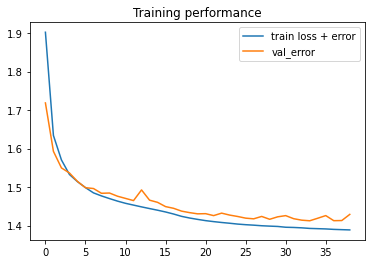

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

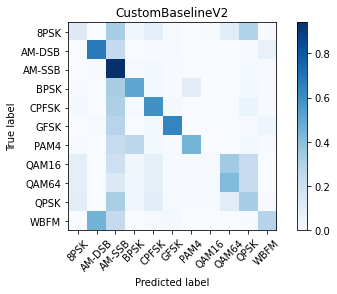

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08320950965824665


Overall Accuracy:  0.09500924214417746


Overall Accuracy:  0.09261223047013079


Overall Accuracy:  0.10119465917076599


Overall Accuracy:  0.11054913294797687


Overall Accuracy:  0.17472252058718224


Overall Accuracy:  0.2816194912217843


Overall Accuracy:  0.4022529069767442


Overall Accuracy:  0.478523251686191
Overall Accuracy:  0.585549964054637


Overall Accuracy:  0.6434277414669571


Overall Accuracy:  0.6877028489001081


Overall Accuracy:  0.6595825426944971


Overall Accuracy:  0.6649253731343283
Overall Accuracy: 

 0.6548991354466859


Overall Accuracy:  0.6675173168064163
Overall Accuracy:  0.6634579785264717


Overall Accuracy:  0.6506205340353516


Overall Accuracy:  0.6654384672070744


Overall Accuracy:  0.6487455197132617


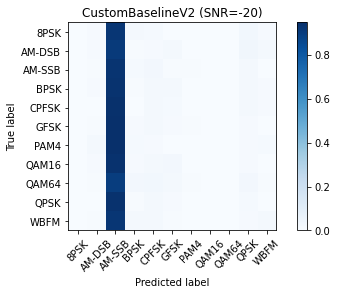

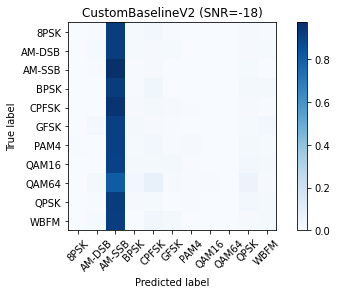

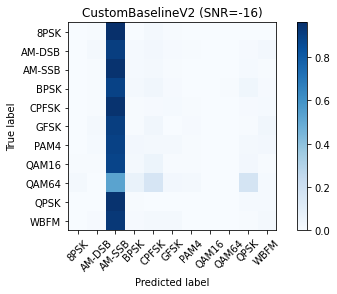

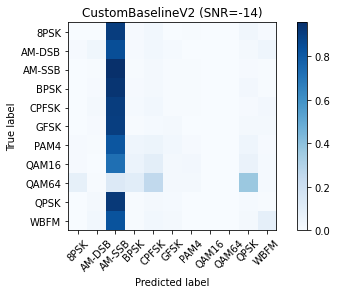

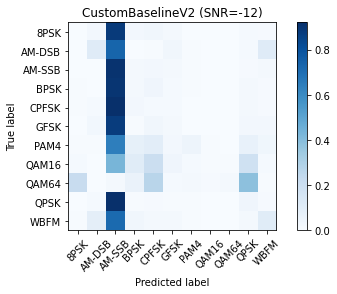

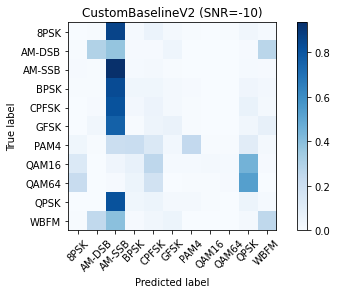

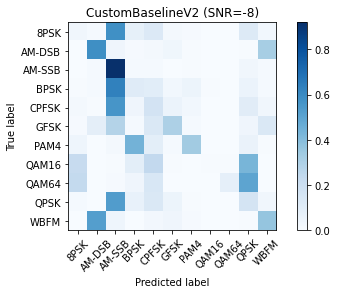

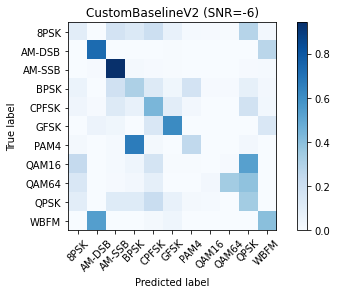

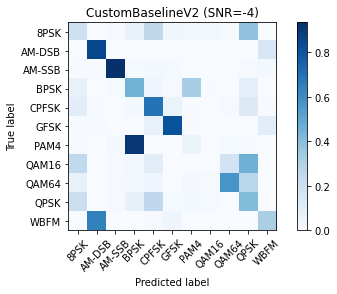

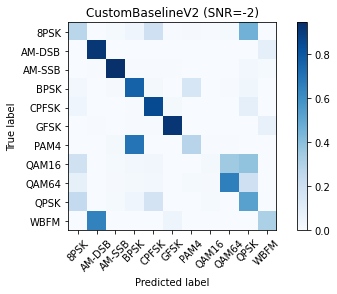

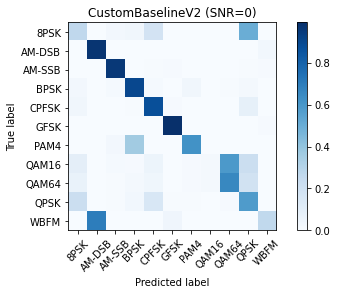

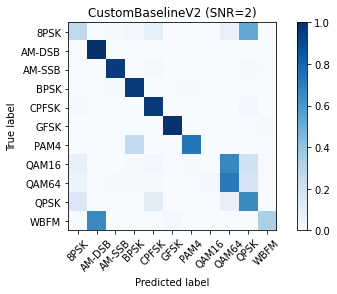

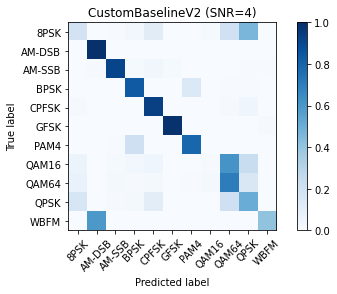

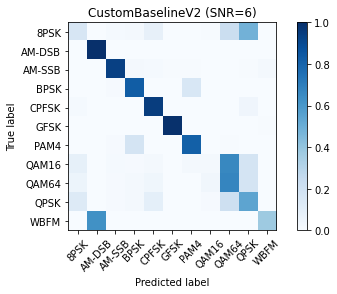

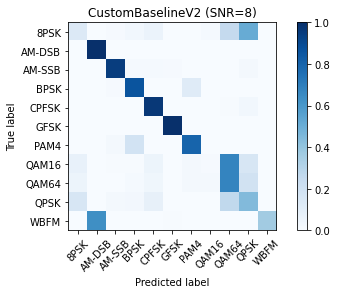

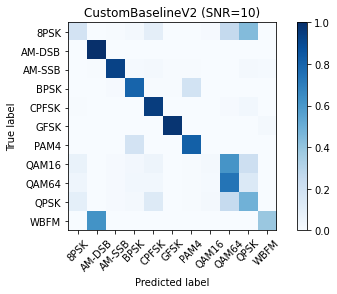

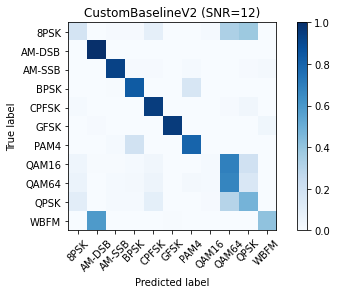

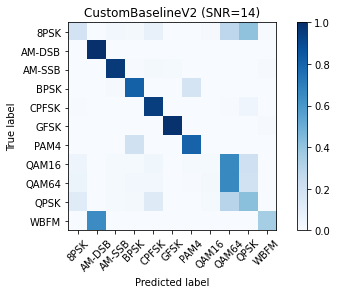

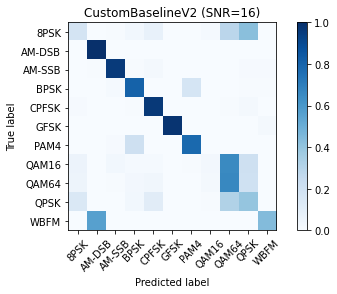

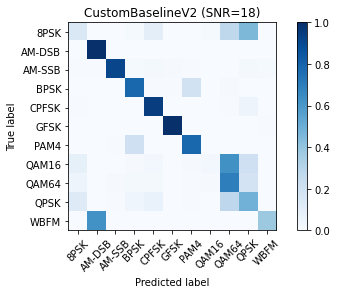

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,11,17,28,40,47,58,64,68,65,66,65,66,66,65,66,64


In [18]:
import statistics

statistics.mean(acc.values())

0.4505780183424494

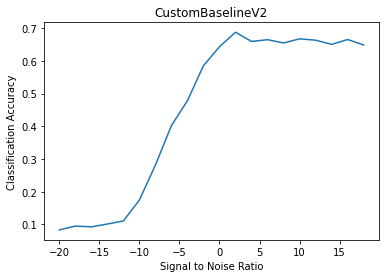

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)